<a href="https://colab.research.google.com/github/Jathurshan0330/BRATS-Brain-Tumor-Segmentation/blob/master/BM4301_Brain_Tumor_Segmentation_using_Atten_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Get Requirements

In [1]:
from IPython.display import clear_output

In [2]:
!pip install itk itkwidgets ipywidgets
clear_output()

In [3]:
#Import Libraries
import itk
import numpy as np
import nibabel as nib
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import torch.nn as nn
sns.set_style('darkgrid')
from seaborn.matrix import clustermap

#Load Data

In [4]:
def rescale_img(img, is_np = False):
  img = itk.array_from_image(img)
  img = ((img-np.min(img))/(np.max(img)-np.min(img)))*255
  if is_np:
    return img
  img = itk.image_from_array(img)
  return img

# Visulaization

In [5]:
def interactive_plot(flair_1,t1ce_1,t2_1,seg_1, cmap = 'jet', seed = None):
  def plot_image(slice):
    print(f"Plotting {slice} Slice")
    fig, ax = plt.subplots(1,4, figsize=(50,10))
    ax[0].imshow(flair[slice], cmap='gray', interpolation ='bilinear'), ax[0].set_title('FLAIR',fontsize = 50)
    ax[1].imshow(t1ce[slice], cmap='gray'), ax[1].set_title('T1ce',fontsize = 50)
    ax[2].imshow(t2[slice], cmap='gray'), ax[2].set_title('T2',fontsize = 50)
    ax[3].imshow(seg[slice], cmap='jet'), ax[3].set_title('seg',fontsize = 50)
    if seed:
      ax[0].scatter(seed[0], seed[1], color = 'r')
      ax[1].scatter(seed[0], seed[1], color = 'r')
      ax[2].scatter(seed[0], seed[1], color = 'r')
    plt.show()

    fig, ax = plt.subplots(1,4, figsize=(50,10))
    ax[0].imshow(flair_1[slice], cmap=cmap), ax[0].set_title('FLAIR',fontsize = 50)
    ax[1].imshow(t1ce_1[slice], cmap=cmap), ax[1].set_title('T1ce',fontsize = 50)
    ax[2].imshow(t2_1[slice], cmap=cmap), ax[2].set_title('T2',fontsize = 50)
    ax[3].imshow(seg_1[slice], cmap='jet'), ax[3].set_title('seg',fontsize = 50)
    plt.show()
  select_slice = IntSlider(min=0, max=flair.shape[0]-1, description='Select Slice', continuous_update=False)
  return interactive(plot_image, slice=select_slice)


In [6]:
def plotting_images(flair_1,t1ce_1,t2_1, seg_1, cmap = 'jet', seed = None, title = None):
  fig, ax = plt.subplots(1,4, figsize=(20,8))
  ax[0].imshow(flair_1, cmap=cmap, interpolation ='bilinear'), ax[0].set_title('FLAIR',fontsize = 20),ax[0].axis('off')
  ax[1].imshow(t1ce_1, cmap=cmap, interpolation ='bilinear'), ax[1].set_title('T1ce',fontsize = 20),ax[1].axis('off')
  ax[2].imshow(t2_1, cmap=cmap, interpolation ='bilinear'), ax[2].set_title('T2',fontsize = 20),ax[2].axis('off')
  ax[3].imshow(seg_1, cmap='jet', interpolation ='bilinear'), ax[3].set_title('Ground Truth',fontsize = 20),ax[3].axis('off')
  if seed:
      ax[0].scatter(seed[0][0], seed[0][1], color = 'r')
      ax[1].scatter(seed[1][0], seed[1][1], color = 'r')
      ax[2].scatter(seed[2][0], seed[2][1], color = 'r')

  if title:
      ax[0].set_title(title[0],fontsize = 20)
      ax[1].set_title(title[1],fontsize = 20)
      ax[2].set_title(title[2],fontsize = 20)
      ax[3].set_title(title[3],fontsize = 20)
  plt.show()


# Metrics

In [7]:
# Dice Coefficient

def dice_coeff(pred, target):
    smooth = 1e-5

    predf = pred.view(-1)
    targetf = target.view(-1)
    intersection = (predf * targetf).sum()
    
    return (2. * intersection + smooth) / (predf.sum() + targetf.sum() + smooth)

def get_dice_coef(pred, ground_truth, pred_thresh = None, gt_thresh = None, is_plot = True):
  ground_truth = torch.from_numpy(ground_truth)
  pred = torch.from_numpy(pred)
  if gt_thresh != None:
    if gt_thresh == 0:
      ground_truth[ground_truth > gt_thresh] = 1
      ground_truth[ground_truth <= gt_thresh] = 0
    else:
      ground_truth[ground_truth == gt_thresh] = 1
      ground_truth[ground_truth != gt_thresh] = 0
  if pred_thresh != None:
    pred[pred>pred_thresh] = 1
    pred[pred<=pred_thresh] = 0
  dice_score = dice_coeff(pred, ground_truth)
  if is_plot:
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    
    ax[0].imshow(pred, cmap='jet'), ax[0].set_title(f'Whole Tumor (Dice Score : {dice_score:.4f})',fontsize = 13), ax[0].axis('off')
    ax[1].imshow(ground_truth, cmap='jet'), ax[1].set_title('Ground truth',fontsize = 13), ax[1].axis('off')
    plt.show()
  return dice_score, pred, ground_truth


# Attention U-Net Based Brain Tumor Segmentation (Using only FLAIR images)

### Load Dataset

In [8]:
from torchvision import transforms, datasets
from pathlib import Path
from torch.utils import data
from PIL import Image, ImageFilter
from torch.utils.data import Dataset, DataLoader
import os
from torchvision.io import read_image
from skimage import io
import glob
from skimage.transform import  resize
import time

In [9]:
class BRATS(Dataset):
    def __init__(self, data_list,seg_list, device,data_type = None,  transform=None, target_transform=None):
        

        for dfile in range(len(data_list)):
          flair_fn = data_list[dfile]
          seg_fn = seg_list[dfile]
          if dfile == 0:
            if data_type == 'Val':
              self.flair = rescale_img(itk.imread(flair_fn), is_np = True)[30:-30,:,:]
              self.seg = rescale_img(itk.imread(seg_fn), is_np = True)[30:-30,:,:]       
            else:
              self.flair = rescale_img(itk.imread(flair_fn), is_np = True)
              self.seg = rescale_img(itk.imread(seg_fn), is_np = True)       
          else:
            self.flair = np.concatenate((self.flair,rescale_img(itk.imread(flair_fn), is_np = True)),axis = 0)
            self.seg = np.concatenate((self.seg,rescale_img(itk.imread(seg_fn), is_np = True)),axis = 0)

        self.seg[self.seg > 0] = 1
        print(self.flair.shape,self.seg.shape) 
        self.device = device
        self.transform = transform
        self.target_transform = target_transform


    def __len__(self):
        return len(self.flair)

    def __getitem__(self, idx):
      img = resize(self.flair[idx].reshape(1,240,240),(1,256,256))
      label = resize(self.seg[idx],(256,256))
      if self.transform:
          img = self.transform(img).to(self.device)     
      return img, label

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
from torchvision.transforms.transforms import ToTensor
data_list = glob.glob("/content/drive/MyDrive/brats2018/*flair.nii")  ##### Change this flair file path
seg_list = glob.glob("/content/drive/MyDrive/brats2018/*seg.nii")    ##### Change this to label file path

#### Change the split based on your requirement
train_data = data_list#[1:]
val_data = data_list#[0:1]

print(train_data)
brats_train = BRATS(data_list = train_data , seg_list = seg_list,
                          device = device, 
                          transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(
                          (0.5,), (0.5,)),
                          ])) 

brats_val = BRATS(data_list = val_data , seg_list = seg_list,
                          device = device, data_type = 'Val', 
                          transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(
                          (0.5,), (0.5,)),
                          ])) 

['/content/drive/MyDrive/brats2018/Brats18_2013_10_1_flair.nii']
(155, 240, 240) (155, 240, 240)
(95, 240, 240) (95, 240, 240)


In [13]:
train_data_loader = data.DataLoader(brats_train, batch_size = 16, shuffle = True)
val_data_loader = data.DataLoader(brats_val, batch_size = 16, shuffle = True)

torch.Size([16, 1, 256, 256]) torch.Size([16, 256, 256])


(<matplotlib.image.AxesImage at 0x7f6280029b50>, Text(0.5, 1.0, 'seg'))

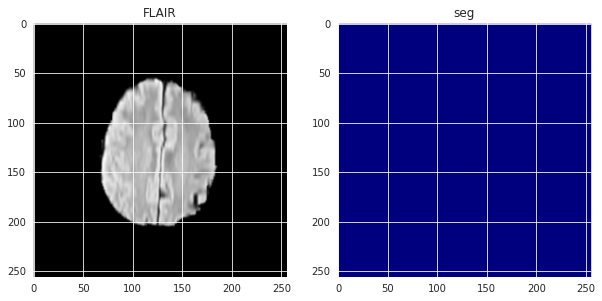

In [14]:
img, label   = next(iter(val_data_loader))
img = torch.moveaxis(img,1,-1)
print(img.shape, label.shape)

ind = 14
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(img[ind,0,:,:].cpu(), cmap='gray'), ax[0].set_title('FLAIR')
ax[1].imshow(label[ind,:,:].cpu(), cmap='jet'), ax[1].set_title('seg')

### Attention U-Net Model

In [ ]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x



class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi



class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=8)
        self.Conv2 = conv_block(ch_in=8,ch_out=16)
        self.Conv3 = conv_block(ch_in=16,ch_out=32)
        self.Conv4 = conv_block(ch_in=32,ch_out=64)
        self.Conv5 = conv_block(ch_in=64,ch_out=128)

        self.Up5 = up_conv(ch_in=128,ch_out=64)
        self.Att5 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv5 = conv_block(ch_in=128, ch_out=64)

        self.Up4 = up_conv(ch_in=64,ch_out=32)
        self.Att4 = Attention_block(F_g=32,F_l=32,F_int=16)
        self.Up_conv4 = conv_block(ch_in=64, ch_out=32)
        
        self.Up3 = up_conv(ch_in=32,ch_out=16)
        self.Att3 = Attention_block(F_g=16,F_l=16,F_int=8)
        self.Up_conv3 = conv_block(ch_in=32, ch_out=16)
        
        self.Up2 = up_conv(ch_in=16,ch_out=8)
        self.Att2 = Attention_block(F_g=8,F_l=8,F_int=4)
        self.Up_conv2 = conv_block(ch_in=16, ch_out=8)

        self.Conv_1x1 = nn.Conv2d(8,output_ch,kernel_size=1,stride=1,padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)
        d1 = self.sigmoid(d1)
        return d1

### Model Training

In [ ]:
u_net = AttU_Net(img_ch = 1).to(device)
criterion = nn.BCELoss()

lr_u  = 0.001
beta_1 = 0.9 
beta_2 = 0.999
n_epochs = 100

unet_optimizer =  torch.optim.Adam(u_net.parameters(), lr=lr_u, betas=(beta_1, beta_2))
out_img = u_net(img.float())

print(out_img.shape)

torch.Size([16, 1, 256, 256])


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

Training Epoch : [1/100]===============================================================================
Epoch: [1/100][0/20]	Time 0.668s (0.668s)	Speed 23.9 samples/s	Data 0.381s (0.381s)	Loss 0.66259 (0.66259)	
Epoch: [1/100][1/20]	Time 0.534s (0.601s)	Speed 30.0 samples/s	Data 0.360s (0.371s)	Loss 0.64374 (0.65317)	
Epoch: [1/100][2/20]	Time 0.544s (0.582s)	Speed 29.4 samples/s	Data 0.381s (0.374s)	Loss 0.62362 (0.64332)	
Epoch: [1/100][3/20]	Time 0.514s (0.565s)	Speed 31.1 samples/s	Data 0.350s (0.368s)	Loss 0.60875 (0.63468)	
Epoch: [1/100][4/20]	Time 0.519s (0.556s)	Speed 30.8 samples/s	Data 0.355s (0.366s)	Loss 0.59990 (0.62772)	
Epoch: [1/100][5/20]	Time 0.522s (0.550s)	Speed 30.6 samples/s	Data 0.359s (0.365s)	Loss 0.59102 (0.62161)	
Epoch: [1/100][6/20]	Time 0.530s (0.547s)	Speed 30.2 samples/s	Data 0.367s (0.365s)	Loss 0.58360 (0.61618)	
Epoch: [1/100][7/20]	Time 0.513s (0.543s)	Speed 31.2 samples/s	Data 0.349s (0.363s)	Loss 0.57554 (0.61110)	
Epoch: [1/100][8/20]	Time 0.528s

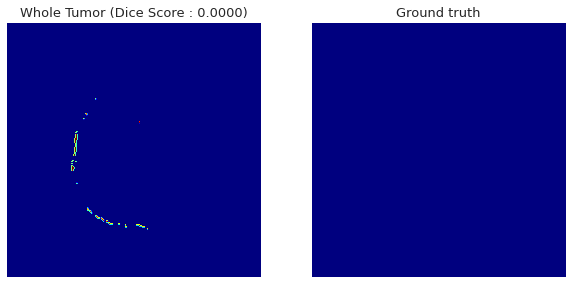

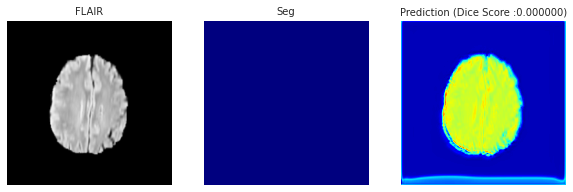

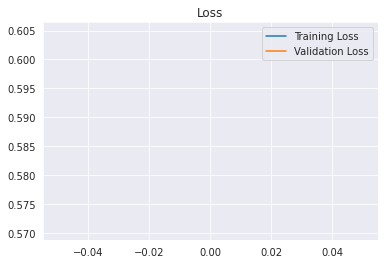

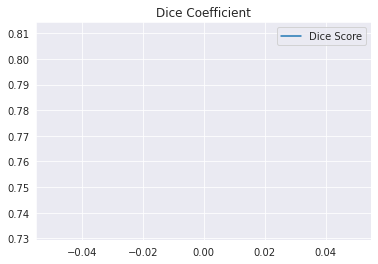

Training Epoch : [2/100]===============================================================================
Epoch: [2/100][0/20]	Time 0.649s (0.649s)	Speed 24.6 samples/s	Data 0.378s (0.378s)	Loss 0.51716 (0.51716)	
Epoch: [2/100][1/20]	Time 0.545s (0.597s)	Speed 29.4 samples/s	Data 0.380s (0.379s)	Loss 0.51659 (0.51688)	
Epoch: [2/100][2/20]	Time 0.513s (0.569s)	Speed 31.2 samples/s	Data 0.351s (0.369s)	Loss 0.51003 (0.51460)	
Epoch: [2/100][3/20]	Time 0.532s (0.560s)	Speed 30.1 samples/s	Data 0.368s (0.369s)	Loss 0.50628 (0.51252)	
Epoch: [2/100][4/20]	Time 0.527s (0.553s)	Speed 30.3 samples/s	Data 0.364s (0.368s)	Loss 0.50574 (0.51116)	
Epoch: [2/100][5/20]	Time 0.549s (0.553s)	Speed 29.1 samples/s	Data 0.384s (0.371s)	Loss 0.50169 (0.50958)	
Epoch: [2/100][6/20]	Time 0.530s (0.549s)	Speed 30.2 samples/s	Data 0.366s (0.370s)	Loss 0.50458 (0.50887)	
Epoch: [2/100][7/20]	Time 0.539s (0.548s)	Speed 29.7 samples/s	Data 0.374s (0.370s)	Loss 0.49907 (0.50764)	
Epoch: [2/100][8/20]	Time 0.522s

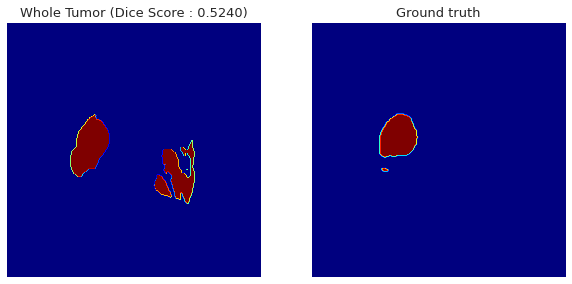

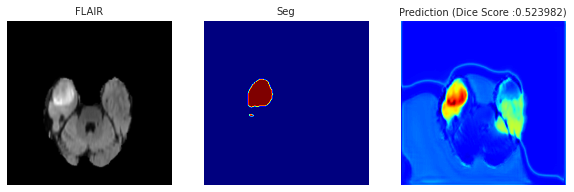

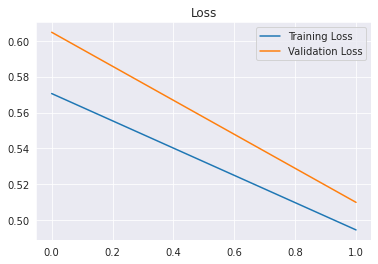

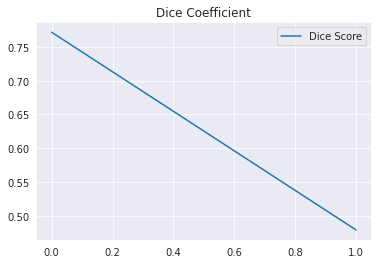

Training Epoch : [3/100]===============================================================================
Epoch: [3/100][0/20]	Time 0.627s (0.627s)	Speed 25.5 samples/s	Data 0.374s (0.374s)	Loss 0.48378 (0.48378)	
Epoch: [3/100][1/20]	Time 0.527s (0.577s)	Speed 30.4 samples/s	Data 0.361s (0.368s)	Loss 0.47029 (0.47704)	
Epoch: [3/100][2/20]	Time 0.543s (0.566s)	Speed 29.5 samples/s	Data 0.380s (0.372s)	Loss 0.47095 (0.47501)	
Epoch: [3/100][3/20]	Time 0.518s (0.554s)	Speed 30.9 samples/s	Data 0.354s (0.367s)	Loss 0.46729 (0.47308)	
Epoch: [3/100][4/20]	Time 0.516s (0.546s)	Speed 31.0 samples/s	Data 0.352s (0.364s)	Loss 0.46559 (0.47158)	
Epoch: [3/100][5/20]	Time 0.557s (0.548s)	Speed 28.7 samples/s	Data 0.391s (0.369s)	Loss 0.46402 (0.47032)	
Epoch: [3/100][6/20]	Time 0.521s (0.544s)	Speed 30.7 samples/s	Data 0.357s (0.367s)	Loss 0.46457 (0.46950)	
Epoch: [3/100][7/20]	Time 0.519s (0.541s)	Speed 30.8 samples/s	Data 0.352s (0.365s)	Loss 0.46305 (0.46869)	
Epoch: [3/100][8/20]	Time 0.530s

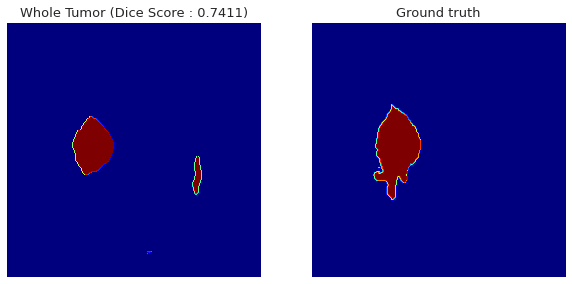

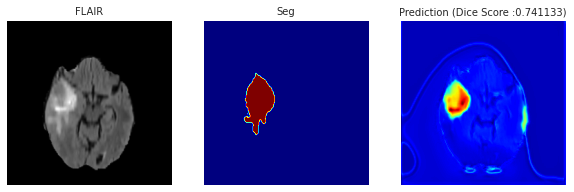

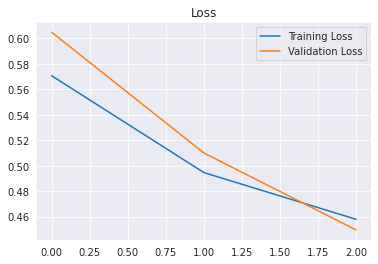

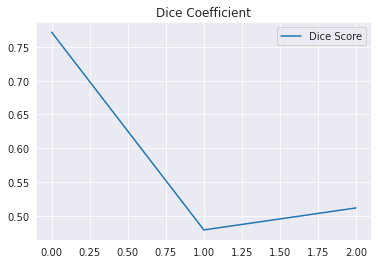

Training Epoch : [4/100]===============================================================================
Epoch: [4/100][0/20]	Time 0.650s (0.650s)	Speed 24.6 samples/s	Data 0.405s (0.405s)	Loss 0.43793 (0.43793)	
Epoch: [4/100][1/20]	Time 0.553s (0.601s)	Speed 28.9 samples/s	Data 0.376s (0.390s)	Loss 0.43868 (0.43830)	
Epoch: [4/100][2/20]	Time 0.533s (0.579s)	Speed 30.0 samples/s	Data 0.368s (0.383s)	Loss 0.43300 (0.43654)	
Epoch: [4/100][3/20]	Time 0.515s (0.563s)	Speed 31.1 samples/s	Data 0.351s (0.375s)	Loss 0.43288 (0.43562)	
Epoch: [4/100][4/20]	Time 0.515s (0.553s)	Speed 31.1 samples/s	Data 0.351s (0.370s)	Loss 0.42858 (0.43421)	
Epoch: [4/100][5/20]	Time 0.546s (0.552s)	Speed 29.3 samples/s	Data 0.383s (0.372s)	Loss 0.42774 (0.43313)	
Epoch: [4/100][6/20]	Time 0.523s (0.548s)	Speed 30.6 samples/s	Data 0.359s (0.370s)	Loss 0.42468 (0.43193)	
Epoch: [4/100][7/20]	Time 0.556s (0.549s)	Speed 28.8 samples/s	Data 0.392s (0.373s)	Loss 0.42319 (0.43083)	
Epoch: [4/100][8/20]	Time 0.526s

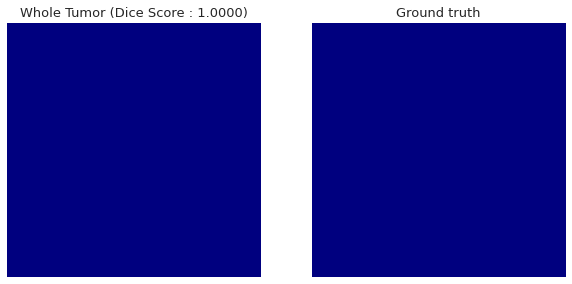

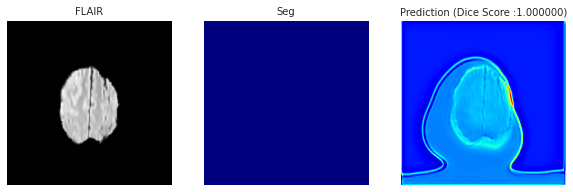

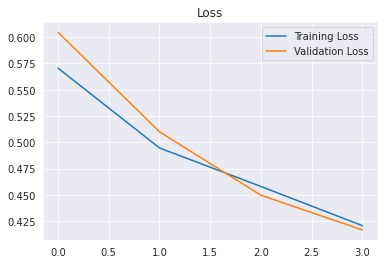

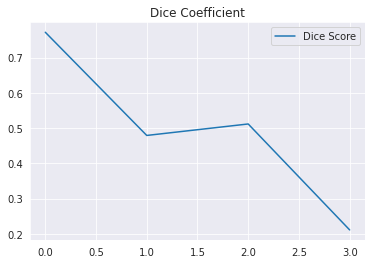

Training Epoch : [5/100]===============================================================================
Epoch: [5/100][0/20]	Time 0.643s (0.643s)	Speed 24.9 samples/s	Data 0.367s (0.367s)	Loss 0.40127 (0.40127)	
Epoch: [5/100][1/20]	Time 0.509s (0.576s)	Speed 31.4 samples/s	Data 0.344s (0.355s)	Loss 0.39734 (0.39931)	
Epoch: [5/100][2/20]	Time 0.528s (0.560s)	Speed 30.3 samples/s	Data 0.363s (0.358s)	Loss 0.39764 (0.39875)	
Epoch: [5/100][3/20]	Time 0.530s (0.552s)	Speed 30.2 samples/s	Data 0.365s (0.360s)	Loss 0.39877 (0.39875)	
Epoch: [5/100][4/20]	Time 0.536s (0.549s)	Speed 29.9 samples/s	Data 0.371s (0.362s)	Loss 0.39308 (0.39762)	
Epoch: [5/100][5/20]	Time 0.544s (0.548s)	Speed 29.4 samples/s	Data 0.380s (0.365s)	Loss 0.39330 (0.39690)	
Epoch: [5/100][6/20]	Time 0.542s (0.547s)	Speed 29.5 samples/s	Data 0.377s (0.367s)	Loss 0.39152 (0.39613)	
Epoch: [5/100][7/20]	Time 0.535s (0.546s)	Speed 29.9 samples/s	Data 0.371s (0.367s)	Loss 0.39277 (0.39571)	
Epoch: [5/100][8/20]	Time 0.554s

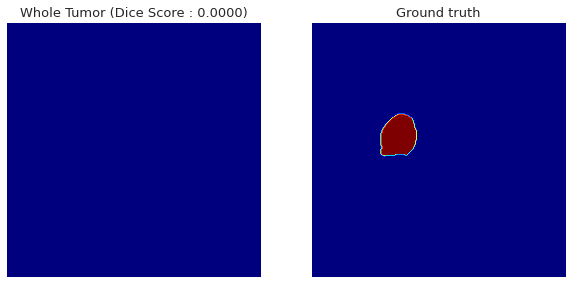

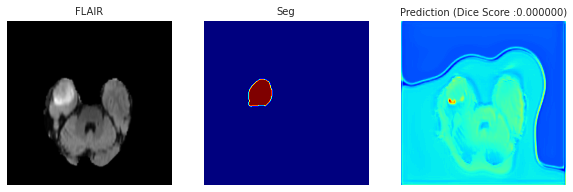

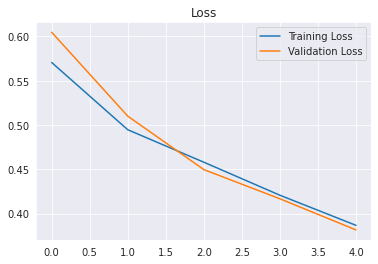

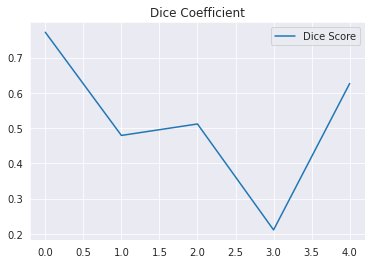

Training Epoch : [6/100]===============================================================================
Epoch: [6/100][0/20]	Time 0.617s (0.617s)	Speed 25.9 samples/s	Data 0.371s (0.371s)	Loss 0.36962 (0.36962)	
Epoch: [6/100][1/20]	Time 0.540s (0.578s)	Speed 29.6 samples/s	Data 0.362s (0.366s)	Loss 0.36906 (0.36934)	
Epoch: [6/100][2/20]	Time 0.530s (0.562s)	Speed 30.2 samples/s	Data 0.365s (0.366s)	Loss 0.36395 (0.36754)	
Epoch: [6/100][3/20]	Time 0.526s (0.553s)	Speed 30.4 samples/s	Data 0.362s (0.365s)	Loss 0.36414 (0.36669)	
Epoch: [6/100][4/20]	Time 0.513s (0.545s)	Speed 31.2 samples/s	Data 0.348s (0.362s)	Loss 0.36264 (0.36588)	
Epoch: [6/100][5/20]	Time 0.529s (0.542s)	Speed 30.2 samples/s	Data 0.365s (0.362s)	Loss 0.36498 (0.36573)	
Epoch: [6/100][6/20]	Time 0.528s (0.540s)	Speed 30.3 samples/s	Data 0.364s (0.362s)	Loss 0.35972 (0.36487)	
Epoch: [6/100][7/20]	Time 0.526s (0.539s)	Speed 30.4 samples/s	Data 0.362s (0.362s)	Loss 0.36002 (0.36427)	
Epoch: [6/100][8/20]	Time 0.524s

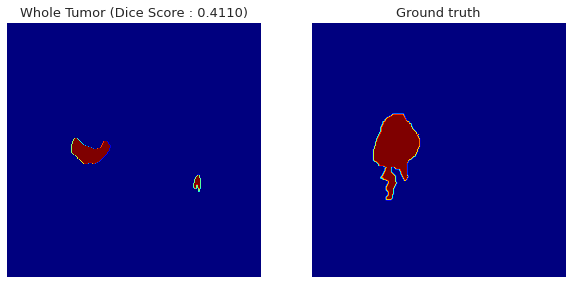

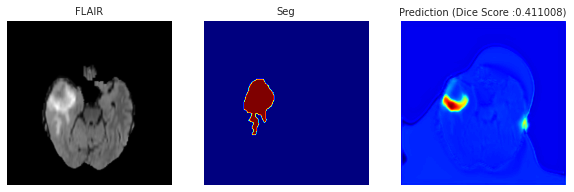

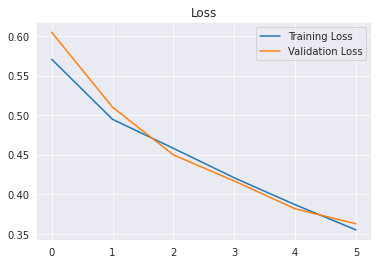

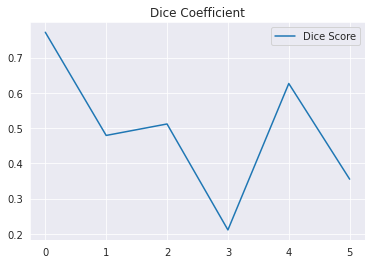

Training Epoch : [7/100]===============================================================================
Epoch: [7/100][0/20]	Time 0.641s (0.641s)	Speed 24.9 samples/s	Data 0.358s (0.358s)	Loss 0.33686 (0.33686)	
Epoch: [7/100][1/20]	Time 0.513s (0.577s)	Speed 31.2 samples/s	Data 0.345s (0.352s)	Loss 0.33540 (0.33613)	
Epoch: [7/100][2/20]	Time 0.506s (0.554s)	Speed 31.6 samples/s	Data 0.340s (0.348s)	Loss 0.33489 (0.33572)	
Epoch: [7/100][3/20]	Time 0.508s (0.542s)	Speed 31.5 samples/s	Data 0.343s (0.347s)	Loss 0.33174 (0.33472)	
Epoch: [7/100][4/20]	Time 0.522s (0.538s)	Speed 30.6 samples/s	Data 0.357s (0.349s)	Loss 0.33219 (0.33422)	
Epoch: [7/100][5/20]	Time 0.516s (0.535s)	Speed 31.0 samples/s	Data 0.352s (0.349s)	Loss 0.32946 (0.33342)	
Epoch: [7/100][6/20]	Time 0.517s (0.532s)	Speed 30.9 samples/s	Data 0.353s (0.350s)	Loss 0.32863 (0.33274)	
Epoch: [7/100][7/20]	Time 0.529s (0.532s)	Speed 30.2 samples/s	Data 0.363s (0.351s)	Loss 0.32776 (0.33212)	
Epoch: [7/100][8/20]	Time 0.519s

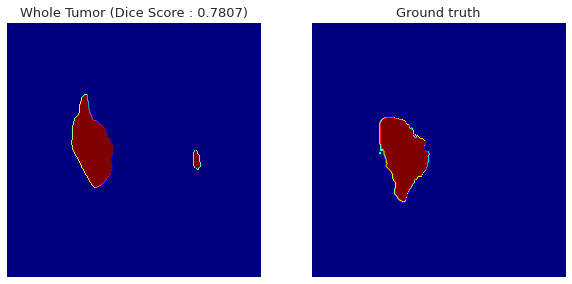

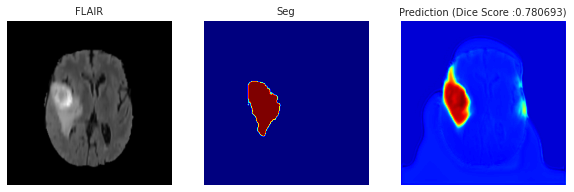

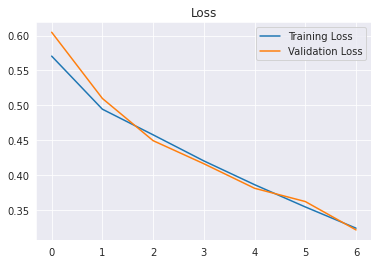

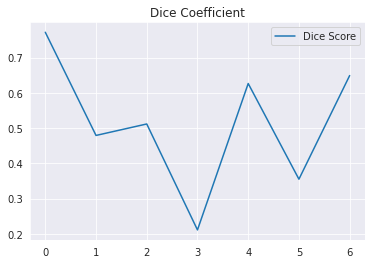

Training Epoch : [8/100]===============================================================================
Epoch: [8/100][0/20]	Time 0.629s (0.629s)	Speed 25.4 samples/s	Data 0.383s (0.383s)	Loss 0.30782 (0.30782)	
Epoch: [8/100][1/20]	Time 0.540s (0.585s)	Speed 29.6 samples/s	Data 0.371s (0.377s)	Loss 0.30700 (0.30741)	
Epoch: [8/100][2/20]	Time 0.528s (0.566s)	Speed 30.3 samples/s	Data 0.364s (0.373s)	Loss 0.30586 (0.30690)	
Epoch: [8/100][3/20]	Time 0.528s (0.556s)	Speed 30.3 samples/s	Data 0.362s (0.370s)	Loss 0.30993 (0.30765)	
Epoch: [8/100][4/20]	Time 0.515s (0.548s)	Speed 31.1 samples/s	Data 0.349s (0.366s)	Loss 0.30208 (0.30654)	
Epoch: [8/100][5/20]	Time 0.531s (0.545s)	Speed 30.1 samples/s	Data 0.366s (0.366s)	Loss 0.30228 (0.30583)	
Epoch: [8/100][6/20]	Time 0.531s (0.543s)	Speed 30.1 samples/s	Data 0.366s (0.366s)	Loss 0.30042 (0.30506)	
Epoch: [8/100][7/20]	Time 0.538s (0.543s)	Speed 29.7 samples/s	Data 0.374s (0.367s)	Loss 0.30525 (0.30508)	
Epoch: [8/100][8/20]	Time 0.512s

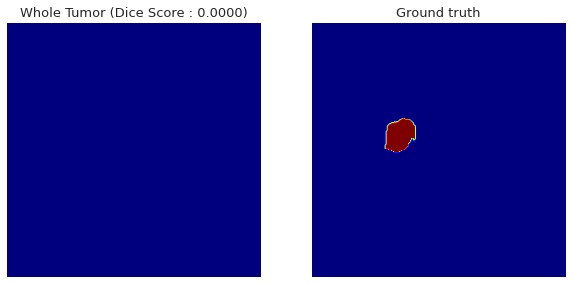

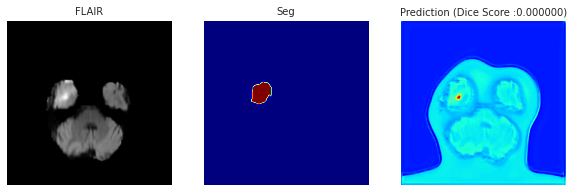

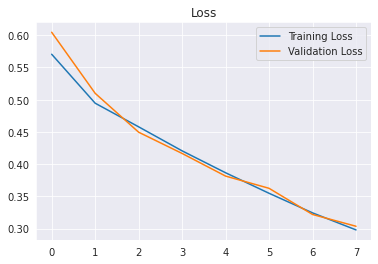

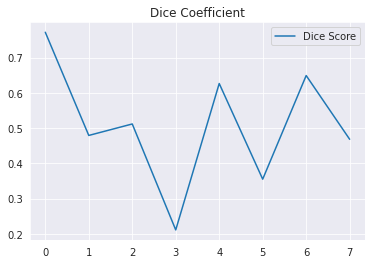

Training Epoch : [9/100]===============================================================================
Epoch: [9/100][0/20]	Time 0.659s (0.659s)	Speed 24.3 samples/s	Data 0.390s (0.390s)	Loss 0.28600 (0.28600)	
Epoch: [9/100][1/20]	Time 0.518s (0.588s)	Speed 30.9 samples/s	Data 0.352s (0.371s)	Loss 0.28241 (0.28420)	
Epoch: [9/100][2/20]	Time 0.536s (0.571s)	Speed 29.8 samples/s	Data 0.370s (0.371s)	Loss 0.28342 (0.28394)	
Epoch: [9/100][3/20]	Time 0.529s (0.561s)	Speed 30.2 samples/s	Data 0.363s (0.369s)	Loss 0.28217 (0.28350)	
Epoch: [9/100][4/20]	Time 0.544s (0.557s)	Speed 29.4 samples/s	Data 0.378s (0.371s)	Loss 0.28071 (0.28294)	
Epoch: [9/100][5/20]	Time 0.541s (0.555s)	Speed 29.6 samples/s	Data 0.375s (0.371s)	Loss 0.27728 (0.28200)	
Epoch: [9/100][6/20]	Time 0.532s (0.551s)	Speed 30.1 samples/s	Data 0.366s (0.371s)	Loss 0.27728 (0.28132)	
Epoch: [9/100][7/20]	Time 0.533s (0.549s)	Speed 30.0 samples/s	Data 0.368s (0.370s)	Loss 0.27669 (0.28074)	
Epoch: [9/100][8/20]	Time 0.561s

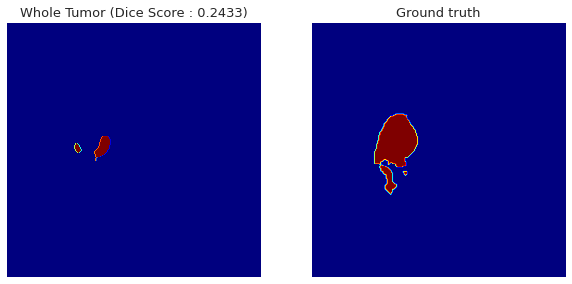

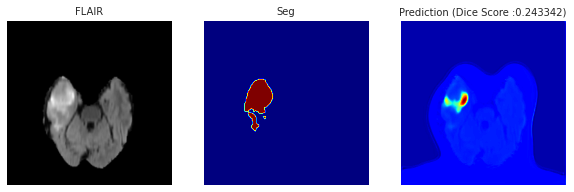

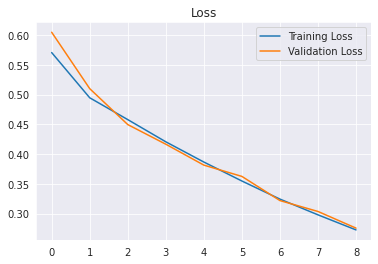

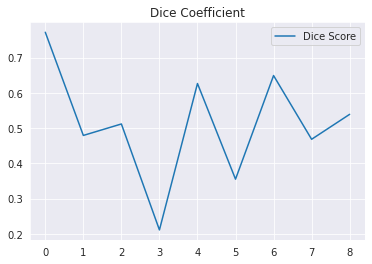

Training Epoch : [10/100]===============================================================================
Epoch: [10/100][0/20]	Time 0.592s (0.592s)	Speed 27.0 samples/s	Data 0.344s (0.344s)	Loss 0.26104 (0.26104)	
Epoch: [10/100][1/20]	Time 0.526s (0.559s)	Speed 30.4 samples/s	Data 0.355s (0.350s)	Loss 0.25628 (0.25866)	
Epoch: [10/100][2/20]	Time 0.529s (0.549s)	Speed 30.2 samples/s	Data 0.363s (0.354s)	Loss 0.25652 (0.25795)	
Epoch: [10/100][3/20]	Time 0.522s (0.542s)	Speed 30.6 samples/s	Data 0.357s (0.355s)	Loss 0.25801 (0.25796)	
Epoch: [10/100][4/20]	Time 0.541s (0.542s)	Speed 29.6 samples/s	Data 0.374s (0.359s)	Loss 0.26025 (0.25842)	
Epoch: [10/100][5/20]	Time 0.536s (0.541s)	Speed 29.9 samples/s	Data 0.364s (0.360s)	Loss 0.25208 (0.25736)	
Epoch: [10/100][6/20]	Time 0.519s (0.538s)	Speed 30.8 samples/s	Data 0.353s (0.359s)	Loss 0.25158 (0.25654)	
Epoch: [10/100][7/20]	Time 0.545s (0.539s)	Speed 29.4 samples/s	Data 0.379s (0.361s)	Loss 0.25275 (0.25606)	
Epoch: [10/100][8/20]	T

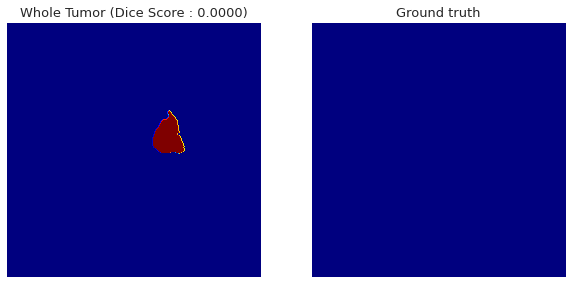

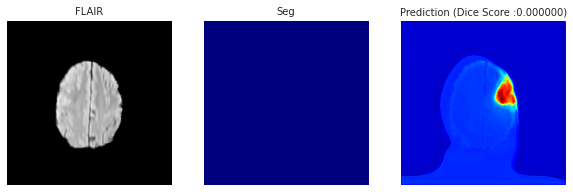

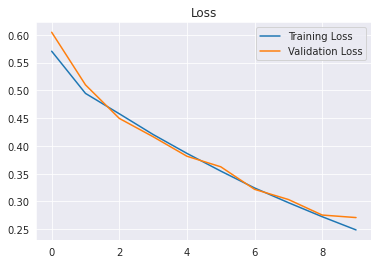

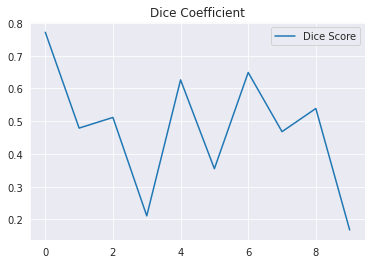

Training Epoch : [11/100]===============================================================================
Epoch: [11/100][0/20]	Time 0.645s (0.645s)	Speed 24.8 samples/s	Data 0.359s (0.359s)	Loss 0.23569 (0.23569)	
Epoch: [11/100][1/20]	Time 0.519s (0.582s)	Speed 30.8 samples/s	Data 0.353s (0.356s)	Loss 0.23427 (0.23498)	
Epoch: [11/100][2/20]	Time 0.534s (0.566s)	Speed 30.0 samples/s	Data 0.368s (0.360s)	Loss 0.23266 (0.23421)	
Epoch: [11/100][3/20]	Time 0.529s (0.557s)	Speed 30.2 samples/s	Data 0.364s (0.361s)	Loss 0.23518 (0.23445)	
Epoch: [11/100][4/20]	Time 0.522s (0.550s)	Speed 30.7 samples/s	Data 0.355s (0.360s)	Loss 0.23037 (0.23364)	
Epoch: [11/100][5/20]	Time 0.533s (0.547s)	Speed 30.0 samples/s	Data 0.368s (0.361s)	Loss 0.23048 (0.23311)	
Epoch: [11/100][6/20]	Time 0.523s (0.543s)	Speed 30.6 samples/s	Data 0.356s (0.360s)	Loss 0.23006 (0.23267)	
Epoch: [11/100][7/20]	Time 0.533s (0.542s)	Speed 30.0 samples/s	Data 0.366s (0.361s)	Loss 0.23193 (0.23258)	
Epoch: [11/100][8/20]	T

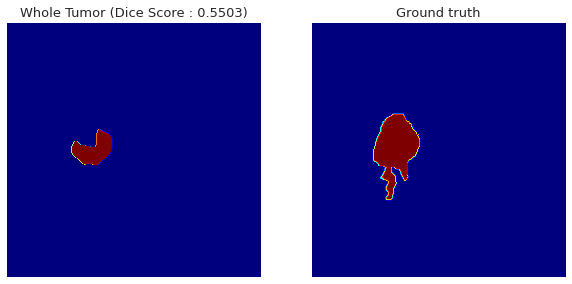

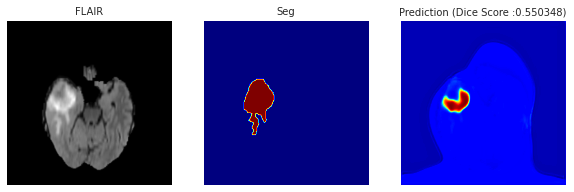

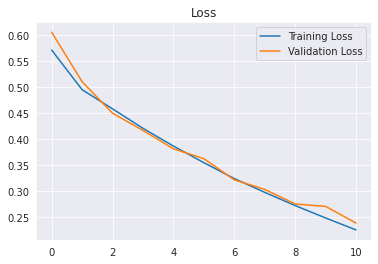

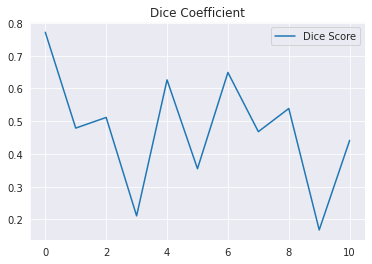

Training Epoch : [12/100]===============================================================================
Epoch: [12/100][0/20]	Time 0.627s (0.627s)	Speed 25.5 samples/s	Data 0.382s (0.382s)	Loss 0.21894 (0.21894)	
Epoch: [12/100][1/20]	Time 0.546s (0.587s)	Speed 29.3 samples/s	Data 0.367s (0.374s)	Loss 0.21377 (0.21636)	
Epoch: [12/100][2/20]	Time 0.533s (0.569s)	Speed 30.0 samples/s	Data 0.368s (0.372s)	Loss 0.21367 (0.21546)	
Epoch: [12/100][3/20]	Time 0.518s (0.556s)	Speed 30.9 samples/s	Data 0.352s (0.367s)	Loss 0.21161 (0.21450)	
Epoch: [12/100][4/20]	Time 0.543s (0.553s)	Speed 29.5 samples/s	Data 0.377s (0.369s)	Loss 0.21172 (0.21394)	
Epoch: [12/100][5/20]	Time 0.513s (0.547s)	Speed 31.2 samples/s	Data 0.347s (0.365s)	Loss 0.20960 (0.21322)	
Epoch: [12/100][6/20]	Time 0.532s (0.545s)	Speed 30.1 samples/s	Data 0.366s (0.365s)	Loss 0.20929 (0.21266)	
Epoch: [12/100][7/20]	Time 0.524s (0.542s)	Speed 30.6 samples/s	Data 0.359s (0.365s)	Loss 0.20785 (0.21206)	
Epoch: [12/100][8/20]	T

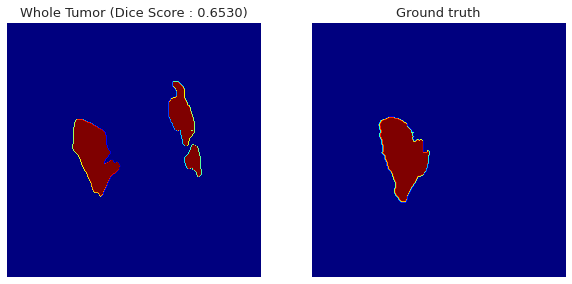

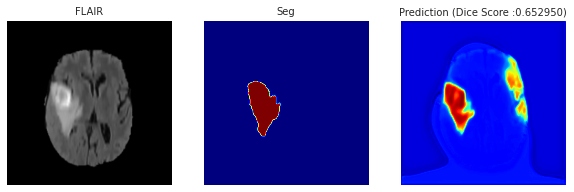

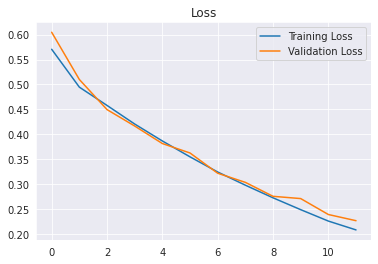

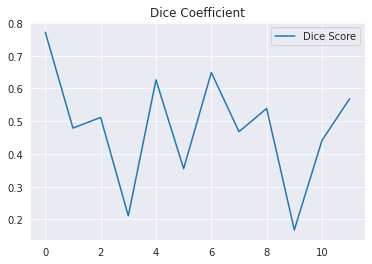

Training Epoch : [13/100]===============================================================================
Epoch: [13/100][0/20]	Time 0.636s (0.636s)	Speed 25.2 samples/s	Data 0.355s (0.355s)	Loss 0.19599 (0.19599)	
Epoch: [13/100][1/20]	Time 0.500s (0.568s)	Speed 32.0 samples/s	Data 0.335s (0.345s)	Loss 0.19650 (0.19625)	
Epoch: [13/100][2/20]	Time 0.533s (0.557s)	Speed 30.0 samples/s	Data 0.367s (0.352s)	Loss 0.19442 (0.19564)	
Epoch: [13/100][3/20]	Time 0.539s (0.552s)	Speed 29.7 samples/s	Data 0.374s (0.358s)	Loss 0.19355 (0.19512)	
Epoch: [13/100][4/20]	Time 0.539s (0.550s)	Speed 29.7 samples/s	Data 0.374s (0.361s)	Loss 0.19463 (0.19502)	
Epoch: [13/100][5/20]	Time 0.515s (0.544s)	Speed 31.1 samples/s	Data 0.350s (0.359s)	Loss 0.19380 (0.19482)	
Epoch: [13/100][6/20]	Time 0.533s (0.542s)	Speed 30.0 samples/s	Data 0.366s (0.360s)	Loss 0.19349 (0.19463)	
Epoch: [13/100][7/20]	Time 0.543s (0.542s)	Speed 29.5 samples/s	Data 0.377s (0.362s)	Loss 0.18961 (0.19400)	
Epoch: [13/100][8/20]	T

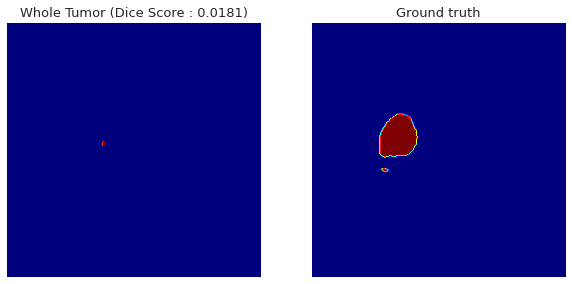

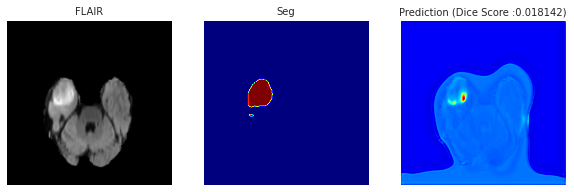

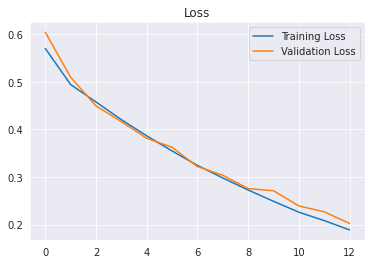

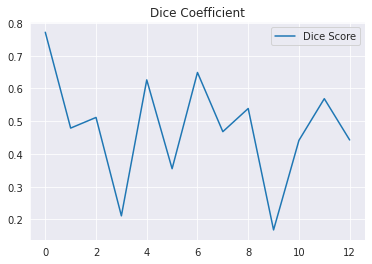

Training Epoch : [14/100]===============================================================================
Epoch: [14/100][0/20]	Time 0.676s (0.676s)	Speed 23.7 samples/s	Data 0.384s (0.384s)	Loss 0.17945 (0.17945)	
Epoch: [14/100][1/20]	Time 0.546s (0.611s)	Speed 29.3 samples/s	Data 0.379s (0.382s)	Loss 0.17905 (0.17925)	
Epoch: [14/100][2/20]	Time 0.534s (0.585s)	Speed 30.0 samples/s	Data 0.368s (0.377s)	Loss 0.17686 (0.17845)	
Epoch: [14/100][3/20]	Time 0.536s (0.573s)	Speed 29.8 samples/s	Data 0.371s (0.375s)	Loss 0.17745 (0.17820)	
Epoch: [14/100][4/20]	Time 0.526s (0.564s)	Speed 30.4 samples/s	Data 0.361s (0.373s)	Loss 0.17565 (0.17769)	
Epoch: [14/100][5/20]	Time 0.560s (0.563s)	Speed 28.6 samples/s	Data 0.394s (0.376s)	Loss 0.17696 (0.17757)	
Epoch: [14/100][6/20]	Time 0.520s (0.557s)	Speed 30.8 samples/s	Data 0.354s (0.373s)	Loss 0.17529 (0.17724)	
Epoch: [14/100][7/20]	Time 0.552s (0.556s)	Speed 29.0 samples/s	Data 0.387s (0.375s)	Loss 0.17290 (0.17670)	
Epoch: [14/100][8/20]	T

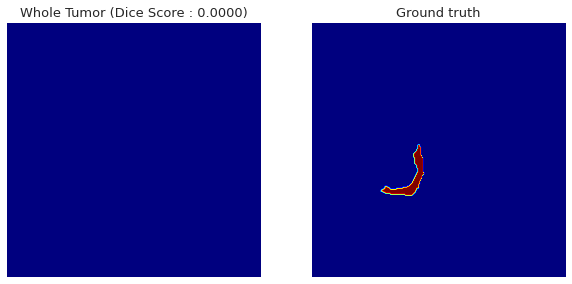

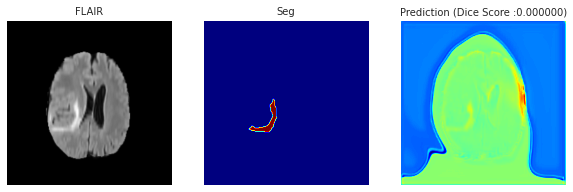

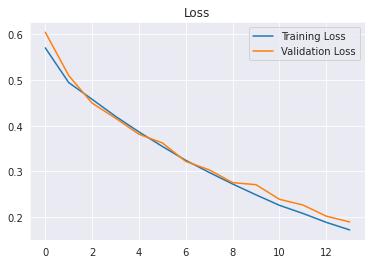

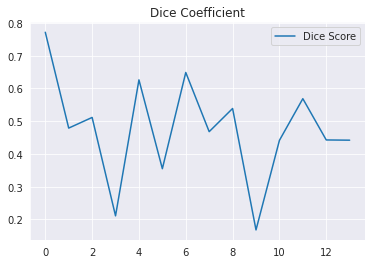

Training Epoch : [15/100]===============================================================================
Epoch: [15/100][0/20]	Time 0.645s (0.645s)	Speed 24.8 samples/s	Data 0.366s (0.366s)	Loss 0.16525 (0.16525)	
Epoch: [15/100][1/20]	Time 0.518s (0.582s)	Speed 30.9 samples/s	Data 0.353s (0.359s)	Loss 0.16546 (0.16536)	
Epoch: [15/100][2/20]	Time 0.535s (0.566s)	Speed 29.9 samples/s	Data 0.369s (0.362s)	Loss 0.16163 (0.16411)	
Epoch: [15/100][3/20]	Time 0.534s (0.558s)	Speed 30.0 samples/s	Data 0.367s (0.364s)	Loss 0.15985 (0.16305)	
Epoch: [15/100][4/20]	Time 0.556s (0.557s)	Speed 28.8 samples/s	Data 0.390s (0.369s)	Loss 0.16056 (0.16255)	
Epoch: [15/100][5/20]	Time 0.542s (0.555s)	Speed 29.5 samples/s	Data 0.375s (0.370s)	Loss 0.16153 (0.16238)	
Epoch: [15/100][6/20]	Time 0.616s (0.563s)	Speed 26.0 samples/s	Data 0.451s (0.381s)	Loss 0.16027 (0.16208)	
Epoch: [15/100][7/20]	Time 0.541s (0.561s)	Speed 29.6 samples/s	Data 0.374s (0.380s)	Loss 0.15896 (0.16169)	
Epoch: [15/100][8/20]	T

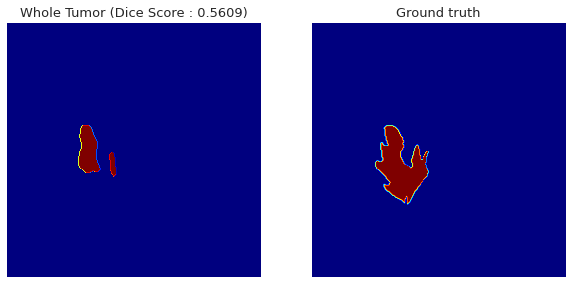

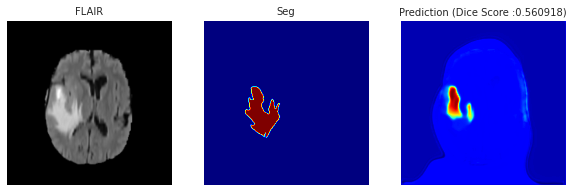

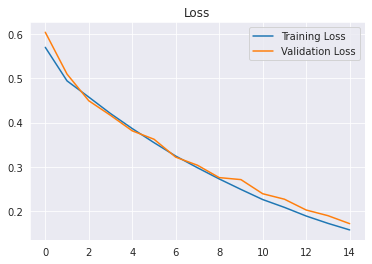

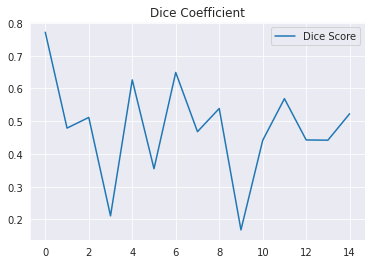

Training Epoch : [16/100]===============================================================================
Epoch: [16/100][0/20]	Time 0.665s (0.665s)	Speed 24.1 samples/s	Data 0.397s (0.397s)	Loss 0.15187 (0.15187)	
Epoch: [16/100][1/20]	Time 0.532s (0.598s)	Speed 30.1 samples/s	Data 0.365s (0.381s)	Loss 0.14855 (0.15021)	
Epoch: [16/100][2/20]	Time 0.533s (0.576s)	Speed 30.0 samples/s	Data 0.366s (0.376s)	Loss 0.14789 (0.14944)	
Epoch: [16/100][3/20]	Time 0.552s (0.570s)	Speed 29.0 samples/s	Data 0.387s (0.379s)	Loss 0.14774 (0.14901)	
Epoch: [16/100][4/20]	Time 0.560s (0.568s)	Speed 28.6 samples/s	Data 0.392s (0.381s)	Loss 0.14856 (0.14892)	
Epoch: [16/100][5/20]	Time 0.550s (0.565s)	Speed 29.1 samples/s	Data 0.384s (0.382s)	Loss 0.14673 (0.14856)	
Epoch: [16/100][6/20]	Time 0.561s (0.565s)	Speed 28.5 samples/s	Data 0.395s (0.384s)	Loss 0.14573 (0.14815)	
Epoch: [16/100][7/20]	Time 0.532s (0.561s)	Speed 30.1 samples/s	Data 0.366s (0.381s)	Loss 0.14596 (0.14788)	
Epoch: [16/100][8/20]	T

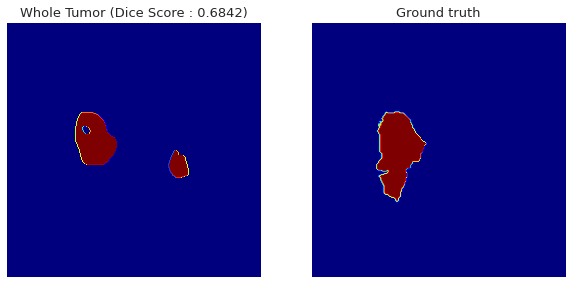

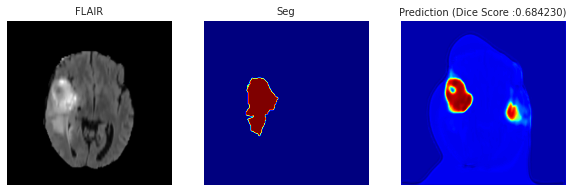

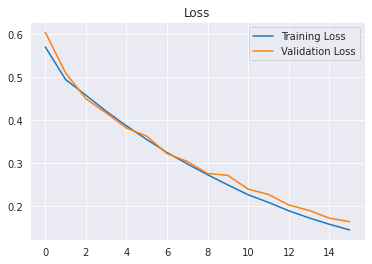

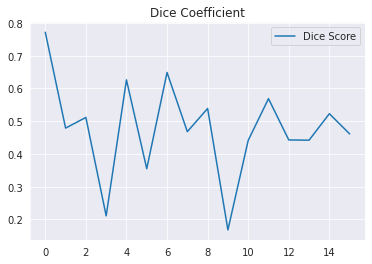

Training Epoch : [17/100]===============================================================================
Epoch: [17/100][0/20]	Time 0.595s (0.595s)	Speed 26.9 samples/s	Data 0.348s (0.348s)	Loss 0.13559 (0.13559)	
Epoch: [17/100][1/20]	Time 0.542s (0.568s)	Speed 29.5 samples/s	Data 0.361s (0.355s)	Loss 0.13924 (0.13742)	
Epoch: [17/100][2/20]	Time 0.537s (0.558s)	Speed 29.8 samples/s	Data 0.372s (0.360s)	Loss 0.13654 (0.13713)	
Epoch: [17/100][3/20]	Time 0.554s (0.557s)	Speed 28.9 samples/s	Data 0.388s (0.367s)	Loss 0.13395 (0.13633)	
Epoch: [17/100][4/20]	Time 0.530s (0.551s)	Speed 30.2 samples/s	Data 0.362s (0.366s)	Loss 0.13604 (0.13627)	
Epoch: [17/100][5/20]	Time 0.522s (0.546s)	Speed 30.7 samples/s	Data 0.354s (0.364s)	Loss 0.13424 (0.13594)	
Epoch: [17/100][6/20]	Time 0.517s (0.542s)	Speed 30.9 samples/s	Data 0.352s (0.362s)	Loss 0.13398 (0.13566)	
Epoch: [17/100][7/20]	Time 0.552s (0.544s)	Speed 29.0 samples/s	Data 0.386s (0.365s)	Loss 0.13234 (0.13524)	
Epoch: [17/100][8/20]	T

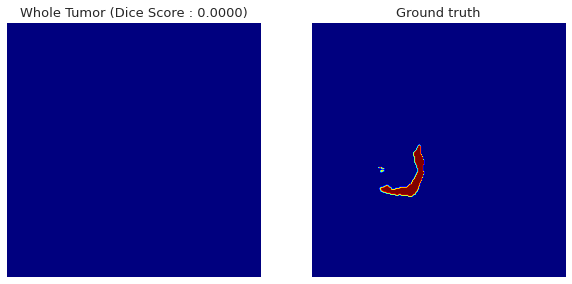

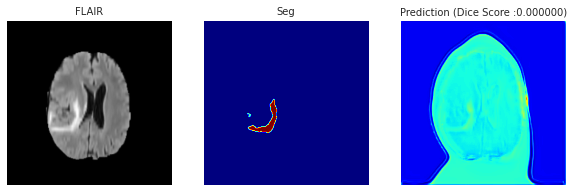

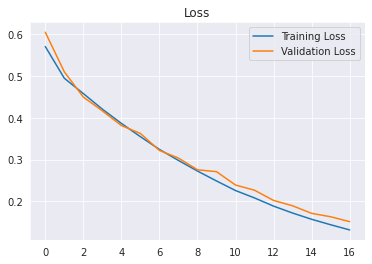

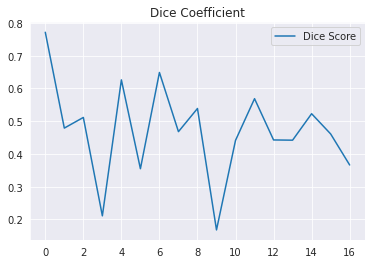

Training Epoch : [18/100]===============================================================================
Epoch: [18/100][0/20]	Time 0.640s (0.640s)	Speed 25.0 samples/s	Data 0.362s (0.362s)	Loss 0.12675 (0.12675)	
Epoch: [18/100][1/20]	Time 0.521s (0.580s)	Speed 30.7 samples/s	Data 0.354s (0.358s)	Loss 0.12512 (0.12593)	
Epoch: [18/100][2/20]	Time 0.533s (0.565s)	Speed 30.0 samples/s	Data 0.357s (0.358s)	Loss 0.12418 (0.12535)	
Epoch: [18/100][3/20]	Time 0.528s (0.555s)	Speed 30.3 samples/s	Data 0.363s (0.359s)	Loss 0.12437 (0.12510)	
Epoch: [18/100][4/20]	Time 0.527s (0.550s)	Speed 30.3 samples/s	Data 0.356s (0.358s)	Loss 0.12441 (0.12497)	
Epoch: [18/100][5/20]	Time 0.547s (0.549s)	Speed 29.3 samples/s	Data 0.381s (0.362s)	Loss 0.12246 (0.12455)	
Epoch: [18/100][6/20]	Time 0.562s (0.551s)	Speed 28.5 samples/s	Data 0.396s (0.367s)	Loss 0.12249 (0.12425)	
Epoch: [18/100][7/20]	Time 0.537s (0.549s)	Speed 29.8 samples/s	Data 0.371s (0.367s)	Loss 0.12163 (0.12393)	
Epoch: [18/100][8/20]	T

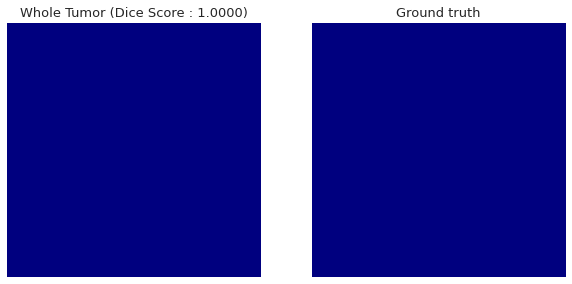

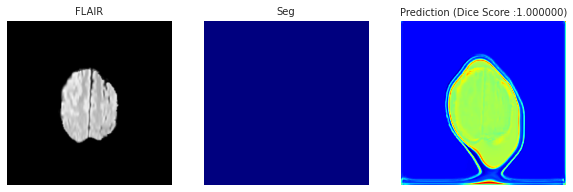

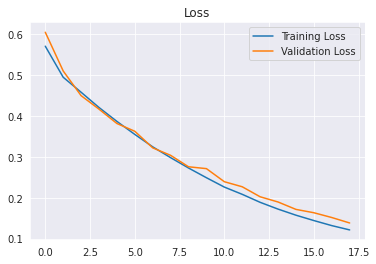

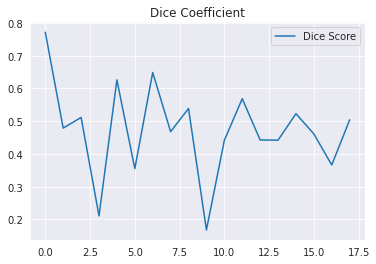

Training Epoch : [19/100]===============================================================================
Epoch: [19/100][0/20]	Time 0.662s (0.662s)	Speed 24.2 samples/s	Data 0.418s (0.418s)	Loss 0.11480 (0.11480)	
Epoch: [19/100][1/20]	Time 0.562s (0.612s)	Speed 28.5 samples/s	Data 0.386s (0.402s)	Loss 0.11716 (0.11598)	
Epoch: [19/100][2/20]	Time 0.539s (0.588s)	Speed 29.7 samples/s	Data 0.373s (0.392s)	Loss 0.11315 (0.11504)	
Epoch: [19/100][3/20]	Time 0.561s (0.581s)	Speed 28.5 samples/s	Data 0.394s (0.393s)	Loss 0.11256 (0.11442)	
Epoch: [19/100][4/20]	Time 0.553s (0.575s)	Speed 29.0 samples/s	Data 0.387s (0.392s)	Loss 0.11400 (0.11433)	
Epoch: [19/100][5/20]	Time 0.576s (0.575s)	Speed 27.8 samples/s	Data 0.409s (0.395s)	Loss 0.11215 (0.11397)	
Epoch: [19/100][6/20]	Time 0.546s (0.571s)	Speed 29.3 samples/s	Data 0.380s (0.392s)	Loss 0.11240 (0.11375)	
Epoch: [19/100][7/20]	Time 0.565s (0.571s)	Speed 28.3 samples/s	Data 0.399s (0.393s)	Loss 0.11200 (0.11353)	
Epoch: [19/100][8/20]	T

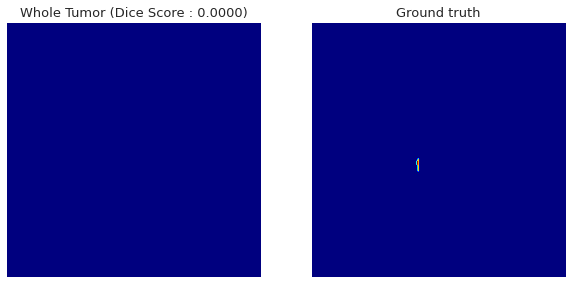

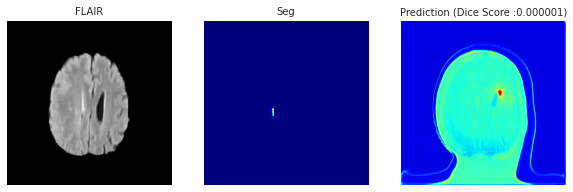

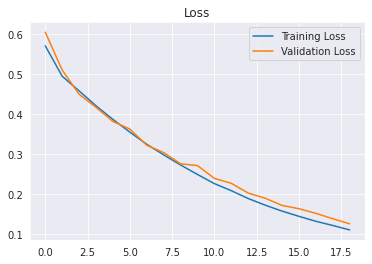

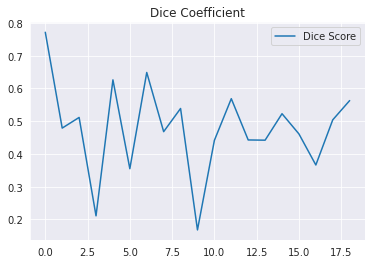

Training Epoch : [20/100]===============================================================================
Epoch: [20/100][0/20]	Time 0.667s (0.667s)	Speed 24.0 samples/s	Data 0.397s (0.397s)	Loss 0.10466 (0.10466)	
Epoch: [20/100][1/20]	Time 0.516s (0.592s)	Speed 31.0 samples/s	Data 0.349s (0.373s)	Loss 0.10435 (0.10450)	
Epoch: [20/100][2/20]	Time 0.533s (0.572s)	Speed 30.0 samples/s	Data 0.366s (0.371s)	Loss 0.10245 (0.10382)	
Epoch: [20/100][3/20]	Time 0.557s (0.568s)	Speed 28.7 samples/s	Data 0.382s (0.374s)	Loss 0.10495 (0.10410)	
Epoch: [20/100][4/20]	Time 0.519s (0.559s)	Speed 30.8 samples/s	Data 0.353s (0.369s)	Loss 0.10165 (0.10361)	
Epoch: [20/100][5/20]	Time 0.516s (0.551s)	Speed 31.0 samples/s	Data 0.350s (0.366s)	Loss 0.10199 (0.10334)	
Epoch: [20/100][6/20]	Time 0.548s (0.551s)	Speed 29.2 samples/s	Data 0.380s (0.368s)	Loss 0.10077 (0.10297)	
Epoch: [20/100][7/20]	Time 0.549s (0.551s)	Speed 29.2 samples/s	Data 0.383s (0.370s)	Loss 0.10020 (0.10262)	
Epoch: [20/100][8/20]	T

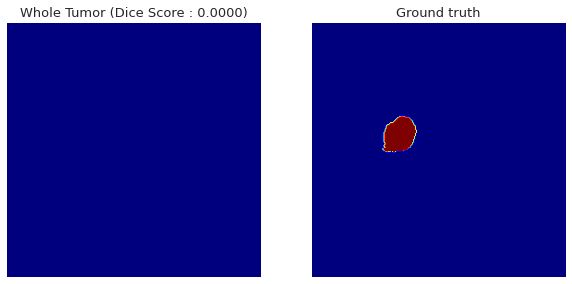

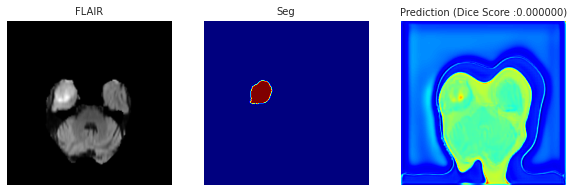

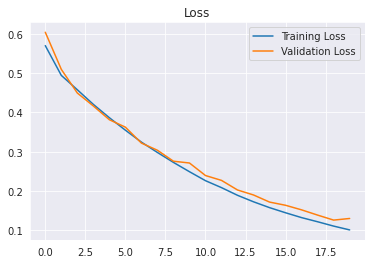

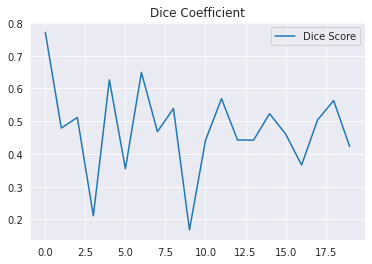

Training Epoch : [21/100]===============================================================================
Epoch: [21/100][0/20]	Time 0.658s (0.658s)	Speed 24.3 samples/s	Data 0.402s (0.402s)	Loss 0.09788 (0.09788)	
Epoch: [21/100][1/20]	Time 0.537s (0.598s)	Speed 29.8 samples/s	Data 0.370s (0.386s)	Loss 0.09724 (0.09756)	
Epoch: [21/100][2/20]	Time 0.531s (0.575s)	Speed 30.2 samples/s	Data 0.363s (0.378s)	Loss 0.09390 (0.09634)	
Epoch: [21/100][3/20]	Time 0.567s (0.573s)	Speed 28.2 samples/s	Data 0.401s (0.384s)	Loss 0.09316 (0.09554)	
Epoch: [21/100][4/20]	Time 0.535s (0.566s)	Speed 29.9 samples/s	Data 0.369s (0.381s)	Loss 0.09372 (0.09518)	
Epoch: [21/100][5/20]	Time 0.554s (0.564s)	Speed 28.9 samples/s	Data 0.387s (0.382s)	Loss 0.09186 (0.09462)	
Epoch: [21/100][6/20]	Time 0.532s (0.559s)	Speed 30.1 samples/s	Data 0.365s (0.380s)	Loss 0.09378 (0.09450)	
Epoch: [21/100][7/20]	Time 0.570s (0.561s)	Speed 28.1 samples/s	Data 0.404s (0.383s)	Loss 0.09260 (0.09427)	
Epoch: [21/100][8/20]	T

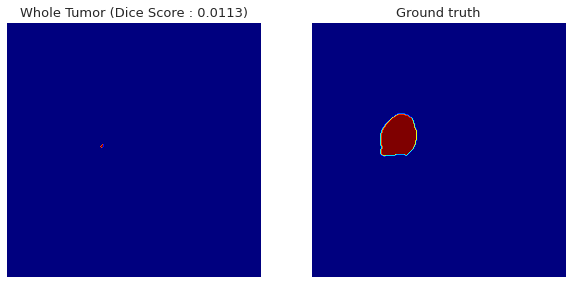

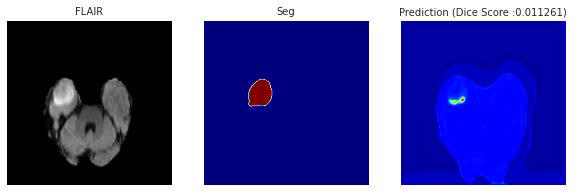

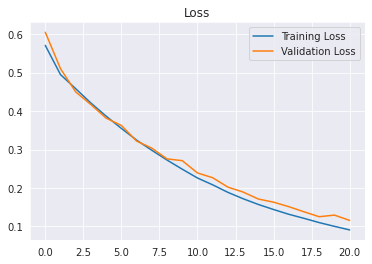

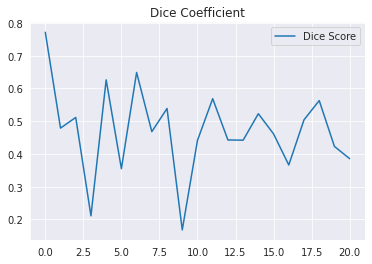

Training Epoch : [22/100]===============================================================================
Epoch: [22/100][0/20]	Time 0.650s (0.650s)	Speed 24.6 samples/s	Data 0.392s (0.392s)	Loss 0.08641 (0.08641)	
Epoch: [22/100][1/20]	Time 0.526s (0.588s)	Speed 30.4 samples/s	Data 0.359s (0.375s)	Loss 0.08582 (0.08612)	
Epoch: [22/100][2/20]	Time 0.554s (0.577s)	Speed 28.9 samples/s	Data 0.388s (0.380s)	Loss 0.08540 (0.08588)	
Epoch: [22/100][3/20]	Time 0.559s (0.572s)	Speed 28.6 samples/s	Data 0.392s (0.383s)	Loss 0.08881 (0.08661)	
Epoch: [22/100][4/20]	Time 0.559s (0.570s)	Speed 28.6 samples/s	Data 0.393s (0.385s)	Loss 0.08411 (0.08611)	
Epoch: [22/100][5/20]	Time 0.592s (0.573s)	Speed 27.0 samples/s	Data 0.426s (0.392s)	Loss 0.08351 (0.08568)	
Epoch: [22/100][6/20]	Time 0.545s (0.569s)	Speed 29.4 samples/s	Data 0.379s (0.390s)	Loss 0.08545 (0.08565)	
Epoch: [22/100][7/20]	Time 0.551s (0.567s)	Speed 29.0 samples/s	Data 0.383s (0.389s)	Loss 0.08389 (0.08543)	
Epoch: [22/100][8/20]	T

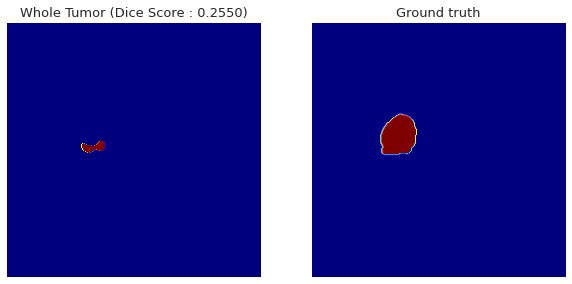

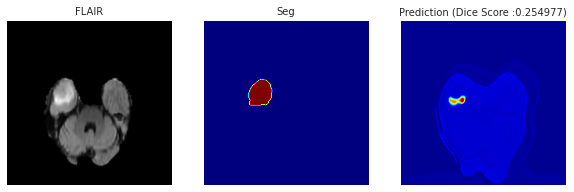

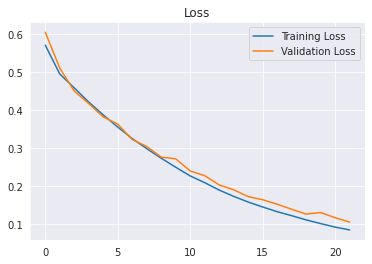

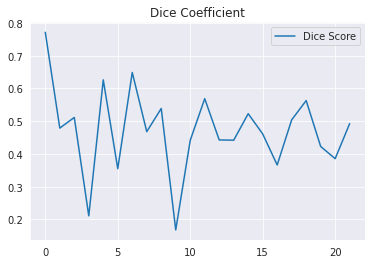

Training Epoch : [23/100]===============================================================================
Epoch: [23/100][0/20]	Time 0.643s (0.643s)	Speed 24.9 samples/s	Data 0.379s (0.379s)	Loss 0.08039 (0.08039)	
Epoch: [23/100][1/20]	Time 0.562s (0.603s)	Speed 28.4 samples/s	Data 0.396s (0.387s)	Loss 0.07922 (0.07980)	
Epoch: [23/100][2/20]	Time 0.557s (0.587s)	Speed 28.7 samples/s	Data 0.389s (0.388s)	Loss 0.07843 (0.07935)	
Epoch: [23/100][3/20]	Time 0.579s (0.585s)	Speed 27.6 samples/s	Data 0.413s (0.394s)	Loss 0.07877 (0.07920)	
Epoch: [23/100][4/20]	Time 0.556s (0.579s)	Speed 28.8 samples/s	Data 0.389s (0.393s)	Loss 0.07752 (0.07887)	
Epoch: [23/100][5/20]	Time 0.532s (0.571s)	Speed 30.1 samples/s	Data 0.365s (0.388s)	Loss 0.07809 (0.07874)	
Epoch: [23/100][6/20]	Time 0.522s (0.564s)	Speed 30.6 samples/s	Data 0.355s (0.384s)	Loss 0.07642 (0.07841)	
Epoch: [23/100][7/20]	Time 0.554s (0.563s)	Speed 28.9 samples/s	Data 0.387s (0.384s)	Loss 0.07629 (0.07814)	
Epoch: [23/100][8/20]	T

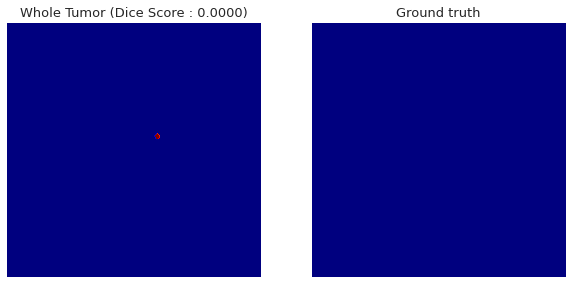

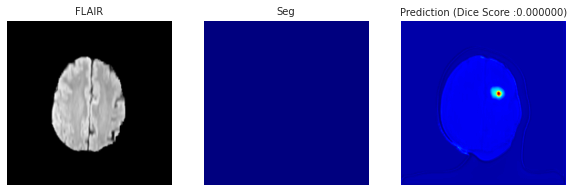

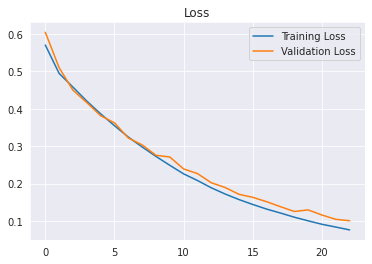

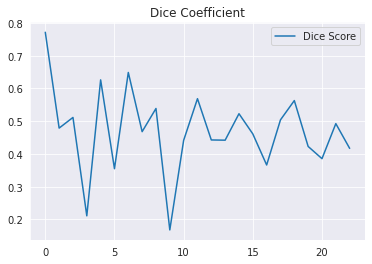

Training Epoch : [24/100]===============================================================================
Epoch: [24/100][0/20]	Time 0.686s (0.686s)	Speed 23.3 samples/s	Data 0.436s (0.436s)	Loss 0.07328 (0.07328)	
Epoch: [24/100][1/20]	Time 0.574s (0.630s)	Speed 27.9 samples/s	Data 0.404s (0.420s)	Loss 0.07169 (0.07248)	
Epoch: [24/100][2/20]	Time 0.558s (0.606s)	Speed 28.7 samples/s	Data 0.392s (0.411s)	Loss 0.07063 (0.07187)	
Epoch: [24/100][3/20]	Time 0.542s (0.590s)	Speed 29.5 samples/s	Data 0.375s (0.402s)	Loss 0.07076 (0.07159)	
Epoch: [24/100][4/20]	Time 0.511s (0.574s)	Speed 31.3 samples/s	Data 0.345s (0.390s)	Loss 0.07023 (0.07132)	
Epoch: [24/100][5/20]	Time 0.573s (0.574s)	Speed 27.9 samples/s	Data 0.405s (0.393s)	Loss 0.07467 (0.07187)	
Epoch: [24/100][6/20]	Time 0.534s (0.569s)	Speed 29.9 samples/s	Data 0.367s (0.389s)	Loss 0.07077 (0.07172)	
Epoch: [24/100][7/20]	Time 0.559s (0.567s)	Speed 28.6 samples/s	Data 0.392s (0.390s)	Loss 0.06941 (0.07143)	
Epoch: [24/100][8/20]	T

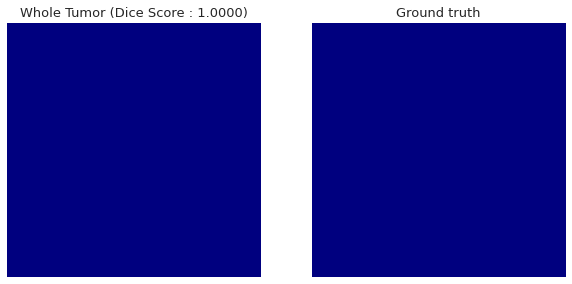

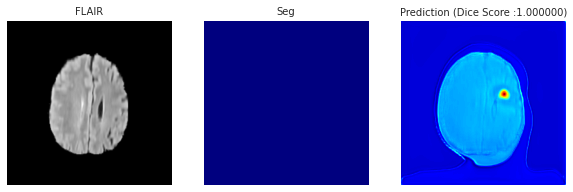

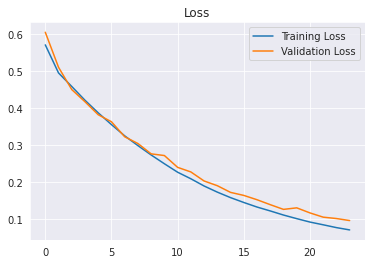

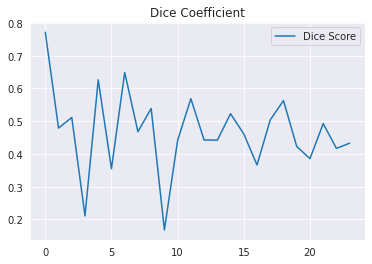

Training Epoch : [25/100]===============================================================================
Epoch: [25/100][0/20]	Time 0.652s (0.652s)	Speed 24.6 samples/s	Data 0.390s (0.390s)	Loss 0.06754 (0.06754)	
Epoch: [25/100][1/20]	Time 0.525s (0.588s)	Speed 30.5 samples/s	Data 0.358s (0.374s)	Loss 0.06621 (0.06688)	
Epoch: [25/100][2/20]	Time 0.520s (0.566s)	Speed 30.8 samples/s	Data 0.354s (0.367s)	Loss 0.06503 (0.06626)	
Epoch: [25/100][3/20]	Time 0.518s (0.554s)	Speed 30.9 samples/s	Data 0.351s (0.363s)	Loss 0.06464 (0.06585)	
Epoch: [25/100][4/20]	Time 0.522s (0.547s)	Speed 30.7 samples/s	Data 0.355s (0.361s)	Loss 0.06440 (0.06556)	
Epoch: [25/100][5/20]	Time 0.496s (0.539s)	Speed 32.3 samples/s	Data 0.330s (0.356s)	Loss 0.06634 (0.06569)	
Epoch: [25/100][6/20]	Time 0.507s (0.534s)	Speed 31.6 samples/s	Data 0.340s (0.354s)	Loss 0.06406 (0.06546)	
Epoch: [25/100][7/20]	Time 0.527s (0.533s)	Speed 30.3 samples/s	Data 0.361s (0.355s)	Loss 0.06439 (0.06533)	
Epoch: [25/100][8/20]	T

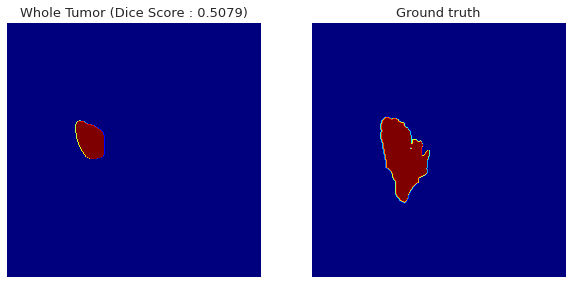

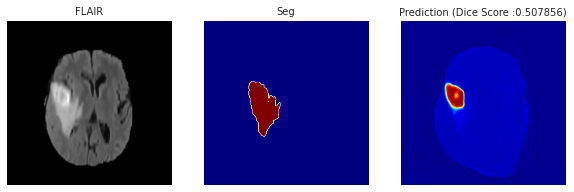

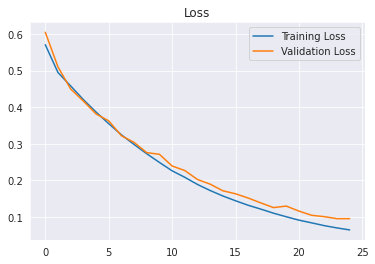

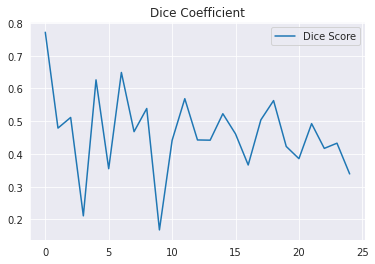

Training Epoch : [26/100]===============================================================================
Epoch: [26/100][0/20]	Time 0.646s (0.646s)	Speed 24.8 samples/s	Data 0.361s (0.361s)	Loss 0.06206 (0.06206)	
Epoch: [26/100][1/20]	Time 0.535s (0.590s)	Speed 29.9 samples/s	Data 0.368s (0.365s)	Loss 0.06141 (0.06173)	
Epoch: [26/100][2/20]	Time 0.538s (0.573s)	Speed 29.8 samples/s	Data 0.371s (0.367s)	Loss 0.06037 (0.06128)	
Epoch: [26/100][3/20]	Time 0.550s (0.567s)	Speed 29.1 samples/s	Data 0.384s (0.371s)	Loss 0.05997 (0.06095)	
Epoch: [26/100][4/20]	Time 0.539s (0.561s)	Speed 29.7 samples/s	Data 0.373s (0.371s)	Loss 0.05943 (0.06065)	
Epoch: [26/100][5/20]	Time 0.553s (0.560s)	Speed 28.9 samples/s	Data 0.387s (0.374s)	Loss 0.06032 (0.06059)	
Epoch: [26/100][6/20]	Time 0.544s (0.558s)	Speed 29.4 samples/s	Data 0.378s (0.375s)	Loss 0.06071 (0.06061)	
Epoch: [26/100][7/20]	Time 0.547s (0.557s)	Speed 29.2 samples/s	Data 0.381s (0.375s)	Loss 0.06095 (0.06065)	
Epoch: [26/100][8/20]	T

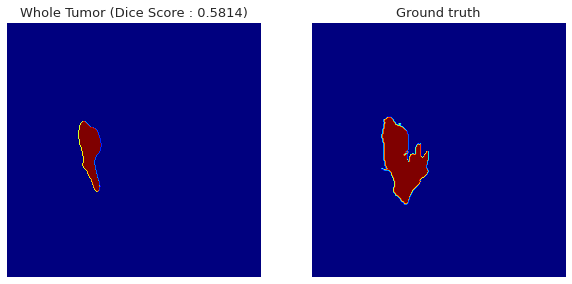

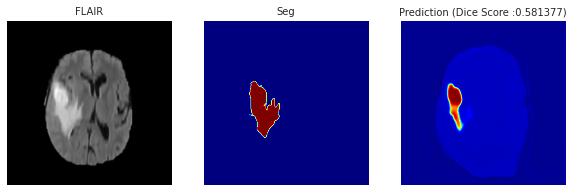

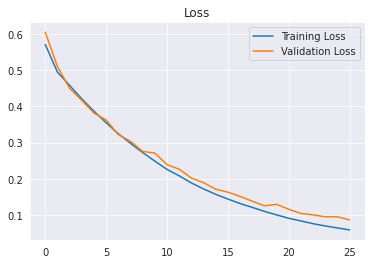

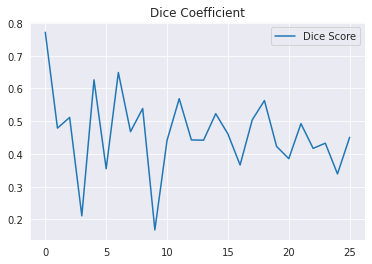

Training Epoch : [27/100]===============================================================================
Epoch: [27/100][0/20]	Time 0.710s (0.710s)	Speed 22.5 samples/s	Data 0.444s (0.444s)	Loss 0.05516 (0.05516)	
Epoch: [27/100][1/20]	Time 0.519s (0.614s)	Speed 30.8 samples/s	Data 0.351s (0.397s)	Loss 0.05631 (0.05573)	
Epoch: [27/100][2/20]	Time 0.531s (0.587s)	Speed 30.1 samples/s	Data 0.358s (0.384s)	Loss 0.05545 (0.05564)	
Epoch: [27/100][3/20]	Time 0.547s (0.577s)	Speed 29.2 samples/s	Data 0.380s (0.383s)	Loss 0.05437 (0.05532)	
Epoch: [27/100][4/20]	Time 0.517s (0.565s)	Speed 31.0 samples/s	Data 0.350s (0.377s)	Loss 0.05669 (0.05559)	
Epoch: [27/100][5/20]	Time 0.532s (0.559s)	Speed 30.1 samples/s	Data 0.365s (0.375s)	Loss 0.05529 (0.05554)	
Epoch: [27/100][6/20]	Time 0.542s (0.557s)	Speed 29.5 samples/s	Data 0.376s (0.375s)	Loss 0.05361 (0.05527)	
Epoch: [27/100][7/20]	Time 0.550s (0.556s)	Speed 29.1 samples/s	Data 0.383s (0.376s)	Loss 0.05365 (0.05506)	
Epoch: [27/100][8/20]	T

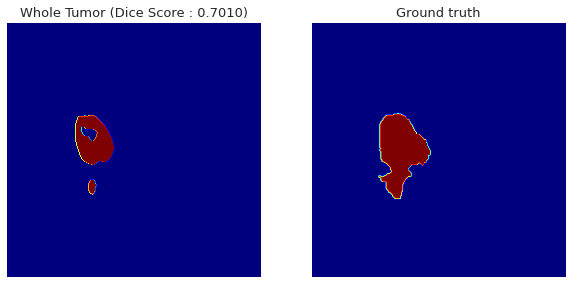

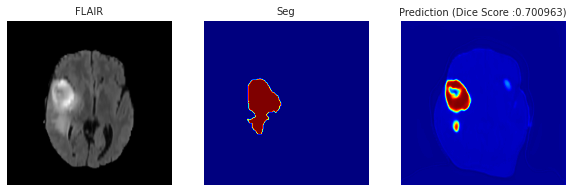

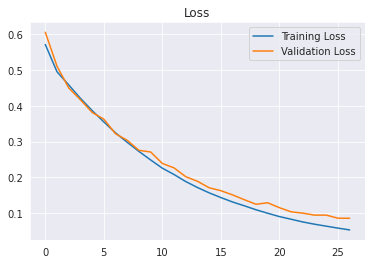

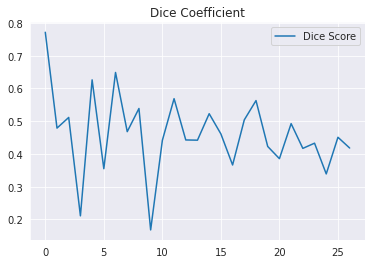

Training Epoch : [28/100]===============================================================================
Epoch: [28/100][0/20]	Time 0.641s (0.641s)	Speed 25.0 samples/s	Data 0.363s (0.363s)	Loss 0.05208 (0.05208)	
Epoch: [28/100][1/20]	Time 0.544s (0.593s)	Speed 29.4 samples/s	Data 0.378s (0.370s)	Loss 0.05200 (0.05204)	
Epoch: [28/100][2/20]	Time 0.541s (0.575s)	Speed 29.6 samples/s	Data 0.374s (0.372s)	Loss 0.05066 (0.05158)	
Epoch: [28/100][3/20]	Time 0.542s (0.567s)	Speed 29.5 samples/s	Data 0.374s (0.372s)	Loss 0.05016 (0.05123)	
Epoch: [28/100][4/20]	Time 0.524s (0.558s)	Speed 30.5 samples/s	Data 0.356s (0.369s)	Loss 0.05093 (0.05117)	
Epoch: [28/100][5/20]	Time 0.535s (0.554s)	Speed 29.9 samples/s	Data 0.363s (0.368s)	Loss 0.04954 (0.05090)	
Epoch: [28/100][6/20]	Time 0.538s (0.552s)	Speed 29.8 samples/s	Data 0.371s (0.368s)	Loss 0.05079 (0.05088)	
Epoch: [28/100][7/20]	Time 0.566s (0.554s)	Speed 28.3 samples/s	Data 0.401s (0.372s)	Loss 0.05000 (0.05077)	
Epoch: [28/100][8/20]	T

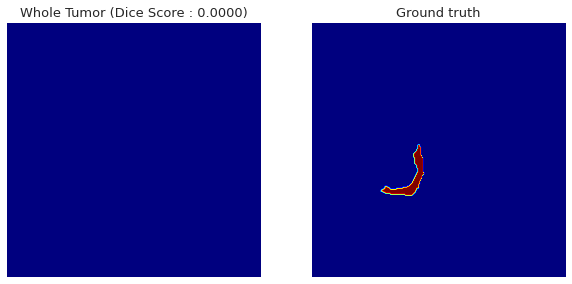

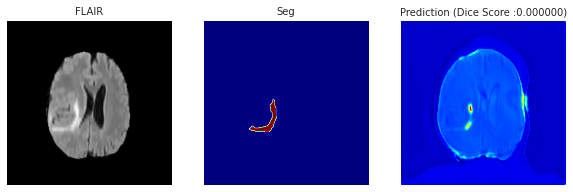

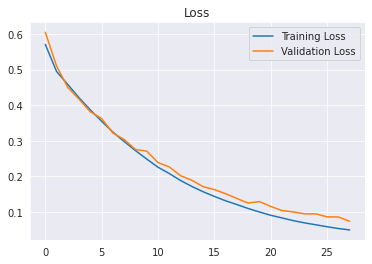

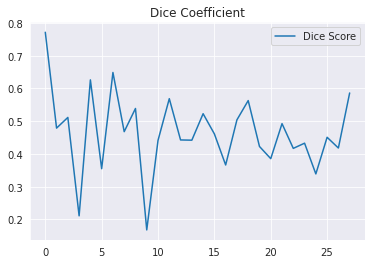

Training Epoch : [29/100]===============================================================================
Epoch: [29/100][0/20]	Time 0.667s (0.667s)	Speed 24.0 samples/s	Data 0.419s (0.419s)	Loss 0.04867 (0.04867)	
Epoch: [29/100][1/20]	Time 0.567s (0.617s)	Speed 28.2 samples/s	Data 0.390s (0.404s)	Loss 0.04777 (0.04822)	
Epoch: [29/100][2/20]	Time 0.555s (0.596s)	Speed 28.8 samples/s	Data 0.389s (0.399s)	Loss 0.04906 (0.04850)	
Epoch: [29/100][3/20]	Time 0.569s (0.589s)	Speed 28.1 samples/s	Data 0.401s (0.400s)	Loss 0.04661 (0.04803)	
Epoch: [29/100][4/20]	Time 0.517s (0.575s)	Speed 30.9 samples/s	Data 0.352s (0.390s)	Loss 0.04982 (0.04839)	
Epoch: [29/100][5/20]	Time 0.527s (0.567s)	Speed 30.3 samples/s	Data 0.361s (0.385s)	Loss 0.05083 (0.04879)	
Epoch: [29/100][6/20]	Time 0.544s (0.564s)	Speed 29.4 samples/s	Data 0.378s (0.384s)	Loss 0.04801 (0.04868)	
Epoch: [29/100][7/20]	Time 0.557s (0.563s)	Speed 28.7 samples/s	Data 0.389s (0.385s)	Loss 0.04907 (0.04873)	
Epoch: [29/100][8/20]	T

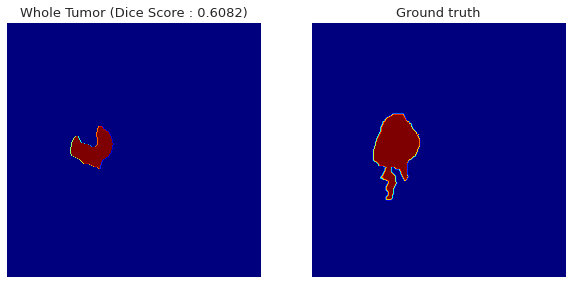

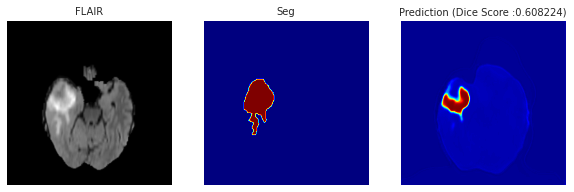

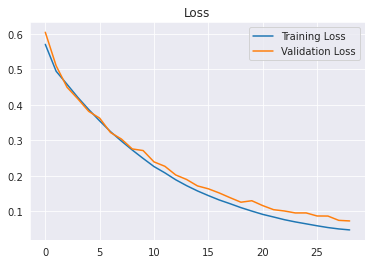

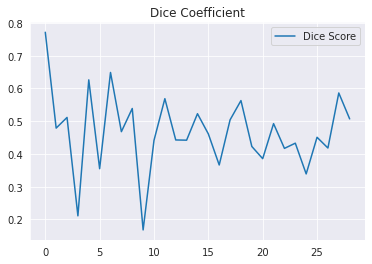

Training Epoch : [30/100]===============================================================================
Epoch: [30/100][0/20]	Time 0.682s (0.682s)	Speed 23.4 samples/s	Data 0.431s (0.431s)	Loss 0.04431 (0.04431)	
Epoch: [30/100][1/20]	Time 0.565s (0.624s)	Speed 28.3 samples/s	Data 0.397s (0.414s)	Loss 0.04371 (0.04401)	
Epoch: [30/100][2/20]	Time 0.571s (0.606s)	Speed 28.0 samples/s	Data 0.405s (0.411s)	Loss 0.04477 (0.04426)	
Epoch: [30/100][3/20]	Time 0.552s (0.593s)	Speed 29.0 samples/s	Data 0.386s (0.405s)	Loss 0.04651 (0.04482)	
Epoch: [30/100][4/20]	Time 0.545s (0.583s)	Speed 29.3 samples/s	Data 0.378s (0.400s)	Loss 0.04696 (0.04525)	
Epoch: [30/100][5/20]	Time 0.572s (0.581s)	Speed 28.0 samples/s	Data 0.405s (0.400s)	Loss 0.04397 (0.04504)	
Epoch: [30/100][6/20]	Time 0.540s (0.575s)	Speed 29.6 samples/s	Data 0.374s (0.397s)	Loss 0.04403 (0.04489)	
Epoch: [30/100][7/20]	Time 0.568s (0.574s)	Speed 28.2 samples/s	Data 0.401s (0.397s)	Loss 0.04342 (0.04471)	
Epoch: [30/100][8/20]	T

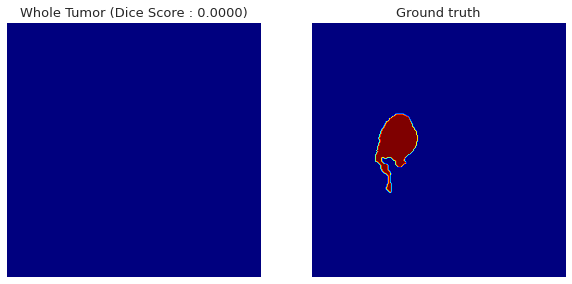

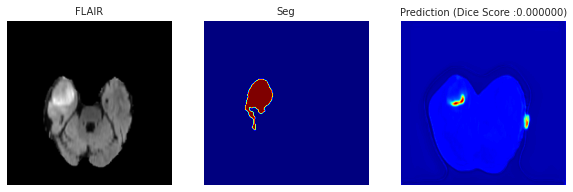

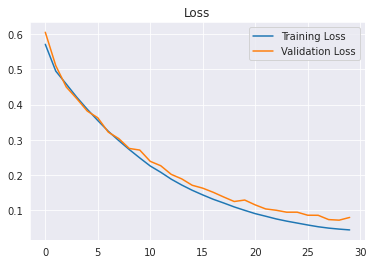

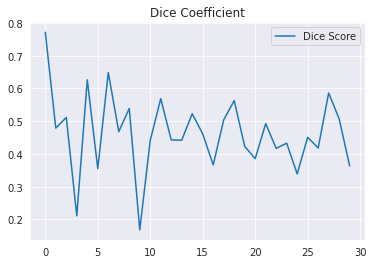

Training Epoch : [31/100]===============================================================================
Epoch: [31/100][0/20]	Time 0.686s (0.686s)	Speed 23.3 samples/s	Data 0.442s (0.442s)	Loss 0.04235 (0.04235)	
Epoch: [31/100][1/20]	Time 0.563s (0.625s)	Speed 28.4 samples/s	Data 0.389s (0.416s)	Loss 0.04557 (0.04396)	
Epoch: [31/100][2/20]	Time 0.560s (0.603s)	Speed 28.6 samples/s	Data 0.394s (0.409s)	Loss 0.04388 (0.04393)	
Epoch: [31/100][3/20]	Time 0.523s (0.583s)	Speed 30.6 samples/s	Data 0.357s (0.396s)	Loss 0.04914 (0.04524)	
Epoch: [31/100][4/20]	Time 0.546s (0.576s)	Speed 29.3 samples/s	Data 0.379s (0.392s)	Loss 0.04702 (0.04559)	
Epoch: [31/100][5/20]	Time 0.576s (0.576s)	Speed 27.8 samples/s	Data 0.410s (0.395s)	Loss 0.04372 (0.04528)	
Epoch: [31/100][6/20]	Time 0.562s (0.574s)	Speed 28.5 samples/s	Data 0.395s (0.395s)	Loss 0.04518 (0.04527)	
Epoch: [31/100][7/20]	Time 0.566s (0.573s)	Speed 28.3 samples/s	Data 0.399s (0.396s)	Loss 0.04141 (0.04478)	
Epoch: [31/100][8/20]	T

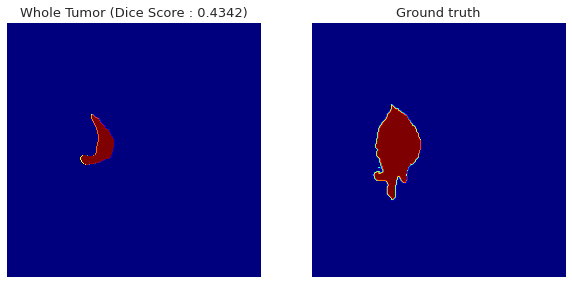

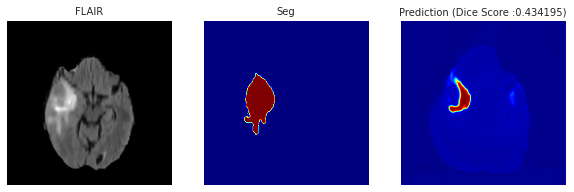

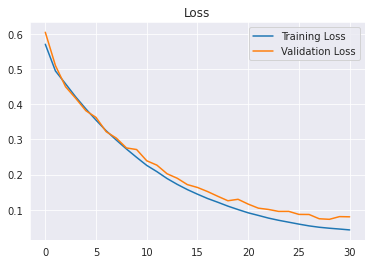

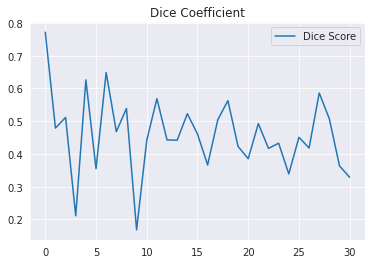

Training Epoch : [32/100]===============================================================================
Epoch: [32/100][0/20]	Time 0.643s (0.643s)	Speed 24.9 samples/s	Data 0.385s (0.385s)	Loss 0.03856 (0.03856)	
Epoch: [32/100][1/20]	Time 0.555s (0.599s)	Speed 28.8 samples/s	Data 0.387s (0.386s)	Loss 0.03884 (0.03870)	
Epoch: [32/100][2/20]	Time 0.570s (0.589s)	Speed 28.0 samples/s	Data 0.403s (0.392s)	Loss 0.03851 (0.03864)	
Epoch: [32/100][3/20]	Time 0.545s (0.578s)	Speed 29.3 samples/s	Data 0.378s (0.388s)	Loss 0.03873 (0.03866)	
Epoch: [32/100][4/20]	Time 0.571s (0.577s)	Speed 28.0 samples/s	Data 0.405s (0.391s)	Loss 0.03910 (0.03875)	
Epoch: [32/100][5/20]	Time 0.537s (0.570s)	Speed 29.8 samples/s	Data 0.370s (0.388s)	Loss 0.03765 (0.03857)	
Epoch: [32/100][6/20]	Time 0.550s (0.567s)	Speed 29.1 samples/s	Data 0.383s (0.387s)	Loss 0.03900 (0.03863)	
Epoch: [32/100][7/20]	Time 0.566s (0.567s)	Speed 28.3 samples/s	Data 0.399s (0.389s)	Loss 0.03802 (0.03855)	
Epoch: [32/100][8/20]	T

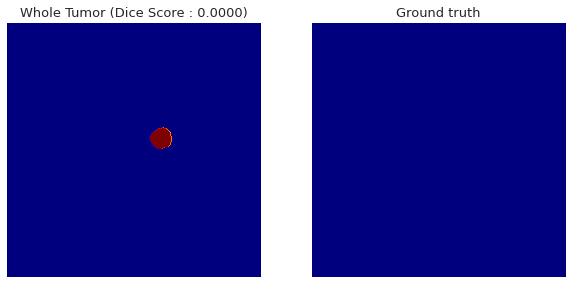

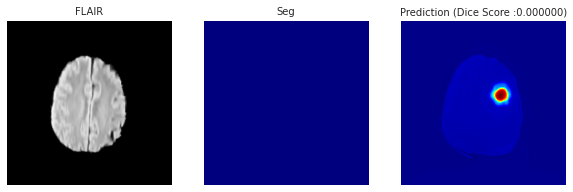

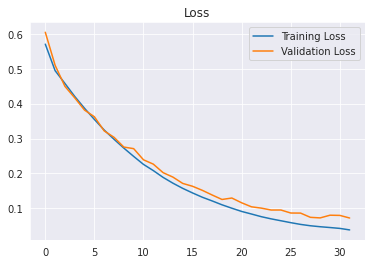

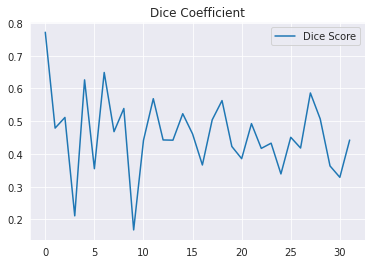

Training Epoch : [33/100]===============================================================================
Epoch: [33/100][0/20]	Time 0.637s (0.637s)	Speed 25.1 samples/s	Data 0.378s (0.378s)	Loss 0.03606 (0.03606)	
Epoch: [33/100][1/20]	Time 0.539s (0.588s)	Speed 29.7 samples/s	Data 0.371s (0.375s)	Loss 0.03625 (0.03615)	
Epoch: [33/100][2/20]	Time 0.559s (0.578s)	Speed 28.6 samples/s	Data 0.394s (0.381s)	Loss 0.03640 (0.03624)	
Epoch: [33/100][3/20]	Time 0.555s (0.573s)	Speed 28.8 samples/s	Data 0.388s (0.383s)	Loss 0.03549 (0.03605)	
Epoch: [33/100][4/20]	Time 0.505s (0.559s)	Speed 31.7 samples/s	Data 0.340s (0.374s)	Loss 0.03706 (0.03625)	
Epoch: [33/100][5/20]	Time 0.533s (0.555s)	Speed 30.0 samples/s	Data 0.365s (0.373s)	Loss 0.03554 (0.03613)	
Epoch: [33/100][6/20]	Time 0.538s (0.552s)	Speed 29.7 samples/s	Data 0.372s (0.373s)	Loss 0.03708 (0.03627)	
Epoch: [33/100][7/20]	Time 0.553s (0.552s)	Speed 28.9 samples/s	Data 0.386s (0.374s)	Loss 0.03721 (0.03639)	
Epoch: [33/100][8/20]	T

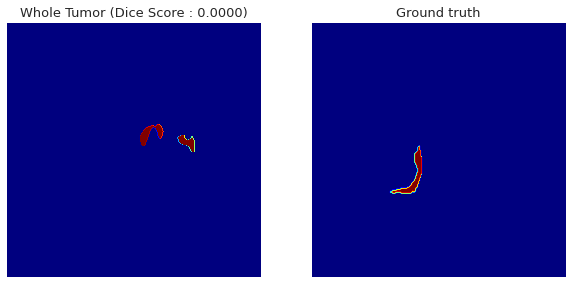

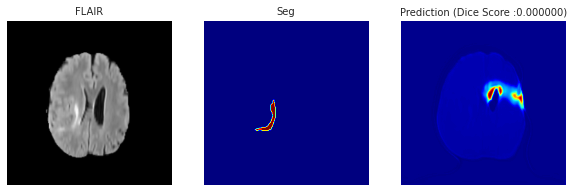

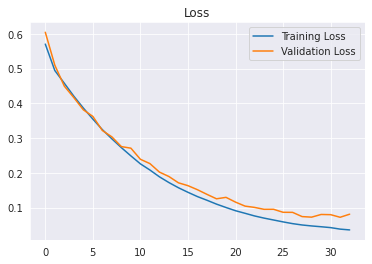

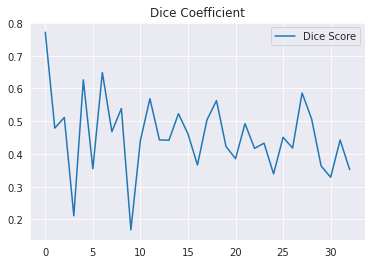

Training Epoch : [34/100]===============================================================================
Epoch: [34/100][0/20]	Time 0.589s (0.589s)	Speed 27.1 samples/s	Data 0.343s (0.343s)	Loss 0.03310 (0.03310)	
Epoch: [34/100][1/20]	Time 0.514s (0.552s)	Speed 31.2 samples/s	Data 0.340s (0.341s)	Loss 0.03287 (0.03299)	
Epoch: [34/100][2/20]	Time 0.527s (0.543s)	Speed 30.4 samples/s	Data 0.360s (0.348s)	Loss 0.03362 (0.03320)	
Epoch: [34/100][3/20]	Time 0.522s (0.538s)	Speed 30.7 samples/s	Data 0.356s (0.350s)	Loss 0.03601 (0.03390)	
Epoch: [34/100][4/20]	Time 0.562s (0.543s)	Speed 28.5 samples/s	Data 0.394s (0.359s)	Loss 0.03338 (0.03380)	
Epoch: [34/100][5/20]	Time 0.540s (0.542s)	Speed 29.6 samples/s	Data 0.374s (0.361s)	Loss 0.03272 (0.03362)	
Epoch: [34/100][6/20]	Time 0.550s (0.543s)	Speed 29.1 samples/s	Data 0.383s (0.364s)	Loss 0.03438 (0.03373)	
Epoch: [34/100][7/20]	Time 0.580s (0.548s)	Speed 27.6 samples/s	Data 0.413s (0.370s)	Loss 0.03298 (0.03363)	
Epoch: [34/100][8/20]	T

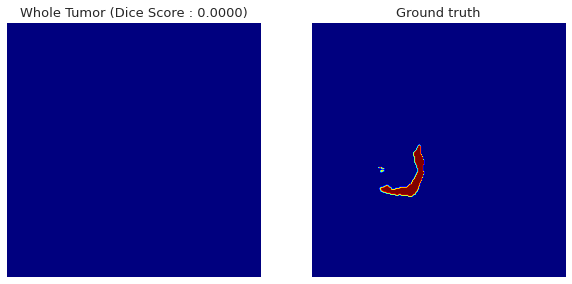

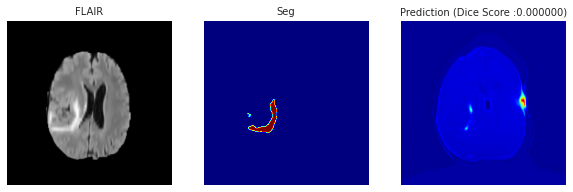

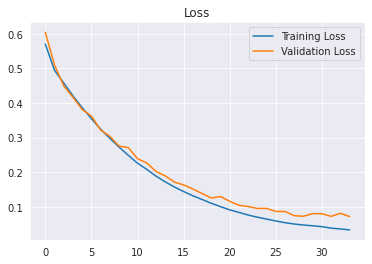

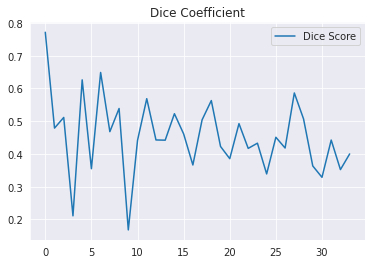

Training Epoch : [35/100]===============================================================================
Epoch: [35/100][0/20]	Time 0.677s (0.677s)	Speed 23.6 samples/s	Data 0.427s (0.427s)	Loss 0.03082 (0.03082)	
Epoch: [35/100][1/20]	Time 0.562s (0.620s)	Speed 28.5 samples/s	Data 0.392s (0.409s)	Loss 0.03087 (0.03085)	
Epoch: [35/100][2/20]	Time 0.516s (0.585s)	Speed 31.0 samples/s	Data 0.349s (0.389s)	Loss 0.03142 (0.03104)	
Epoch: [35/100][3/20]	Time 0.570s (0.581s)	Speed 28.1 samples/s	Data 0.403s (0.393s)	Loss 0.03084 (0.03099)	
Epoch: [35/100][4/20]	Time 0.578s (0.581s)	Speed 27.7 samples/s	Data 0.410s (0.396s)	Loss 0.03158 (0.03111)	
Epoch: [35/100][5/20]	Time 0.541s (0.574s)	Speed 29.6 samples/s	Data 0.375s (0.393s)	Loss 0.03126 (0.03113)	
Epoch: [35/100][6/20]	Time 0.531s (0.568s)	Speed 30.1 samples/s	Data 0.363s (0.389s)	Loss 0.03465 (0.03164)	
Epoch: [35/100][7/20]	Time 0.559s (0.567s)	Speed 28.6 samples/s	Data 0.391s (0.389s)	Loss 0.03076 (0.03153)	
Epoch: [35/100][8/20]	T

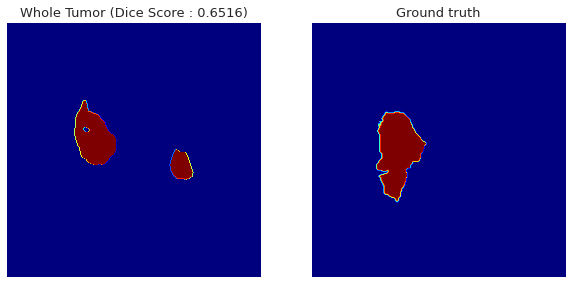

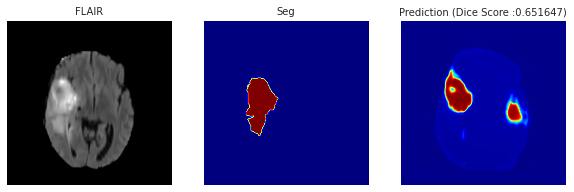

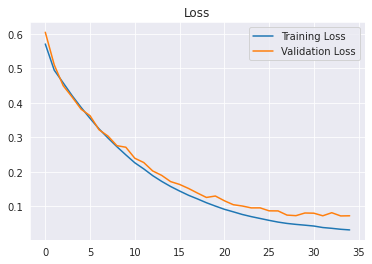

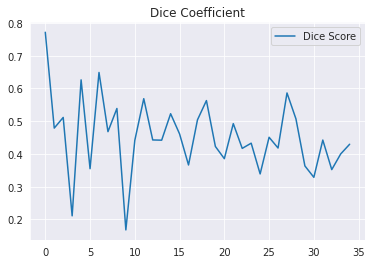

Training Epoch : [36/100]===============================================================================
Epoch: [36/100][0/20]	Time 0.666s (0.666s)	Speed 24.0 samples/s	Data 0.410s (0.410s)	Loss 0.03090 (0.03090)	
Epoch: [36/100][1/20]	Time 0.567s (0.616s)	Speed 28.2 samples/s	Data 0.398s (0.404s)	Loss 0.02847 (0.02968)	
Epoch: [36/100][2/20]	Time 0.534s (0.589s)	Speed 30.0 samples/s	Data 0.366s (0.392s)	Loss 0.02966 (0.02968)	
Epoch: [36/100][3/20]	Time 0.543s (0.577s)	Speed 29.5 samples/s	Data 0.377s (0.388s)	Loss 0.02913 (0.02954)	
Epoch: [36/100][4/20]	Time 0.547s (0.571s)	Speed 29.3 samples/s	Data 0.380s (0.387s)	Loss 0.02868 (0.02937)	
Epoch: [36/100][5/20]	Time 0.560s (0.569s)	Speed 28.6 samples/s	Data 0.393s (0.388s)	Loss 0.02989 (0.02945)	
Epoch: [36/100][6/20]	Time 0.547s (0.566s)	Speed 29.2 samples/s	Data 0.380s (0.387s)	Loss 0.02918 (0.02942)	
Epoch: [36/100][7/20]	Time 0.560s (0.565s)	Speed 28.6 samples/s	Data 0.392s (0.387s)	Loss 0.02971 (0.02945)	
Epoch: [36/100][8/20]	T

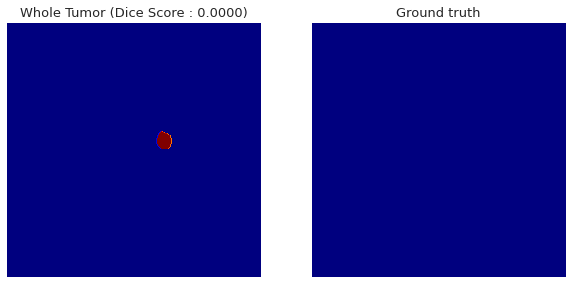

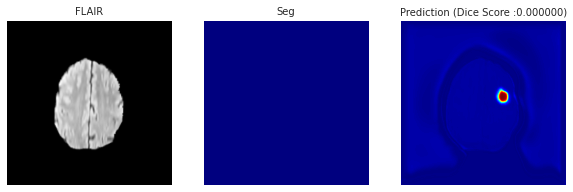

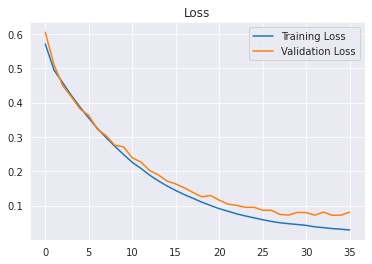

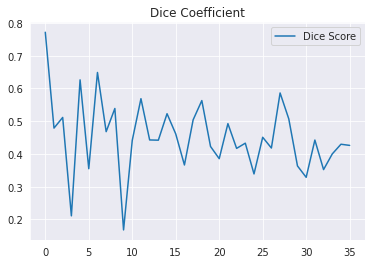

Training Epoch : [37/100]===============================================================================
Epoch: [37/100][0/20]	Time 0.635s (0.635s)	Speed 25.2 samples/s	Data 0.387s (0.387s)	Loss 0.02782 (0.02782)	
Epoch: [37/100][1/20]	Time 0.523s (0.579s)	Speed 30.6 samples/s	Data 0.355s (0.371s)	Loss 0.02757 (0.02769)	
Epoch: [37/100][2/20]	Time 0.532s (0.563s)	Speed 30.1 samples/s	Data 0.366s (0.369s)	Loss 0.02707 (0.02749)	
Epoch: [37/100][3/20]	Time 0.501s (0.548s)	Speed 32.0 samples/s	Data 0.334s (0.360s)	Loss 0.02665 (0.02728)	
Epoch: [37/100][4/20]	Time 0.532s (0.545s)	Speed 30.1 samples/s	Data 0.365s (0.361s)	Loss 0.02925 (0.02767)	
Epoch: [37/100][5/20]	Time 0.530s (0.542s)	Speed 30.2 samples/s	Data 0.363s (0.361s)	Loss 0.02727 (0.02761)	
Epoch: [37/100][6/20]	Time 0.541s (0.542s)	Speed 29.6 samples/s	Data 0.373s (0.363s)	Loss 0.02706 (0.02753)	
Epoch: [37/100][7/20]	Time 0.543s (0.542s)	Speed 29.5 samples/s	Data 0.376s (0.365s)	Loss 0.02744 (0.02752)	
Epoch: [37/100][8/20]	T

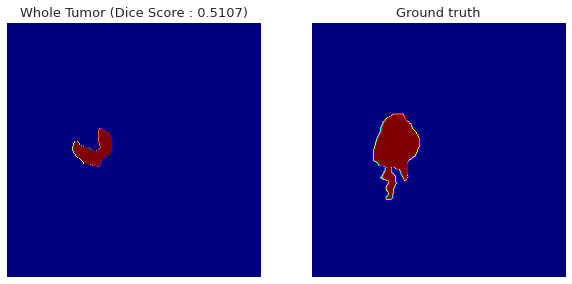

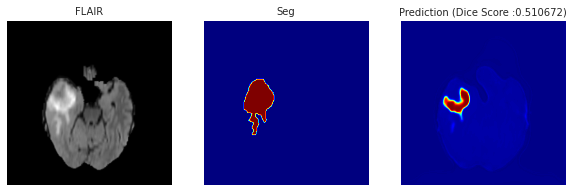

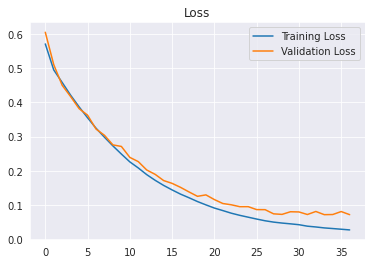

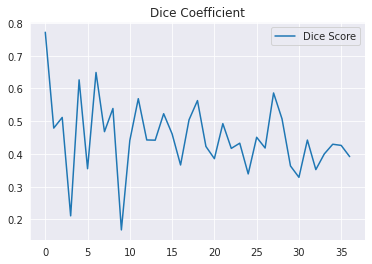

Training Epoch : [38/100]===============================================================================
Epoch: [38/100][0/20]	Time 0.665s (0.665s)	Speed 24.0 samples/s	Data 0.420s (0.420s)	Loss 0.02632 (0.02632)	
Epoch: [38/100][1/20]	Time 0.525s (0.595s)	Speed 30.5 samples/s	Data 0.353s (0.386s)	Loss 0.02495 (0.02563)	
Epoch: [38/100][2/20]	Time 0.537s (0.576s)	Speed 29.8 samples/s	Data 0.371s (0.381s)	Loss 0.02512 (0.02546)	
Epoch: [38/100][3/20]	Time 0.541s (0.567s)	Speed 29.6 samples/s	Data 0.374s (0.379s)	Loss 0.02678 (0.02579)	
Epoch: [38/100][4/20]	Time 0.604s (0.574s)	Speed 26.5 samples/s	Data 0.437s (0.391s)	Loss 0.02503 (0.02564)	
Epoch: [38/100][5/20]	Time 0.571s (0.574s)	Speed 28.0 samples/s	Data 0.404s (0.393s)	Loss 0.02673 (0.02582)	
Epoch: [38/100][6/20]	Time 0.558s (0.572s)	Speed 28.6 samples/s	Data 0.392s (0.393s)	Loss 0.02512 (0.02572)	
Epoch: [38/100][7/20]	Time 0.540s (0.568s)	Speed 29.7 samples/s	Data 0.373s (0.390s)	Loss 0.02540 (0.02568)	
Epoch: [38/100][8/20]	T

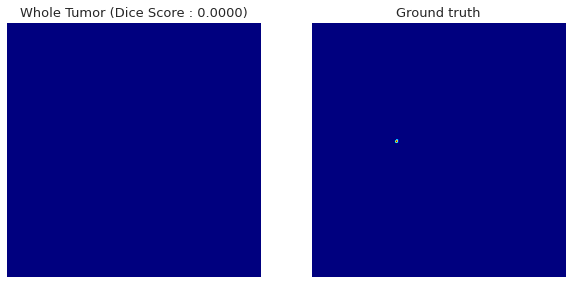

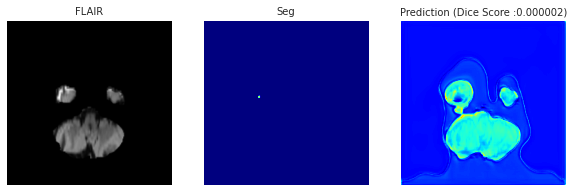

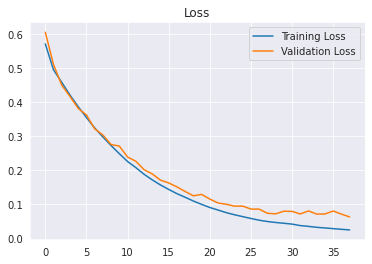

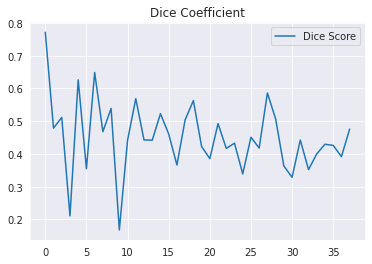

Training Epoch : [39/100]===============================================================================
Epoch: [39/100][0/20]	Time 0.663s (0.663s)	Speed 24.1 samples/s	Data 0.413s (0.413s)	Loss 0.02730 (0.02730)	
Epoch: [39/100][1/20]	Time 0.546s (0.604s)	Speed 29.3 samples/s	Data 0.370s (0.391s)	Loss 0.02537 (0.02633)	
Epoch: [39/100][2/20]	Time 0.558s (0.589s)	Speed 28.7 samples/s	Data 0.390s (0.391s)	Loss 0.02351 (0.02539)	
Epoch: [39/100][3/20]	Time 0.536s (0.576s)	Speed 29.8 samples/s	Data 0.371s (0.386s)	Loss 0.02412 (0.02507)	
Epoch: [39/100][4/20]	Time 0.551s (0.571s)	Speed 29.0 samples/s	Data 0.384s (0.386s)	Loss 0.02476 (0.02501)	
Epoch: [39/100][5/20]	Time 0.578s (0.572s)	Speed 27.7 samples/s	Data 0.410s (0.390s)	Loss 0.02340 (0.02474)	
Epoch: [39/100][6/20]	Time 0.542s (0.568s)	Speed 29.5 samples/s	Data 0.374s (0.387s)	Loss 0.02388 (0.02462)	
Epoch: [39/100][7/20]	Time 0.590s (0.570s)	Speed 27.1 samples/s	Data 0.424s (0.392s)	Loss 0.02312 (0.02443)	
Epoch: [39/100][8/20]	T

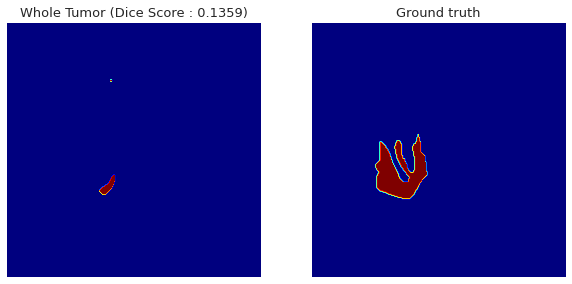

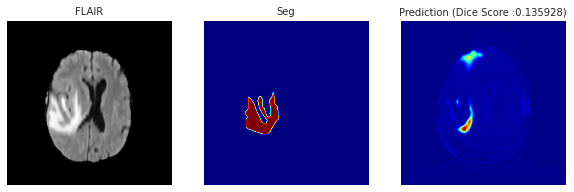

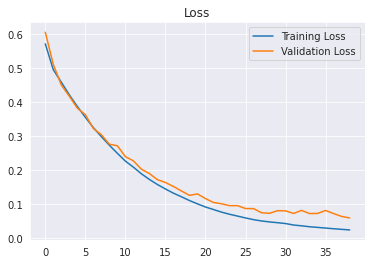

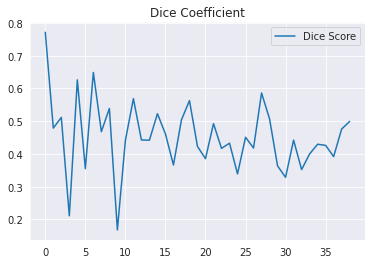

Training Epoch : [40/100]===============================================================================
Epoch: [40/100][0/20]	Time 0.705s (0.705s)	Speed 22.7 samples/s	Data 0.431s (0.431s)	Loss 0.02351 (0.02351)	
Epoch: [40/100][1/20]	Time 0.553s (0.629s)	Speed 28.9 samples/s	Data 0.386s (0.409s)	Loss 0.02161 (0.02256)	
Epoch: [40/100][2/20]	Time 0.570s (0.609s)	Speed 28.1 samples/s	Data 0.404s (0.407s)	Loss 0.02290 (0.02267)	
Epoch: [40/100][3/20]	Time 0.546s (0.594s)	Speed 29.3 samples/s	Data 0.381s (0.401s)	Loss 0.02226 (0.02257)	
Epoch: [40/100][4/20]	Time 0.530s (0.581s)	Speed 30.2 samples/s	Data 0.362s (0.393s)	Loss 0.02239 (0.02254)	
Epoch: [40/100][5/20]	Time 0.573s (0.580s)	Speed 27.9 samples/s	Data 0.408s (0.395s)	Loss 0.02158 (0.02238)	
Epoch: [40/100][6/20]	Time 0.532s (0.573s)	Speed 30.1 samples/s	Data 0.366s (0.391s)	Loss 0.02244 (0.02238)	
Epoch: [40/100][7/20]	Time 0.524s (0.567s)	Speed 30.5 samples/s	Data 0.357s (0.387s)	Loss 0.02414 (0.02260)	
Epoch: [40/100][8/20]	T

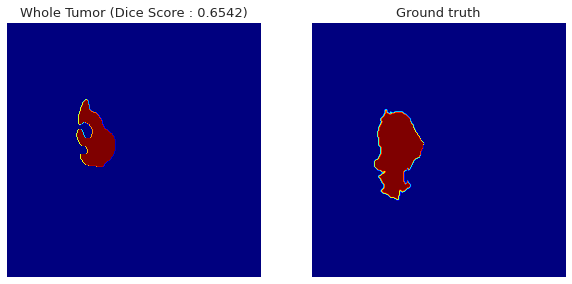

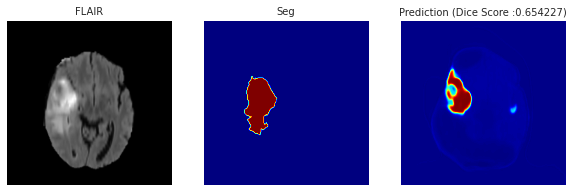

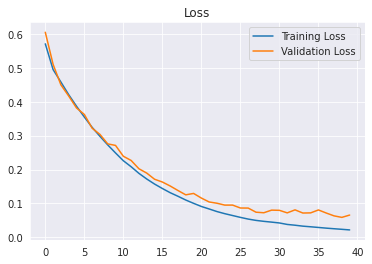

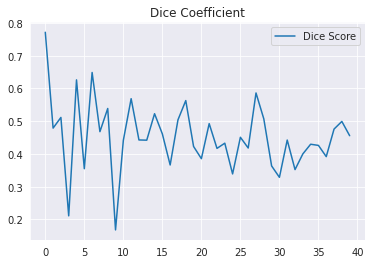

Training Epoch : [41/100]===============================================================================
Epoch: [41/100][0/20]	Time 0.698s (0.698s)	Speed 22.9 samples/s	Data 0.440s (0.440s)	Loss 0.02043 (0.02043)	
Epoch: [41/100][1/20]	Time 0.565s (0.631s)	Speed 28.3 samples/s	Data 0.397s (0.419s)	Loss 0.02091 (0.02067)	
Epoch: [41/100][2/20]	Time 0.550s (0.604s)	Speed 29.1 samples/s	Data 0.384s (0.407s)	Loss 0.02166 (0.02100)	
Epoch: [41/100][3/20]	Time 0.564s (0.594s)	Speed 28.4 samples/s	Data 0.398s (0.405s)	Loss 0.02094 (0.02098)	
Epoch: [41/100][4/20]	Time 0.529s (0.581s)	Speed 30.2 samples/s	Data 0.363s (0.396s)	Loss 0.02066 (0.02092)	
Epoch: [41/100][5/20]	Time 0.560s (0.578s)	Speed 28.6 samples/s	Data 0.392s (0.396s)	Loss 0.02087 (0.02091)	
Epoch: [41/100][6/20]	Time 0.555s (0.575s)	Speed 28.8 samples/s	Data 0.389s (0.395s)	Loss 0.02093 (0.02091)	
Epoch: [41/100][7/20]	Time 0.562s (0.573s)	Speed 28.4 samples/s	Data 0.397s (0.395s)	Loss 0.01963 (0.02075)	
Epoch: [41/100][8/20]	T

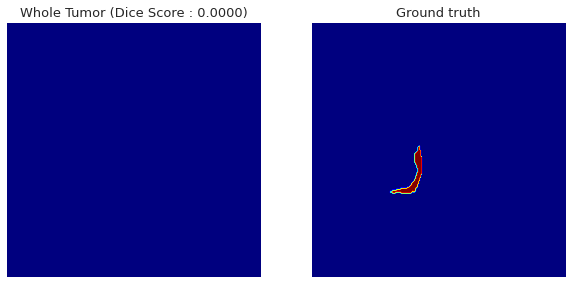

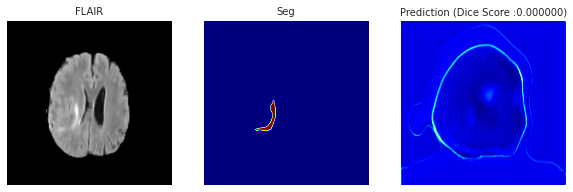

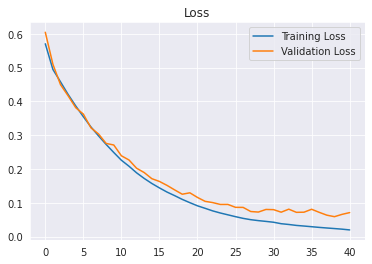

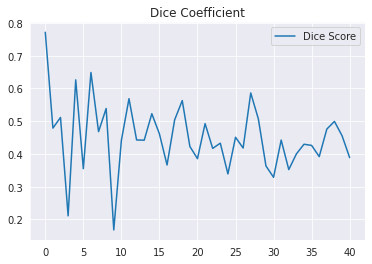

Training Epoch : [42/100]===============================================================================
Epoch: [42/100][0/20]	Time 0.681s (0.681s)	Speed 23.5 samples/s	Data 0.432s (0.432s)	Loss 0.01743 (0.01743)	
Epoch: [42/100][1/20]	Time 0.522s (0.601s)	Speed 30.6 samples/s	Data 0.355s (0.393s)	Loss 0.02275 (0.02009)	
Epoch: [42/100][2/20]	Time 0.547s (0.583s)	Speed 29.3 samples/s	Data 0.379s (0.389s)	Loss 0.01634 (0.01884)	
Epoch: [42/100][3/20]	Time 0.527s (0.569s)	Speed 30.4 samples/s	Data 0.360s (0.382s)	Loss 0.01681 (0.01833)	
Epoch: [42/100][4/20]	Time 0.536s (0.563s)	Speed 29.8 samples/s	Data 0.369s (0.379s)	Loss 0.01940 (0.01854)	
Epoch: [42/100][5/20]	Time 0.580s (0.565s)	Speed 27.6 samples/s	Data 0.412s (0.385s)	Loss 0.02217 (0.01915)	
Epoch: [42/100][6/20]	Time 0.565s (0.565s)	Speed 28.3 samples/s	Data 0.397s (0.386s)	Loss 0.01759 (0.01892)	
Epoch: [42/100][7/20]	Time 0.543s (0.562s)	Speed 29.5 samples/s	Data 0.376s (0.385s)	Loss 0.01687 (0.01867)	
Epoch: [42/100][8/20]	T

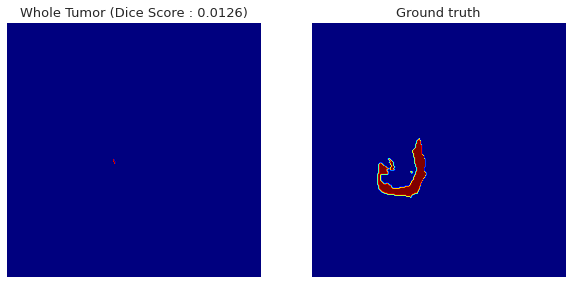

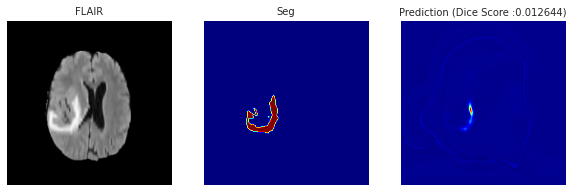

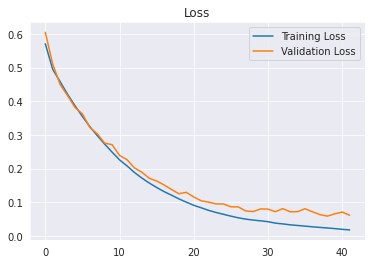

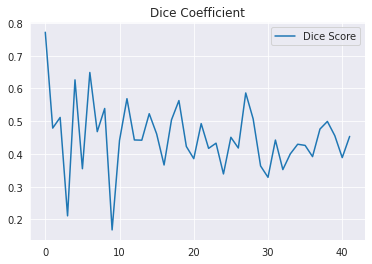

Training Epoch : [43/100]===============================================================================
Epoch: [43/100][0/20]	Time 0.626s (0.626s)	Speed 25.6 samples/s	Data 0.378s (0.378s)	Loss 0.01613 (0.01613)	
Epoch: [43/100][1/20]	Time 0.545s (0.586s)	Speed 29.3 samples/s	Data 0.373s (0.375s)	Loss 0.01882 (0.01748)	
Epoch: [43/100][2/20]	Time 0.562s (0.578s)	Speed 28.5 samples/s	Data 0.396s (0.382s)	Loss 0.01636 (0.01711)	
Epoch: [43/100][3/20]	Time 0.564s (0.574s)	Speed 28.4 samples/s	Data 0.398s (0.386s)	Loss 0.01843 (0.01744)	
Epoch: [43/100][4/20]	Time 0.562s (0.572s)	Speed 28.5 samples/s	Data 0.395s (0.388s)	Loss 0.01683 (0.01731)	
Epoch: [43/100][5/20]	Time 0.544s (0.567s)	Speed 29.4 samples/s	Data 0.377s (0.386s)	Loss 0.01581 (0.01706)	
Epoch: [43/100][6/20]	Time 0.536s (0.563s)	Speed 29.9 samples/s	Data 0.368s (0.384s)	Loss 0.01763 (0.01714)	
Epoch: [43/100][7/20]	Time 0.561s (0.562s)	Speed 28.5 samples/s	Data 0.395s (0.385s)	Loss 0.01596 (0.01700)	
Epoch: [43/100][8/20]	T

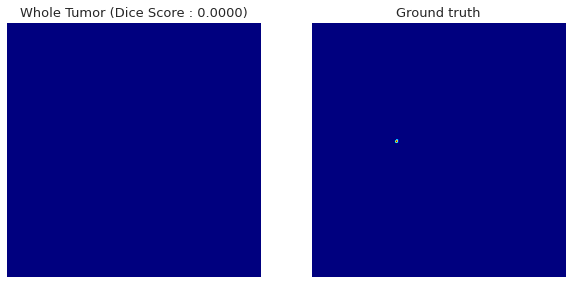

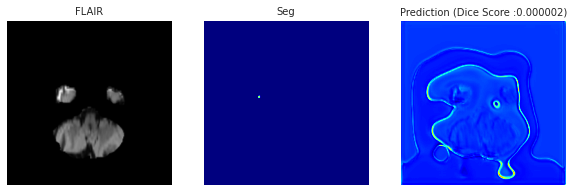

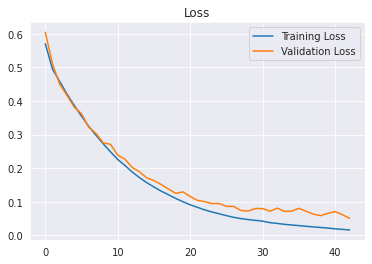

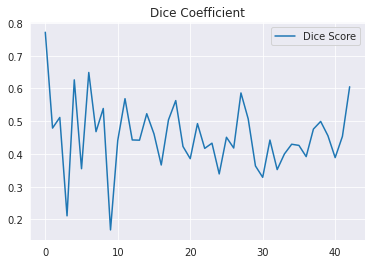

Training Epoch : [44/100]===============================================================================
Epoch: [44/100][0/20]	Time 0.683s (0.683s)	Speed 23.4 samples/s	Data 0.396s (0.396s)	Loss 0.01559 (0.01559)	
Epoch: [44/100][1/20]	Time 0.553s (0.618s)	Speed 28.9 samples/s	Data 0.385s (0.390s)	Loss 0.01436 (0.01498)	
Epoch: [44/100][2/20]	Time 0.532s (0.589s)	Speed 30.1 samples/s	Data 0.365s (0.382s)	Loss 0.01473 (0.01489)	
Epoch: [44/100][3/20]	Time 0.546s (0.579s)	Speed 29.3 samples/s	Data 0.380s (0.382s)	Loss 0.01527 (0.01499)	
Epoch: [44/100][4/20]	Time 0.539s (0.571s)	Speed 29.7 samples/s	Data 0.368s (0.379s)	Loss 0.01678 (0.01535)	
Epoch: [44/100][5/20]	Time 0.562s (0.569s)	Speed 28.5 samples/s	Data 0.395s (0.381s)	Loss 0.01627 (0.01550)	
Epoch: [44/100][6/20]	Time 0.539s (0.565s)	Speed 29.7 samples/s	Data 0.372s (0.380s)	Loss 0.01680 (0.01569)	
Epoch: [44/100][7/20]	Time 0.560s (0.564s)	Speed 28.6 samples/s	Data 0.394s (0.382s)	Loss 0.01583 (0.01570)	
Epoch: [44/100][8/20]	T

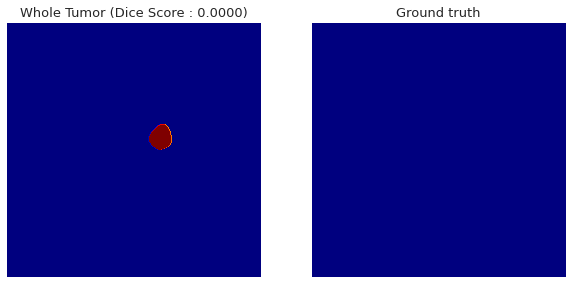

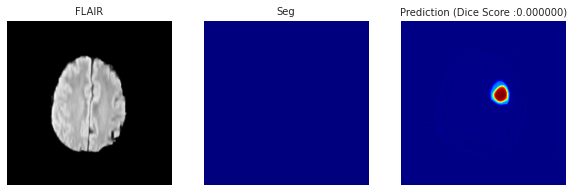

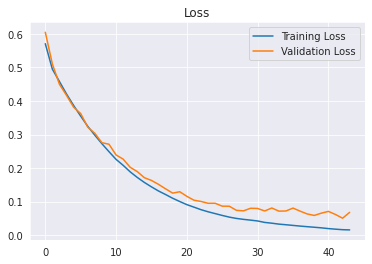

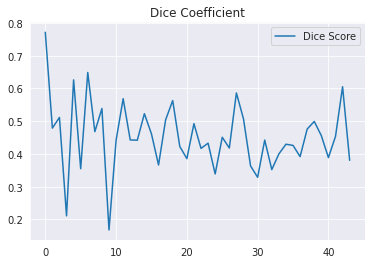

Training Epoch : [45/100]===============================================================================
Epoch: [45/100][0/20]	Time 0.686s (0.686s)	Speed 23.3 samples/s	Data 0.413s (0.413s)	Loss 0.01531 (0.01531)	
Epoch: [45/100][1/20]	Time 0.575s (0.631s)	Speed 27.8 samples/s	Data 0.402s (0.407s)	Loss 0.01537 (0.01534)	
Epoch: [45/100][2/20]	Time 0.536s (0.599s)	Speed 29.8 samples/s	Data 0.371s (0.395s)	Loss 0.01332 (0.01467)	
Epoch: [45/100][3/20]	Time 0.538s (0.584s)	Speed 29.8 samples/s	Data 0.371s (0.389s)	Loss 0.01581 (0.01495)	
Epoch: [45/100][4/20]	Time 0.514s (0.570s)	Speed 31.1 samples/s	Data 0.348s (0.381s)	Loss 0.01414 (0.01479)	
Epoch: [45/100][5/20]	Time 0.542s (0.565s)	Speed 29.5 samples/s	Data 0.375s (0.380s)	Loss 0.01539 (0.01489)	
Epoch: [45/100][6/20]	Time 0.583s (0.568s)	Speed 27.5 samples/s	Data 0.417s (0.385s)	Loss 0.01554 (0.01498)	
Epoch: [45/100][7/20]	Time 0.567s (0.568s)	Speed 28.2 samples/s	Data 0.401s (0.387s)	Loss 0.01554 (0.01505)	
Epoch: [45/100][8/20]	T

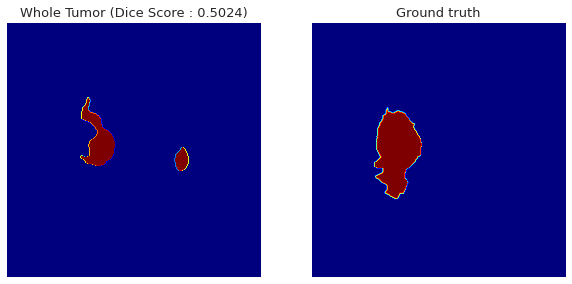

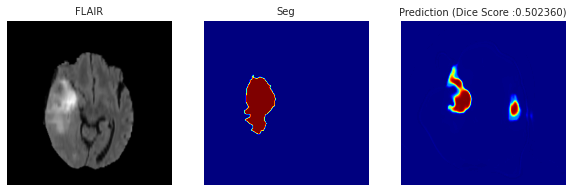

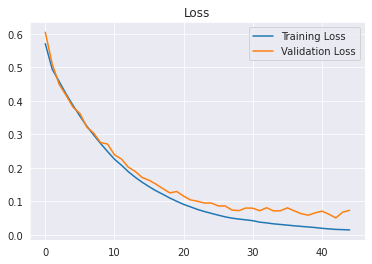

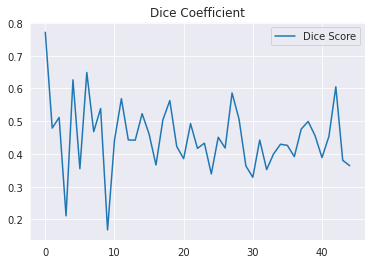

Training Epoch : [46/100]===============================================================================
Epoch: [46/100][0/20]	Time 0.674s (0.674s)	Speed 23.7 samples/s	Data 0.386s (0.386s)	Loss 0.01358 (0.01358)	
Epoch: [46/100][1/20]	Time 0.580s (0.627s)	Speed 27.6 samples/s	Data 0.414s (0.400s)	Loss 0.01352 (0.01355)	
Epoch: [46/100][2/20]	Time 0.581s (0.612s)	Speed 27.5 samples/s	Data 0.414s (0.404s)	Loss 0.01410 (0.01373)	
Epoch: [46/100][3/20]	Time 0.592s (0.607s)	Speed 27.0 samples/s	Data 0.426s (0.410s)	Loss 0.01609 (0.01432)	
Epoch: [46/100][4/20]	Time 0.574s (0.600s)	Speed 27.9 samples/s	Data 0.405s (0.409s)	Loss 0.01433 (0.01432)	
Epoch: [46/100][5/20]	Time 0.580s (0.597s)	Speed 27.6 samples/s	Data 0.412s (0.410s)	Loss 0.01442 (0.01434)	
Epoch: [46/100][6/20]	Time 0.596s (0.597s)	Speed 26.9 samples/s	Data 0.424s (0.412s)	Loss 0.01453 (0.01437)	
Epoch: [46/100][7/20]	Time 0.519s (0.587s)	Speed 30.8 samples/s	Data 0.351s (0.404s)	Loss 0.01506 (0.01445)	
Epoch: [46/100][8/20]	T

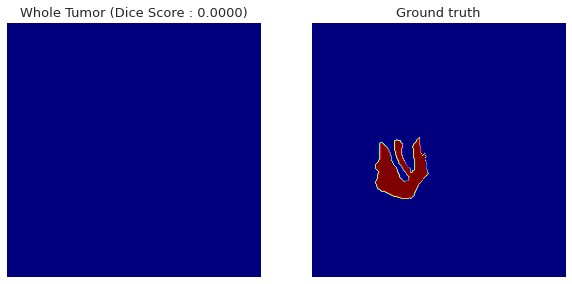

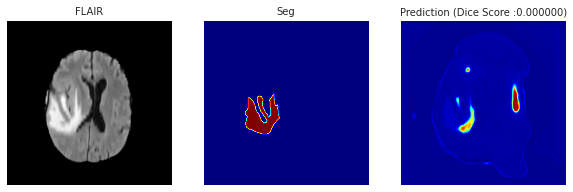

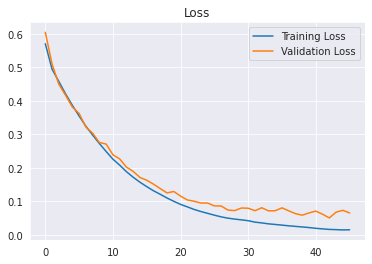

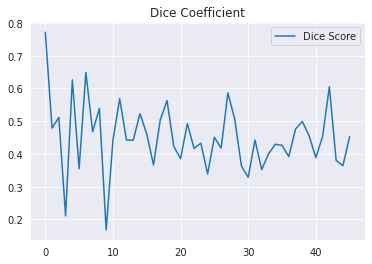

Training Epoch : [47/100]===============================================================================
Epoch: [47/100][0/20]	Time 0.649s (0.649s)	Speed 24.7 samples/s	Data 0.365s (0.365s)	Loss 0.01406 (0.01406)	
Epoch: [47/100][1/20]	Time 0.581s (0.615s)	Speed 27.5 samples/s	Data 0.413s (0.389s)	Loss 0.01808 (0.01607)	
Epoch: [47/100][2/20]	Time 0.529s (0.586s)	Speed 30.3 samples/s	Data 0.362s (0.380s)	Loss 0.02718 (0.01977)	
Epoch: [47/100][3/20]	Time 0.526s (0.571s)	Speed 30.4 samples/s	Data 0.359s (0.375s)	Loss 0.02079 (0.02003)	
Epoch: [47/100][4/20]	Time 0.544s (0.566s)	Speed 29.4 samples/s	Data 0.379s (0.376s)	Loss 0.01856 (0.01973)	
Epoch: [47/100][5/20]	Time 0.563s (0.565s)	Speed 28.4 samples/s	Data 0.394s (0.379s)	Loss 0.01563 (0.01905)	
Epoch: [47/100][6/20]	Time 0.541s (0.562s)	Speed 29.6 samples/s	Data 0.374s (0.378s)	Loss 0.02396 (0.01975)	
Epoch: [47/100][7/20]	Time 0.552s (0.561s)	Speed 29.0 samples/s	Data 0.386s (0.379s)	Loss 0.01759 (0.01948)	
Epoch: [47/100][8/20]	T

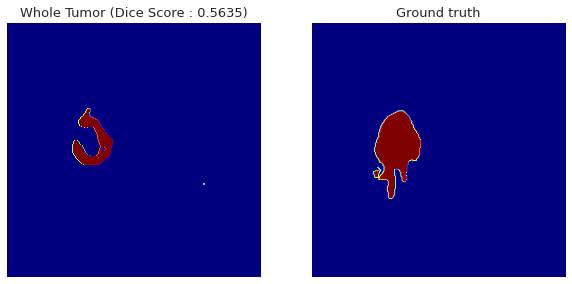

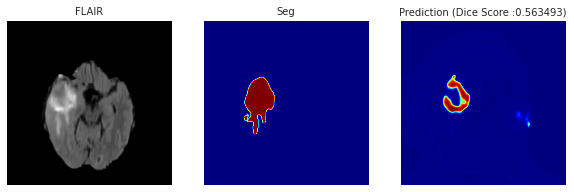

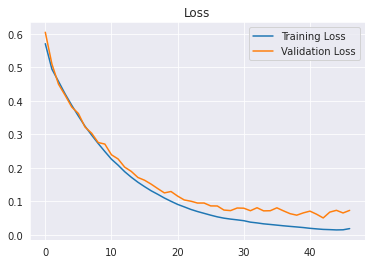

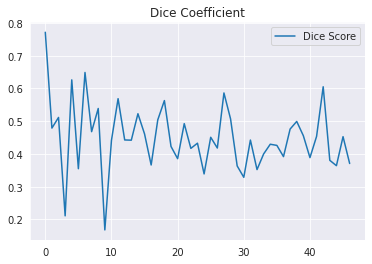

Training Epoch : [48/100]===============================================================================
Epoch: [48/100][0/20]	Time 0.625s (0.625s)	Speed 25.6 samples/s	Data 0.373s (0.373s)	Loss 0.01308 (0.01308)	
Epoch: [48/100][1/20]	Time 0.537s (0.581s)	Speed 29.8 samples/s	Data 0.368s (0.371s)	Loss 0.01883 (0.01595)	
Epoch: [48/100][2/20]	Time 0.538s (0.567s)	Speed 29.8 samples/s	Data 0.370s (0.371s)	Loss 0.01444 (0.01545)	
Epoch: [48/100][3/20]	Time 0.538s (0.559s)	Speed 29.7 samples/s	Data 0.372s (0.371s)	Loss 0.01485 (0.01530)	
Epoch: [48/100][4/20]	Time 0.536s (0.555s)	Speed 29.9 samples/s	Data 0.367s (0.370s)	Loss 0.02072 (0.01638)	
Epoch: [48/100][5/20]	Time 0.584s (0.560s)	Speed 27.4 samples/s	Data 0.416s (0.378s)	Loss 0.01559 (0.01625)	
Epoch: [48/100][6/20]	Time 0.541s (0.557s)	Speed 29.6 samples/s	Data 0.374s (0.377s)	Loss 0.01652 (0.01629)	
Epoch: [48/100][7/20]	Time 0.548s (0.556s)	Speed 29.2 samples/s	Data 0.381s (0.378s)	Loss 0.01330 (0.01592)	
Epoch: [48/100][8/20]	T

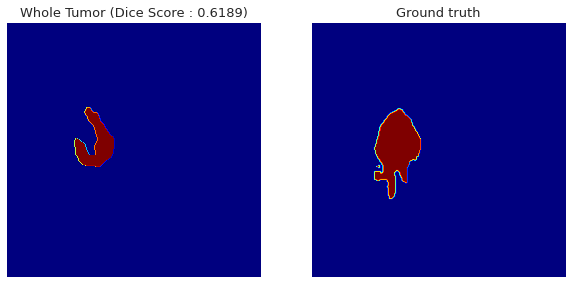

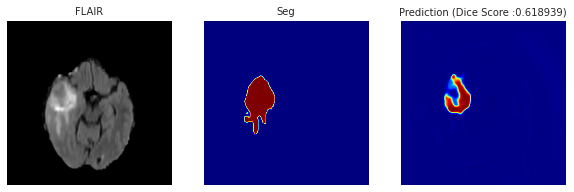

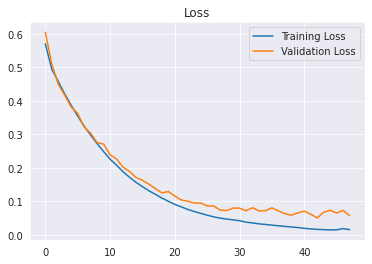

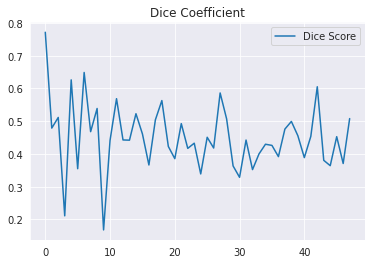

Training Epoch : [49/100]===============================================================================
Epoch: [49/100][0/20]	Time 0.635s (0.635s)	Speed 25.2 samples/s	Data 0.388s (0.388s)	Loss 0.02142 (0.02142)	
Epoch: [49/100][1/20]	Time 0.532s (0.584s)	Speed 30.1 samples/s	Data 0.358s (0.373s)	Loss 0.01331 (0.01736)	
Epoch: [49/100][2/20]	Time 0.530s (0.566s)	Speed 30.2 samples/s	Data 0.363s (0.369s)	Loss 0.01267 (0.01580)	
Epoch: [49/100][3/20]	Time 0.566s (0.566s)	Speed 28.3 samples/s	Data 0.399s (0.377s)	Loss 0.01397 (0.01534)	
Epoch: [49/100][4/20]	Time 0.584s (0.569s)	Speed 27.4 samples/s	Data 0.418s (0.385s)	Loss 0.01490 (0.01525)	
Epoch: [49/100][5/20]	Time 0.542s (0.565s)	Speed 29.5 samples/s	Data 0.376s (0.384s)	Loss 0.01205 (0.01472)	
Epoch: [49/100][6/20]	Time 0.586s (0.568s)	Speed 27.3 samples/s	Data 0.419s (0.389s)	Loss 0.01308 (0.01448)	
Epoch: [49/100][7/20]	Time 0.551s (0.566s)	Speed 29.0 samples/s	Data 0.385s (0.388s)	Loss 0.01543 (0.01460)	
Epoch: [49/100][8/20]	T

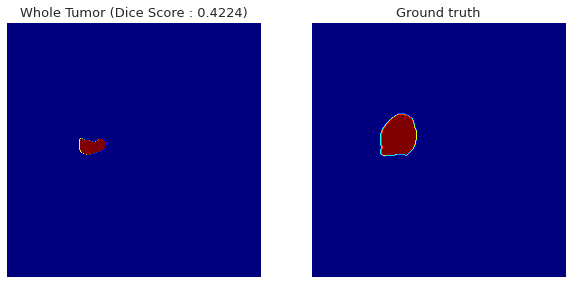

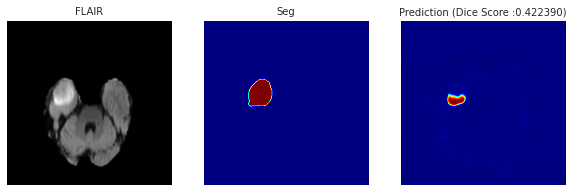

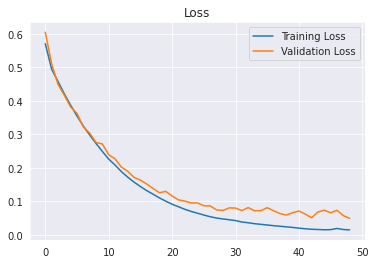

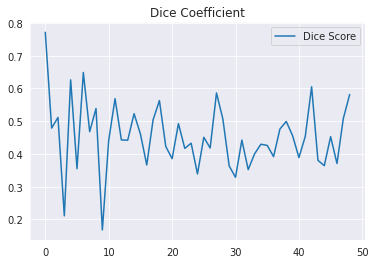

Training Epoch : [50/100]===============================================================================
Epoch: [50/100][0/20]	Time 0.674s (0.674s)	Speed 23.7 samples/s	Data 0.398s (0.398s)	Loss 0.01272 (0.01272)	
Epoch: [50/100][1/20]	Time 0.554s (0.614s)	Speed 28.9 samples/s	Data 0.386s (0.392s)	Loss 0.01395 (0.01333)	
Epoch: [50/100][2/20]	Time 0.596s (0.608s)	Speed 26.8 samples/s	Data 0.430s (0.405s)	Loss 0.01384 (0.01350)	
Epoch: [50/100][3/20]	Time 0.536s (0.590s)	Speed 29.9 samples/s	Data 0.368s (0.395s)	Loss 0.01902 (0.01488)	
Epoch: [50/100][4/20]	Time 0.555s (0.583s)	Speed 28.9 samples/s	Data 0.387s (0.394s)	Loss 0.01187 (0.01428)	
Epoch: [50/100][5/20]	Time 0.534s (0.575s)	Speed 30.0 samples/s	Data 0.367s (0.389s)	Loss 0.01332 (0.01412)	
Epoch: [50/100][6/20]	Time 0.552s (0.571s)	Speed 29.0 samples/s	Data 0.385s (0.389s)	Loss 0.01613 (0.01441)	
Epoch: [50/100][7/20]	Time 0.570s (0.571s)	Speed 28.1 samples/s	Data 0.404s (0.391s)	Loss 0.01290 (0.01422)	
Epoch: [50/100][8/20]	T

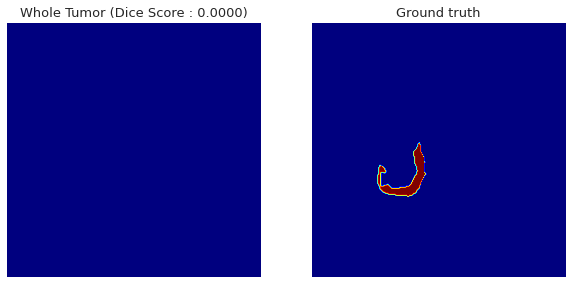

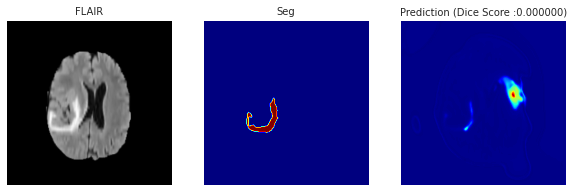

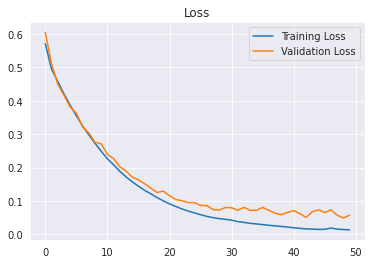

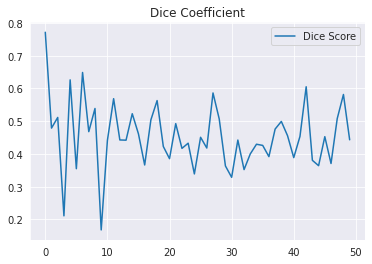

Training Epoch : [51/100]===============================================================================
Epoch: [51/100][0/20]	Time 0.698s (0.698s)	Speed 22.9 samples/s	Data 0.410s (0.410s)	Loss 0.01201 (0.01201)	
Epoch: [51/100][1/20]	Time 0.541s (0.620s)	Speed 29.6 samples/s	Data 0.373s (0.391s)	Loss 0.01243 (0.01222)	
Epoch: [51/100][2/20]	Time 0.583s (0.608s)	Speed 27.4 samples/s	Data 0.417s (0.400s)	Loss 0.01297 (0.01247)	
Epoch: [51/100][3/20]	Time 0.539s (0.591s)	Speed 29.7 samples/s	Data 0.373s (0.393s)	Loss 0.01451 (0.01298)	
Epoch: [51/100][4/20]	Time 0.549s (0.582s)	Speed 29.1 samples/s	Data 0.383s (0.391s)	Loss 0.01425 (0.01323)	
Epoch: [51/100][5/20]	Time 0.568s (0.580s)	Speed 28.2 samples/s	Data 0.402s (0.393s)	Loss 0.01263 (0.01313)	
Epoch: [51/100][6/20]	Time 0.555s (0.576s)	Speed 28.8 samples/s	Data 0.387s (0.392s)	Loss 0.01253 (0.01305)	
Epoch: [51/100][7/20]	Time 0.576s (0.576s)	Speed 27.8 samples/s	Data 0.411s (0.394s)	Loss 0.01134 (0.01283)	
Epoch: [51/100][8/20]	T

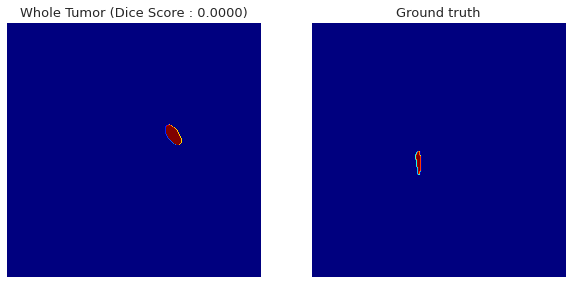

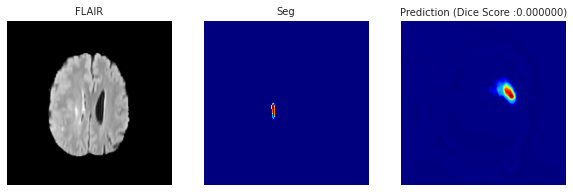

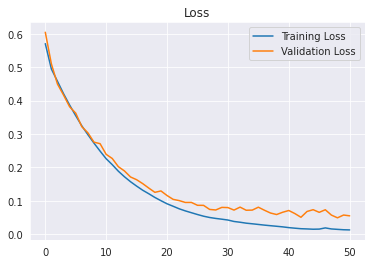

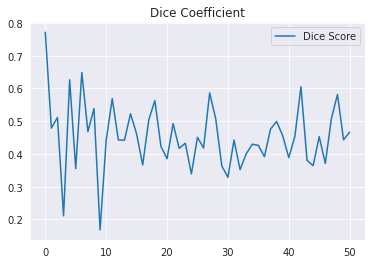

Training Epoch : [52/100]===============================================================================
Epoch: [52/100][0/20]	Time 0.694s (0.694s)	Speed 23.1 samples/s	Data 0.419s (0.419s)	Loss 0.01179 (0.01179)	
Epoch: [52/100][1/20]	Time 0.526s (0.610s)	Speed 30.4 samples/s	Data 0.358s (0.389s)	Loss 0.01410 (0.01295)	
Epoch: [52/100][2/20]	Time 0.571s (0.597s)	Speed 28.0 samples/s	Data 0.405s (0.394s)	Loss 0.01372 (0.01320)	
Epoch: [52/100][3/20]	Time 0.550s (0.585s)	Speed 29.1 samples/s	Data 0.384s (0.392s)	Loss 0.01413 (0.01344)	
Epoch: [52/100][4/20]	Time 0.566s (0.581s)	Speed 28.3 samples/s	Data 0.400s (0.393s)	Loss 0.01400 (0.01355)	
Epoch: [52/100][5/20]	Time 0.542s (0.575s)	Speed 29.5 samples/s	Data 0.377s (0.391s)	Loss 0.01607 (0.01397)	
Epoch: [52/100][6/20]	Time 0.544s (0.570s)	Speed 29.4 samples/s	Data 0.378s (0.389s)	Loss 0.01473 (0.01408)	
Epoch: [52/100][7/20]	Time 0.543s (0.567s)	Speed 29.4 samples/s	Data 0.377s (0.387s)	Loss 0.01212 (0.01383)	
Epoch: [52/100][8/20]	T

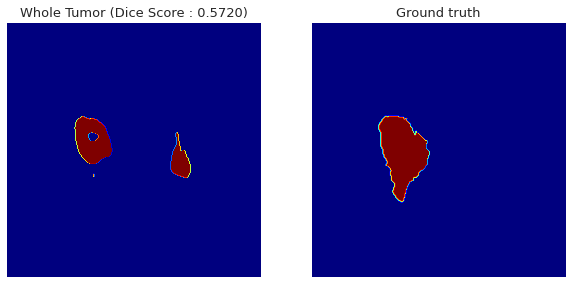

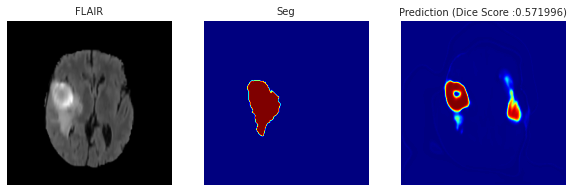

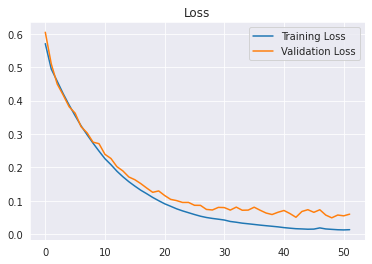

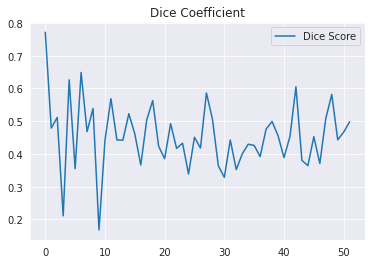

Training Epoch : [53/100]===============================================================================
Epoch: [53/100][0/20]	Time 0.713s (0.713s)	Speed 22.4 samples/s	Data 0.436s (0.436s)	Loss 0.01262 (0.01262)	
Epoch: [53/100][1/20]	Time 0.574s (0.644s)	Speed 27.9 samples/s	Data 0.406s (0.421s)	Loss 0.01185 (0.01224)	
Epoch: [53/100][2/20]	Time 0.574s (0.620s)	Speed 27.9 samples/s	Data 0.408s (0.416s)	Loss 0.01121 (0.01189)	
Epoch: [53/100][3/20]	Time 0.560s (0.605s)	Speed 28.6 samples/s	Data 0.394s (0.411s)	Loss 0.01127 (0.01174)	
Epoch: [53/100][4/20]	Time 0.575s (0.599s)	Speed 27.8 samples/s	Data 0.401s (0.409s)	Loss 0.01081 (0.01155)	
Epoch: [53/100][5/20]	Time 0.541s (0.589s)	Speed 29.6 samples/s	Data 0.374s (0.403s)	Loss 0.01130 (0.01151)	
Epoch: [53/100][6/20]	Time 0.573s (0.587s)	Speed 27.9 samples/s	Data 0.406s (0.404s)	Loss 0.01215 (0.01160)	
Epoch: [53/100][7/20]	Time 0.534s (0.580s)	Speed 29.9 samples/s	Data 0.368s (0.399s)	Loss 0.01242 (0.01170)	
Epoch: [53/100][8/20]	T

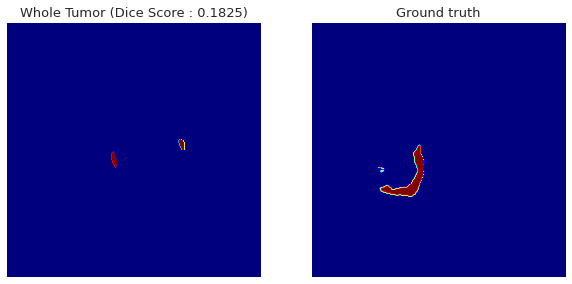

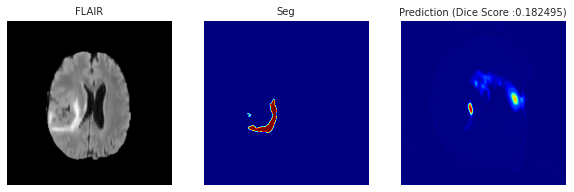

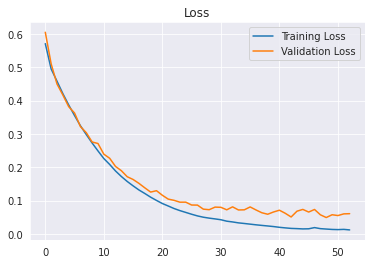

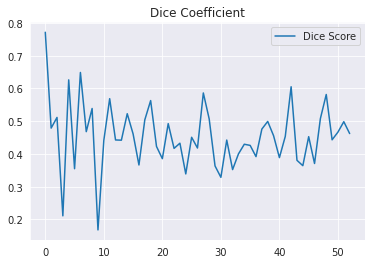

Training Epoch : [54/100]===============================================================================
Epoch: [54/100][0/20]	Time 0.654s (0.654s)	Speed 24.5 samples/s	Data 0.394s (0.394s)	Loss 0.00963 (0.00963)	
Epoch: [54/100][1/20]	Time 0.576s (0.615s)	Speed 27.8 samples/s	Data 0.409s (0.401s)	Loss 0.01538 (0.01251)	
Epoch: [54/100][2/20]	Time 0.536s (0.589s)	Speed 29.9 samples/s	Data 0.370s (0.391s)	Loss 0.01054 (0.01185)	
Epoch: [54/100][3/20]	Time 0.532s (0.575s)	Speed 30.1 samples/s	Data 0.367s (0.385s)	Loss 0.00908 (0.01116)	
Epoch: [54/100][4/20]	Time 0.574s (0.574s)	Speed 27.9 samples/s	Data 0.406s (0.389s)	Loss 0.01274 (0.01147)	
Epoch: [54/100][5/20]	Time 0.588s (0.577s)	Speed 27.2 samples/s	Data 0.422s (0.395s)	Loss 0.01099 (0.01139)	
Epoch: [54/100][6/20]	Time 0.553s (0.573s)	Speed 29.0 samples/s	Data 0.386s (0.393s)	Loss 0.01004 (0.01120)	
Epoch: [54/100][7/20]	Time 0.580s (0.574s)	Speed 27.6 samples/s	Data 0.413s (0.396s)	Loss 0.01164 (0.01126)	
Epoch: [54/100][8/20]	T

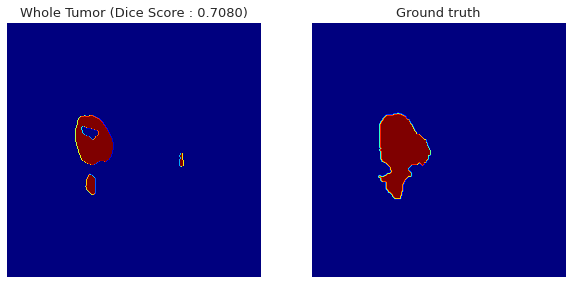

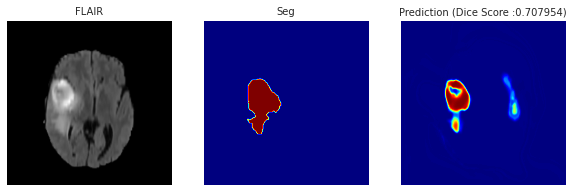

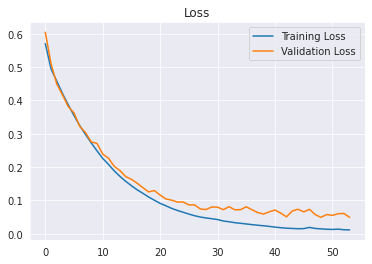

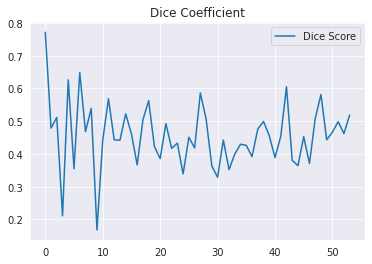

Training Epoch : [55/100]===============================================================================
Epoch: [55/100][0/20]	Time 0.678s (0.678s)	Speed 23.6 samples/s	Data 0.428s (0.428s)	Loss 0.01333 (0.01333)	
Epoch: [55/100][1/20]	Time 0.614s (0.646s)	Speed 26.1 samples/s	Data 0.442s (0.435s)	Loss 0.01228 (0.01280)	
Epoch: [55/100][2/20]	Time 0.583s (0.625s)	Speed 27.5 samples/s	Data 0.415s (0.428s)	Loss 0.01139 (0.01233)	
Epoch: [55/100][3/20]	Time 0.593s (0.617s)	Speed 27.0 samples/s	Data 0.427s (0.428s)	Loss 0.01284 (0.01246)	
Epoch: [55/100][4/20]	Time 0.564s (0.606s)	Speed 28.4 samples/s	Data 0.397s (0.422s)	Loss 0.01166 (0.01230)	
Epoch: [55/100][5/20]	Time 0.563s (0.599s)	Speed 28.4 samples/s	Data 0.396s (0.417s)	Loss 0.01118 (0.01211)	
Epoch: [55/100][6/20]	Time 0.580s (0.596s)	Speed 27.6 samples/s	Data 0.413s (0.417s)	Loss 0.01057 (0.01189)	
Epoch: [55/100][7/20]	Time 0.576s (0.594s)	Speed 27.8 samples/s	Data 0.407s (0.416s)	Loss 0.00953 (0.01160)	
Epoch: [55/100][8/20]	T

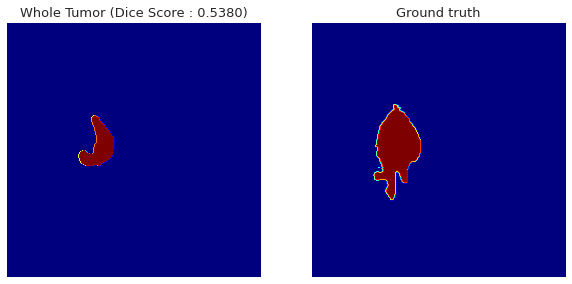

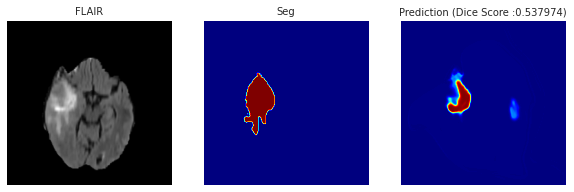

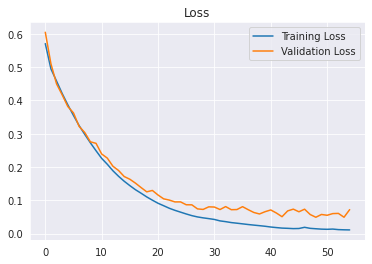

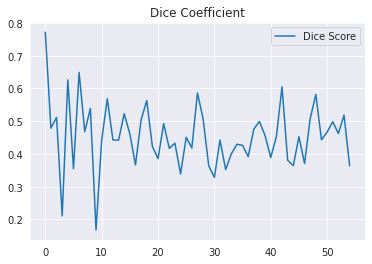

Training Epoch : [56/100]===============================================================================
Epoch: [56/100][0/20]	Time 0.679s (0.679s)	Speed 23.6 samples/s	Data 0.422s (0.422s)	Loss 0.01126 (0.01126)	
Epoch: [56/100][1/20]	Time 0.559s (0.619s)	Speed 28.6 samples/s	Data 0.392s (0.407s)	Loss 0.01174 (0.01150)	
Epoch: [56/100][2/20]	Time 0.589s (0.609s)	Speed 27.2 samples/s	Data 0.422s (0.412s)	Loss 0.01009 (0.01103)	
Epoch: [56/100][3/20]	Time 0.585s (0.603s)	Speed 27.4 samples/s	Data 0.419s (0.414s)	Loss 0.01188 (0.01124)	
Epoch: [56/100][4/20]	Time 0.542s (0.591s)	Speed 29.5 samples/s	Data 0.375s (0.406s)	Loss 0.00929 (0.01085)	
Epoch: [56/100][5/20]	Time 0.586s (0.590s)	Speed 27.3 samples/s	Data 0.419s (0.408s)	Loss 0.00911 (0.01056)	
Epoch: [56/100][6/20]	Time 0.587s (0.590s)	Speed 27.2 samples/s	Data 0.422s (0.410s)	Loss 0.01470 (0.01115)	
Epoch: [56/100][7/20]	Time 0.550s (0.585s)	Speed 29.1 samples/s	Data 0.384s (0.407s)	Loss 0.01162 (0.01121)	
Epoch: [56/100][8/20]	T

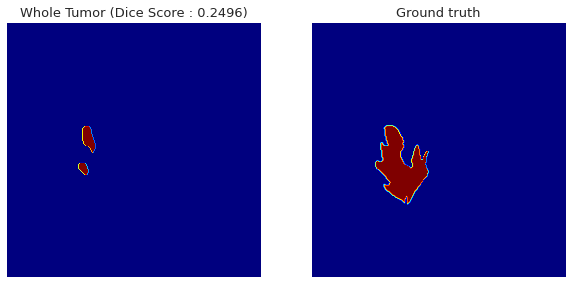

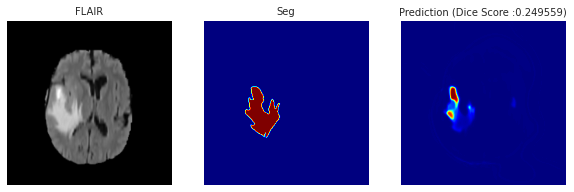

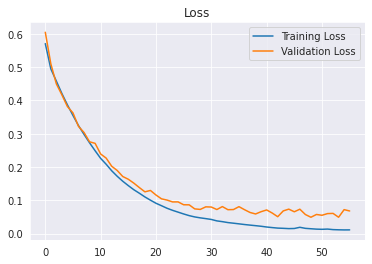

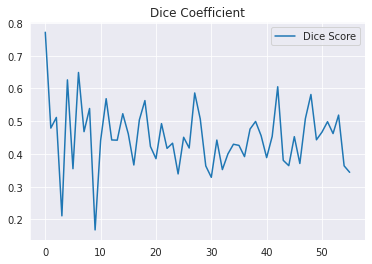

Training Epoch : [57/100]===============================================================================
Epoch: [57/100][0/20]	Time 0.733s (0.733s)	Speed 21.8 samples/s	Data 0.486s (0.486s)	Loss 0.00990 (0.00990)	
Epoch: [57/100][1/20]	Time 0.583s (0.658s)	Speed 27.5 samples/s	Data 0.412s (0.449s)	Loss 0.01162 (0.01076)	
Epoch: [57/100][2/20]	Time 0.551s (0.622s)	Speed 29.0 samples/s	Data 0.384s (0.428s)	Loss 0.01856 (0.01336)	
Epoch: [57/100][3/20]	Time 0.530s (0.599s)	Speed 30.2 samples/s	Data 0.361s (0.411s)	Loss 0.01083 (0.01273)	
Epoch: [57/100][4/20]	Time 0.576s (0.595s)	Speed 27.8 samples/s	Data 0.410s (0.411s)	Loss 0.01358 (0.01290)	
Epoch: [57/100][5/20]	Time 0.561s (0.589s)	Speed 28.5 samples/s	Data 0.394s (0.408s)	Loss 0.01391 (0.01307)	
Epoch: [57/100][6/20]	Time 0.557s (0.584s)	Speed 28.7 samples/s	Data 0.390s (0.405s)	Loss 0.01338 (0.01311)	
Epoch: [57/100][7/20]	Time 0.543s (0.579s)	Speed 29.4 samples/s	Data 0.373s (0.401s)	Loss 0.01537 (0.01339)	
Epoch: [57/100][8/20]	T

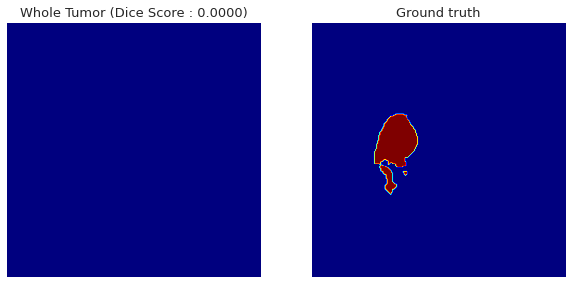

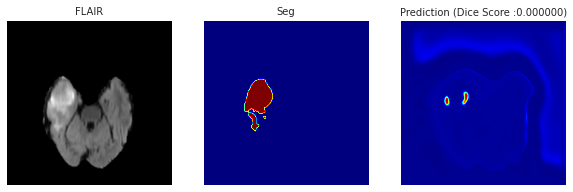

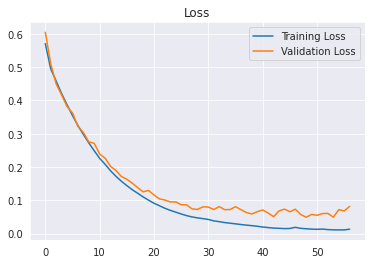

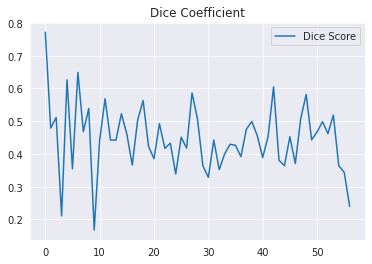

Training Epoch : [58/100]===============================================================================
Epoch: [58/100][0/20]	Time 0.682s (0.682s)	Speed 23.4 samples/s	Data 0.436s (0.436s)	Loss 0.01412 (0.01412)	
Epoch: [58/100][1/20]	Time 0.580s (0.631s)	Speed 27.6 samples/s	Data 0.403s (0.419s)	Loss 0.01169 (0.01290)	
Epoch: [58/100][2/20]	Time 0.538s (0.600s)	Speed 29.8 samples/s	Data 0.372s (0.403s)	Loss 0.01516 (0.01366)	
Epoch: [58/100][3/20]	Time 0.580s (0.595s)	Speed 27.6 samples/s	Data 0.414s (0.406s)	Loss 0.01493 (0.01397)	
Epoch: [58/100][4/20]	Time 0.565s (0.589s)	Speed 28.3 samples/s	Data 0.399s (0.405s)	Loss 0.01223 (0.01363)	
Epoch: [58/100][5/20]	Time 0.557s (0.584s)	Speed 28.7 samples/s	Data 0.390s (0.402s)	Loss 0.01091 (0.01317)	
Epoch: [58/100][6/20]	Time 0.580s (0.583s)	Speed 27.6 samples/s	Data 0.412s (0.404s)	Loss 0.01042 (0.01278)	
Epoch: [58/100][7/20]	Time 0.599s (0.585s)	Speed 26.7 samples/s	Data 0.433s (0.407s)	Loss 0.01039 (0.01248)	
Epoch: [58/100][8/20]	T

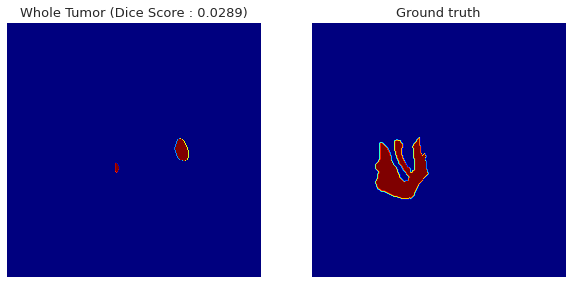

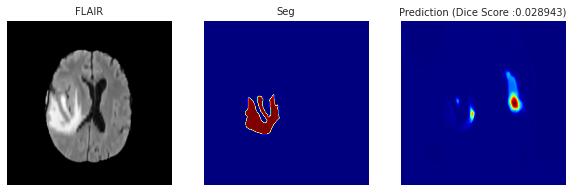

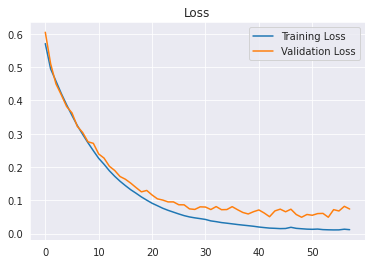

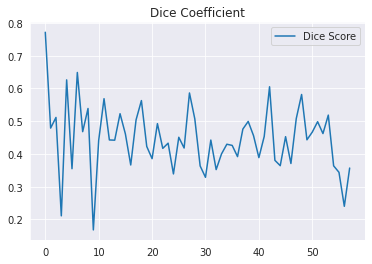

Training Epoch : [59/100]===============================================================================
Epoch: [59/100][0/20]	Time 0.685s (0.685s)	Speed 23.4 samples/s	Data 0.409s (0.409s)	Loss 0.00969 (0.00969)	
Epoch: [59/100][1/20]	Time 0.591s (0.638s)	Speed 27.1 samples/s	Data 0.424s (0.417s)	Loss 0.00956 (0.00962)	
Epoch: [59/100][2/20]	Time 0.582s (0.619s)	Speed 27.5 samples/s	Data 0.416s (0.416s)	Loss 0.01053 (0.00993)	
Epoch: [59/100][3/20]	Time 0.588s (0.611s)	Speed 27.2 samples/s	Data 0.421s (0.418s)	Loss 0.00954 (0.00983)	
Epoch: [59/100][4/20]	Time 0.574s (0.604s)	Speed 27.9 samples/s	Data 0.408s (0.416s)	Loss 0.01025 (0.00992)	
Epoch: [59/100][5/20]	Time 0.588s (0.601s)	Speed 27.2 samples/s	Data 0.422s (0.417s)	Loss 0.01313 (0.01045)	
Epoch: [59/100][6/20]	Time 0.549s (0.594s)	Speed 29.1 samples/s	Data 0.382s (0.412s)	Loss 0.00972 (0.01035)	
Epoch: [59/100][7/20]	Time 0.531s (0.586s)	Speed 30.2 samples/s	Data 0.363s (0.406s)	Loss 0.00949 (0.01024)	
Epoch: [59/100][8/20]	T

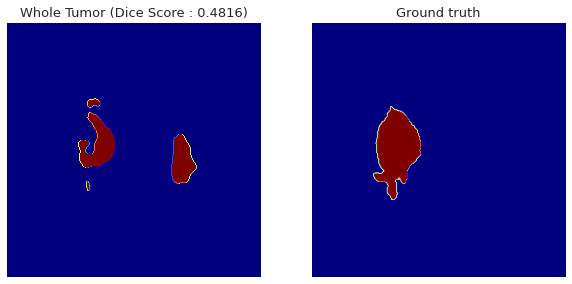

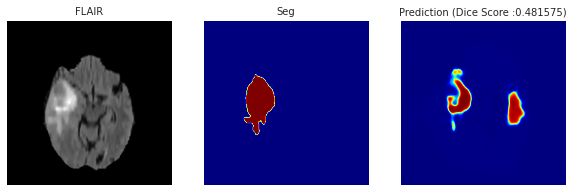

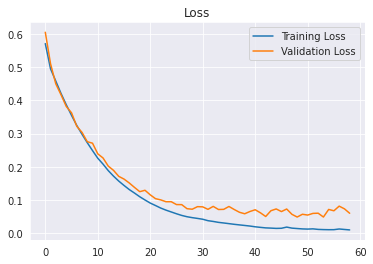

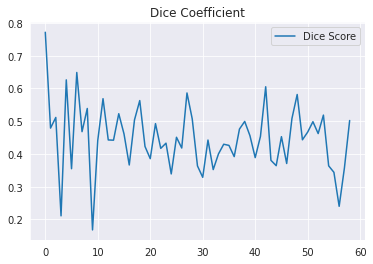

Training Epoch : [60/100]===============================================================================
Epoch: [60/100][0/20]	Time 0.709s (0.709s)	Speed 22.6 samples/s	Data 0.420s (0.420s)	Loss 0.01007 (0.01007)	
Epoch: [60/100][1/20]	Time 0.587s (0.648s)	Speed 27.3 samples/s	Data 0.415s (0.417s)	Loss 0.01010 (0.01009)	
Epoch: [60/100][2/20]	Time 0.552s (0.616s)	Speed 29.0 samples/s	Data 0.385s (0.406s)	Loss 0.00959 (0.00992)	
Epoch: [60/100][3/20]	Time 0.564s (0.603s)	Speed 28.4 samples/s	Data 0.396s (0.404s)	Loss 0.01194 (0.01043)	
Epoch: [60/100][4/20]	Time 0.537s (0.590s)	Speed 29.8 samples/s	Data 0.370s (0.397s)	Loss 0.00981 (0.01030)	
Epoch: [60/100][5/20]	Time 0.566s (0.586s)	Speed 28.3 samples/s	Data 0.399s (0.397s)	Loss 0.00967 (0.01020)	
Epoch: [60/100][6/20]	Time 0.538s (0.579s)	Speed 29.7 samples/s	Data 0.371s (0.394s)	Loss 0.00959 (0.01011)	
Epoch: [60/100][7/20]	Time 0.568s (0.577s)	Speed 28.2 samples/s	Data 0.400s (0.394s)	Loss 0.00857 (0.00992)	
Epoch: [60/100][8/20]	T

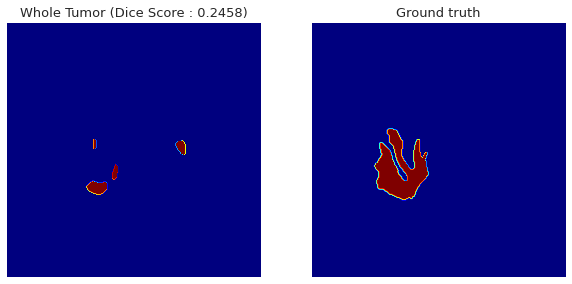

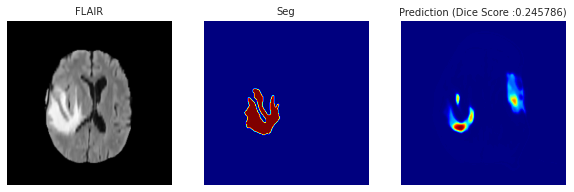

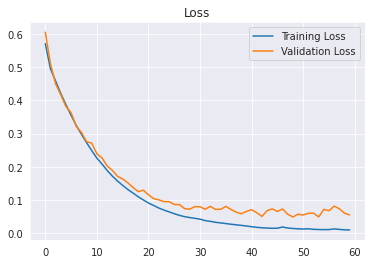

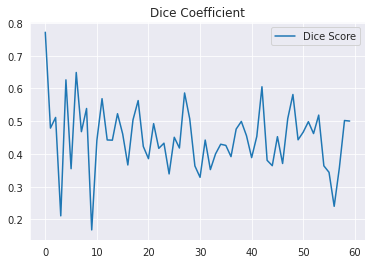

Training Epoch : [61/100]===============================================================================
Epoch: [61/100][0/20]	Time 0.661s (0.661s)	Speed 24.2 samples/s	Data 0.398s (0.398s)	Loss 0.00947 (0.00947)	
Epoch: [61/100][1/20]	Time 0.560s (0.611s)	Speed 28.6 samples/s	Data 0.393s (0.396s)	Loss 0.00797 (0.00872)	
Epoch: [61/100][2/20]	Time 0.561s (0.594s)	Speed 28.5 samples/s	Data 0.395s (0.395s)	Loss 0.01076 (0.00940)	
Epoch: [61/100][3/20]	Time 0.571s (0.588s)	Speed 28.0 samples/s	Data 0.403s (0.397s)	Loss 0.01188 (0.01002)	
Epoch: [61/100][4/20]	Time 0.539s (0.578s)	Speed 29.7 samples/s	Data 0.370s (0.392s)	Loss 0.00802 (0.00962)	
Epoch: [61/100][5/20]	Time 0.606s (0.583s)	Speed 26.4 samples/s	Data 0.439s (0.400s)	Loss 0.01042 (0.00976)	
Epoch: [61/100][6/20]	Time 0.572s (0.581s)	Speed 28.0 samples/s	Data 0.406s (0.401s)	Loss 0.00904 (0.00965)	
Epoch: [61/100][7/20]	Time 0.550s (0.578s)	Speed 29.1 samples/s	Data 0.382s (0.398s)	Loss 0.00752 (0.00939)	
Epoch: [61/100][8/20]	T

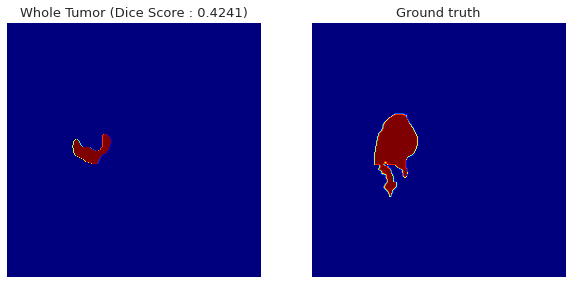

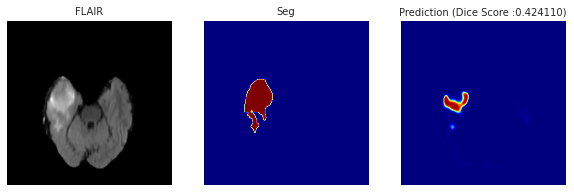

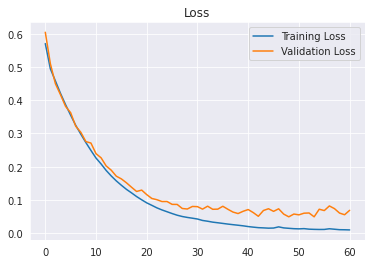

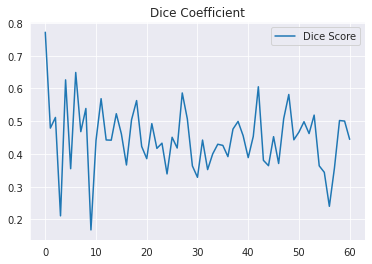

Training Epoch : [62/100]===============================================================================
Epoch: [62/100][0/20]	Time 0.709s (0.709s)	Speed 22.6 samples/s	Data 0.448s (0.448s)	Loss 0.00940 (0.00940)	
Epoch: [62/100][1/20]	Time 0.565s (0.637s)	Speed 28.3 samples/s	Data 0.397s (0.422s)	Loss 0.00947 (0.00943)	
Epoch: [62/100][2/20]	Time 0.577s (0.617s)	Speed 27.7 samples/s	Data 0.411s (0.418s)	Loss 0.00865 (0.00917)	
Epoch: [62/100][3/20]	Time 0.546s (0.599s)	Speed 29.3 samples/s	Data 0.378s (0.408s)	Loss 0.01081 (0.00958)	
Epoch: [62/100][4/20]	Time 0.555s (0.591s)	Speed 28.8 samples/s	Data 0.389s (0.405s)	Loss 0.00797 (0.00926)	
Epoch: [62/100][5/20]	Time 0.576s (0.588s)	Speed 27.8 samples/s	Data 0.408s (0.405s)	Loss 0.00861 (0.00915)	
Epoch: [62/100][6/20]	Time 0.586s (0.588s)	Speed 27.3 samples/s	Data 0.419s (0.407s)	Loss 0.00962 (0.00922)	
Epoch: [62/100][7/20]	Time 0.567s (0.585s)	Speed 28.2 samples/s	Data 0.400s (0.406s)	Loss 0.01092 (0.00943)	
Epoch: [62/100][8/20]	T

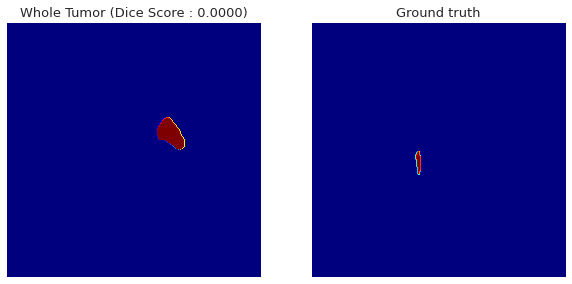

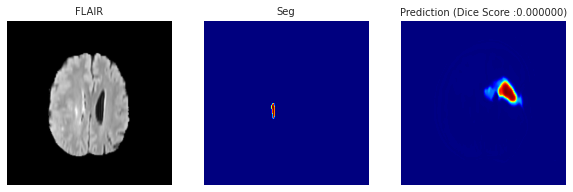

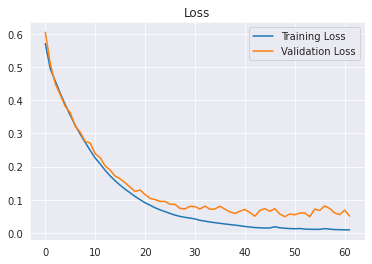

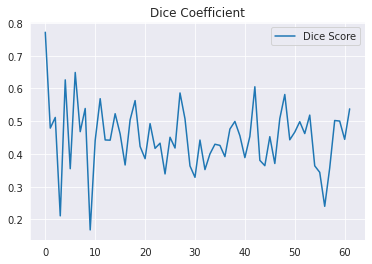

Training Epoch : [63/100]===============================================================================
Epoch: [63/100][0/20]	Time 0.733s (0.733s)	Speed 21.8 samples/s	Data 0.443s (0.443s)	Loss 0.00942 (0.00942)	
Epoch: [63/100][1/20]	Time 0.556s (0.644s)	Speed 28.8 samples/s	Data 0.388s (0.415s)	Loss 0.00953 (0.00947)	
Epoch: [63/100][2/20]	Time 0.546s (0.612s)	Speed 29.3 samples/s	Data 0.379s (0.403s)	Loss 0.00862 (0.00919)	
Epoch: [63/100][3/20]	Time 0.547s (0.595s)	Speed 29.3 samples/s	Data 0.380s (0.397s)	Loss 0.00845 (0.00900)	
Epoch: [63/100][4/20]	Time 0.581s (0.593s)	Speed 27.5 samples/s	Data 0.414s (0.401s)	Loss 0.01038 (0.00928)	
Epoch: [63/100][5/20]	Time 0.605s (0.595s)	Speed 26.5 samples/s	Data 0.437s (0.407s)	Loss 0.00649 (0.00882)	
Epoch: [63/100][6/20]	Time 0.612s (0.597s)	Speed 26.1 samples/s	Data 0.446s (0.412s)	Loss 0.01187 (0.00925)	
Epoch: [63/100][7/20]	Time 0.559s (0.592s)	Speed 28.6 samples/s	Data 0.391s (0.410s)	Loss 0.00948 (0.00928)	
Epoch: [63/100][8/20]	T

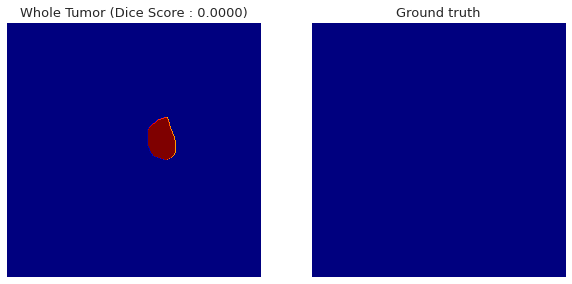

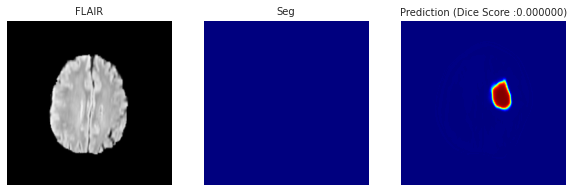

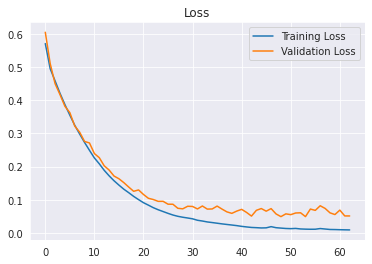

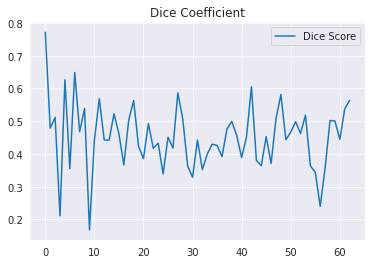

Training Epoch : [64/100]===============================================================================
Epoch: [64/100][0/20]	Time 0.711s (0.711s)	Speed 22.5 samples/s	Data 0.424s (0.424s)	Loss 0.00946 (0.00946)	
Epoch: [64/100][1/20]	Time 0.550s (0.630s)	Speed 29.1 samples/s	Data 0.383s (0.404s)	Loss 0.00818 (0.00882)	
Epoch: [64/100][2/20]	Time 0.591s (0.617s)	Speed 27.1 samples/s	Data 0.424s (0.410s)	Loss 0.00856 (0.00874)	
Epoch: [64/100][3/20]	Time 0.556s (0.602s)	Speed 28.8 samples/s	Data 0.388s (0.405s)	Loss 0.00752 (0.00843)	
Epoch: [64/100][4/20]	Time 0.585s (0.598s)	Speed 27.3 samples/s	Data 0.417s (0.407s)	Loss 0.00825 (0.00839)	
Epoch: [64/100][5/20]	Time 0.557s (0.592s)	Speed 28.7 samples/s	Data 0.391s (0.405s)	Loss 0.00867 (0.00844)	
Epoch: [64/100][6/20]	Time 0.582s (0.590s)	Speed 27.5 samples/s	Data 0.415s (0.406s)	Loss 0.00983 (0.00864)	
Epoch: [64/100][7/20]	Time 0.584s (0.589s)	Speed 27.4 samples/s	Data 0.416s (0.407s)	Loss 0.00773 (0.00853)	
Epoch: [64/100][8/20]	T

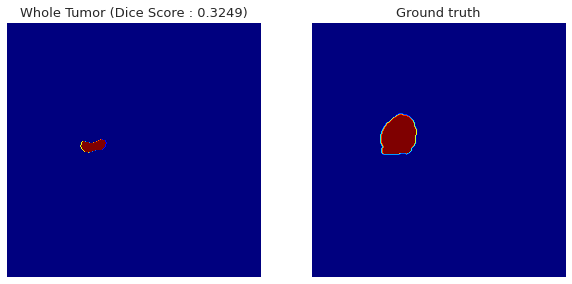

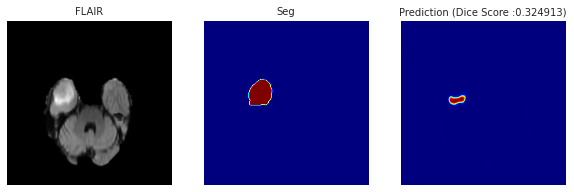

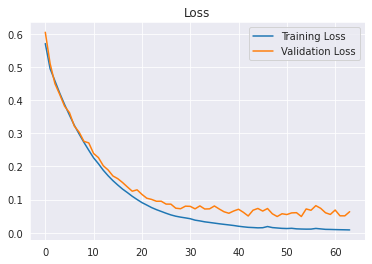

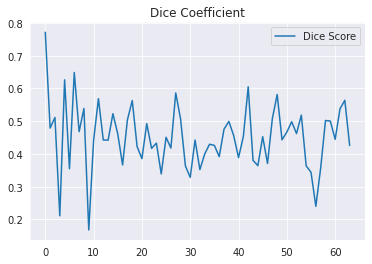

Training Epoch : [65/100]===============================================================================
Epoch: [65/100][0/20]	Time 0.681s (0.681s)	Speed 23.5 samples/s	Data 0.437s (0.437s)	Loss 0.00916 (0.00916)	
Epoch: [65/100][1/20]	Time 0.534s (0.608s)	Speed 30.0 samples/s	Data 0.363s (0.400s)	Loss 0.00832 (0.00874)	
Epoch: [65/100][2/20]	Time 0.535s (0.584s)	Speed 29.9 samples/s	Data 0.368s (0.389s)	Loss 0.00813 (0.00854)	
Epoch: [65/100][3/20]	Time 0.538s (0.572s)	Speed 29.7 samples/s	Data 0.372s (0.385s)	Loss 0.00886 (0.00862)	
Epoch: [65/100][4/20]	Time 0.537s (0.565s)	Speed 29.8 samples/s	Data 0.366s (0.381s)	Loss 0.00943 (0.00878)	
Epoch: [65/100][5/20]	Time 0.551s (0.563s)	Speed 29.0 samples/s	Data 0.386s (0.382s)	Loss 0.00685 (0.00846)	
Epoch: [65/100][6/20]	Time 0.583s (0.566s)	Speed 27.5 samples/s	Data 0.415s (0.387s)	Loss 0.00836 (0.00845)	
Epoch: [65/100][7/20]	Time 0.596s (0.569s)	Speed 26.9 samples/s	Data 0.428s (0.392s)	Loss 0.00809 (0.00840)	
Epoch: [65/100][8/20]	T

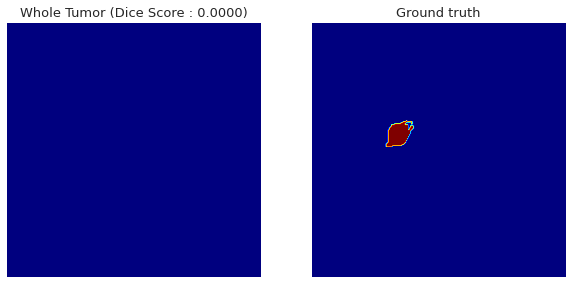

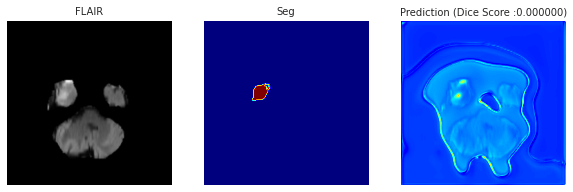

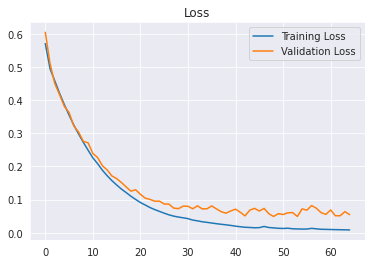

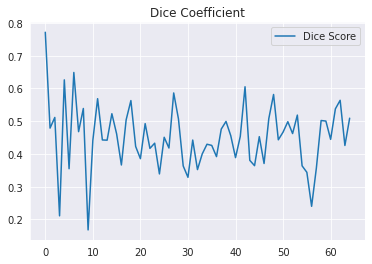

Training Epoch : [66/100]===============================================================================
Epoch: [66/100][0/20]	Time 0.682s (0.682s)	Speed 23.5 samples/s	Data 0.433s (0.433s)	Loss 0.00698 (0.00698)	
Epoch: [66/100][1/20]	Time 0.575s (0.628s)	Speed 27.8 samples/s	Data 0.407s (0.420s)	Loss 0.00692 (0.00695)	
Epoch: [66/100][2/20]	Time 0.573s (0.610s)	Speed 27.9 samples/s	Data 0.406s (0.415s)	Loss 0.00945 (0.00779)	
Epoch: [66/100][3/20]	Time 0.563s (0.598s)	Speed 28.4 samples/s	Data 0.396s (0.410s)	Loss 0.00732 (0.00767)	
Epoch: [66/100][4/20]	Time 0.566s (0.592s)	Speed 28.3 samples/s	Data 0.401s (0.409s)	Loss 0.00962 (0.00806)	
Epoch: [66/100][5/20]	Time 0.574s (0.589s)	Speed 27.9 samples/s	Data 0.408s (0.409s)	Loss 0.00739 (0.00795)	
Epoch: [66/100][6/20]	Time 0.531s (0.581s)	Speed 30.1 samples/s	Data 0.363s (0.402s)	Loss 0.00892 (0.00809)	
Epoch: [66/100][7/20]	Time 0.563s (0.578s)	Speed 28.4 samples/s	Data 0.396s (0.401s)	Loss 0.00726 (0.00798)	
Epoch: [66/100][8/20]	T

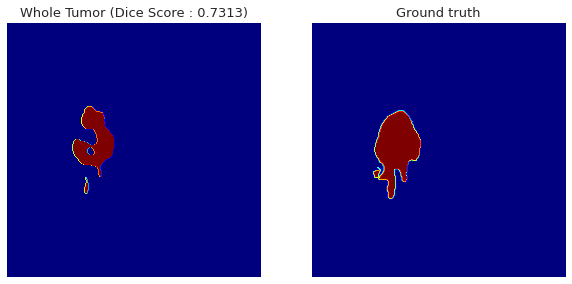

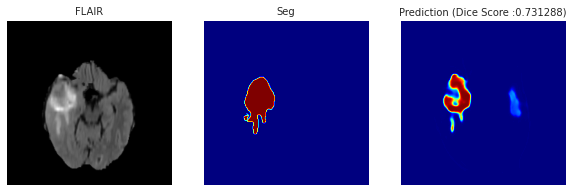

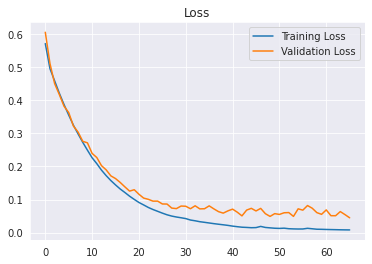

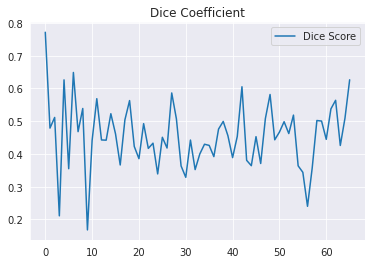

Training Epoch : [67/100]===============================================================================
Epoch: [67/100][0/20]	Time 0.753s (0.753s)	Speed 21.3 samples/s	Data 0.483s (0.483s)	Loss 0.00840 (0.00840)	
Epoch: [67/100][1/20]	Time 0.552s (0.652s)	Speed 29.0 samples/s	Data 0.384s (0.434s)	Loss 0.00751 (0.00795)	
Epoch: [67/100][2/20]	Time 0.560s (0.622s)	Speed 28.6 samples/s	Data 0.392s (0.420s)	Loss 0.00789 (0.00793)	
Epoch: [67/100][3/20]	Time 0.583s (0.612s)	Speed 27.5 samples/s	Data 0.416s (0.419s)	Loss 0.00778 (0.00789)	
Epoch: [67/100][4/20]	Time 0.584s (0.606s)	Speed 27.4 samples/s	Data 0.416s (0.418s)	Loss 0.00891 (0.00810)	
Epoch: [67/100][5/20]	Time 0.607s (0.606s)	Speed 26.3 samples/s	Data 0.439s (0.422s)	Loss 0.00645 (0.00782)	
Epoch: [67/100][6/20]	Time 0.553s (0.599s)	Speed 28.9 samples/s	Data 0.386s (0.417s)	Loss 0.00651 (0.00763)	
Epoch: [67/100][7/20]	Time 0.580s (0.597s)	Speed 27.6 samples/s	Data 0.414s (0.416s)	Loss 0.00858 (0.00775)	
Epoch: [67/100][8/20]	T

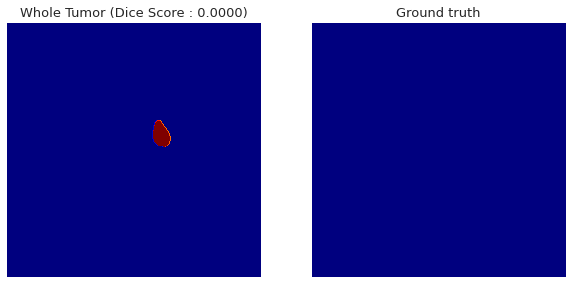

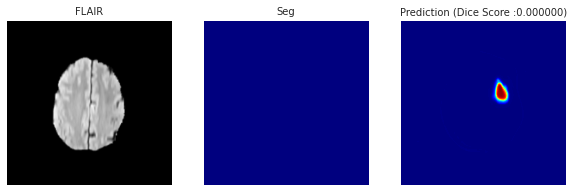

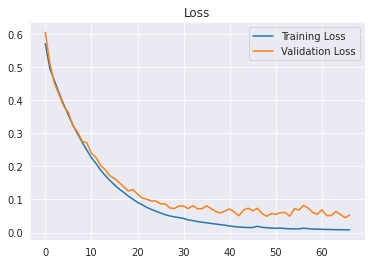

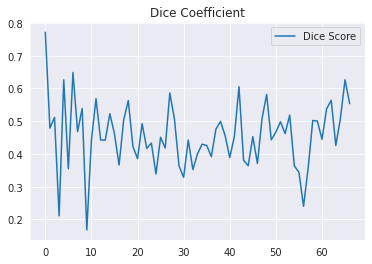

Training Epoch : [68/100]===============================================================================
Epoch: [68/100][0/20]	Time 0.672s (0.672s)	Speed 23.8 samples/s	Data 0.408s (0.408s)	Loss 0.00887 (0.00887)	
Epoch: [68/100][1/20]	Time 0.609s (0.640s)	Speed 26.3 samples/s	Data 0.441s (0.425s)	Loss 0.00716 (0.00801)	
Epoch: [68/100][2/20]	Time 0.608s (0.630s)	Speed 26.3 samples/s	Data 0.440s (0.430s)	Loss 0.00695 (0.00766)	
Epoch: [68/100][3/20]	Time 0.608s (0.624s)	Speed 26.3 samples/s	Data 0.440s (0.432s)	Loss 0.00724 (0.00756)	
Epoch: [68/100][4/20]	Time 0.576s (0.614s)	Speed 27.8 samples/s	Data 0.409s (0.428s)	Loss 0.00838 (0.00772)	
Epoch: [68/100][5/20]	Time 0.587s (0.610s)	Speed 27.2 samples/s	Data 0.420s (0.426s)	Loss 0.00710 (0.00762)	
Epoch: [68/100][6/20]	Time 0.577s (0.605s)	Speed 27.7 samples/s	Data 0.411s (0.424s)	Loss 0.00630 (0.00743)	
Epoch: [68/100][7/20]	Time 0.591s (0.603s)	Speed 27.1 samples/s	Data 0.423s (0.424s)	Loss 0.00919 (0.00765)	
Epoch: [68/100][8/20]	T

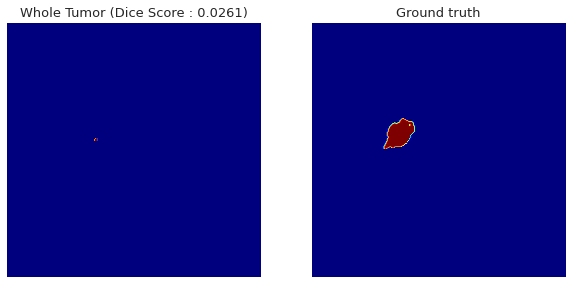

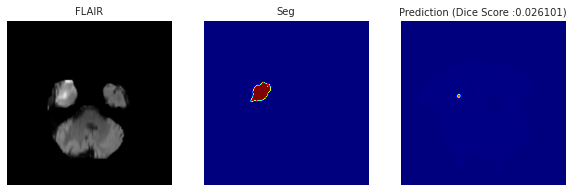

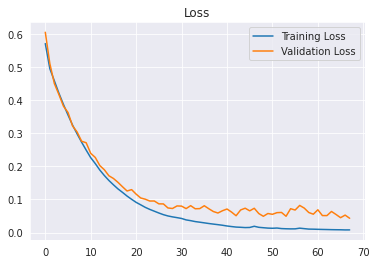

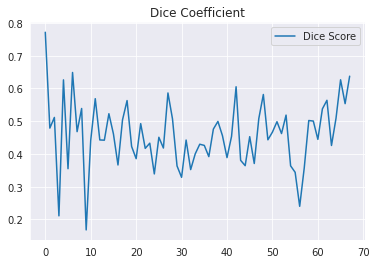

Training Epoch : [69/100]===============================================================================
Epoch: [69/100][0/20]	Time 0.695s (0.695s)	Speed 23.0 samples/s	Data 0.450s (0.450s)	Loss 0.00944 (0.00944)	
Epoch: [69/100][1/20]	Time 0.557s (0.626s)	Speed 28.7 samples/s	Data 0.385s (0.417s)	Loss 0.00843 (0.00893)	
Epoch: [69/100][2/20]	Time 0.554s (0.602s)	Speed 28.9 samples/s	Data 0.388s (0.408s)	Loss 0.00678 (0.00822)	
Epoch: [69/100][3/20]	Time 0.526s (0.583s)	Speed 30.4 samples/s	Data 0.361s (0.396s)	Loss 0.01099 (0.00891)	
Epoch: [69/100][4/20]	Time 0.536s (0.574s)	Speed 29.8 samples/s	Data 0.369s (0.391s)	Loss 0.00777 (0.00868)	
Epoch: [69/100][5/20]	Time 0.604s (0.579s)	Speed 26.5 samples/s	Data 0.437s (0.398s)	Loss 0.00573 (0.00819)	
Epoch: [69/100][6/20]	Time 0.573s (0.578s)	Speed 27.9 samples/s	Data 0.406s (0.399s)	Loss 0.00848 (0.00823)	
Epoch: [69/100][7/20]	Time 0.558s (0.576s)	Speed 28.7 samples/s	Data 0.391s (0.398s)	Loss 0.00623 (0.00798)	
Epoch: [69/100][8/20]	T

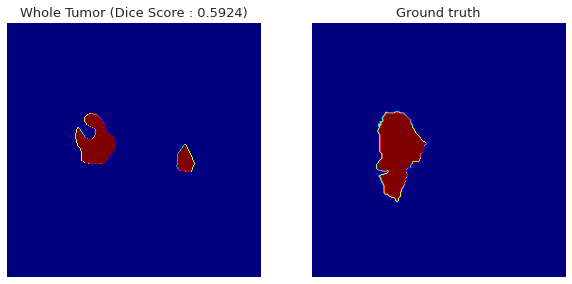

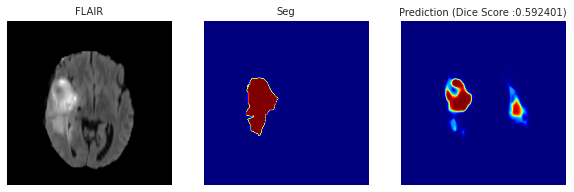

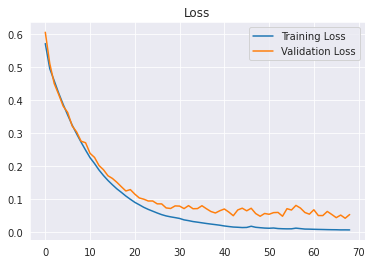

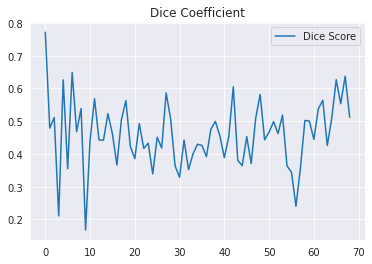

Training Epoch : [70/100]===============================================================================
Epoch: [70/100][0/20]	Time 0.766s (0.766s)	Speed 20.9 samples/s	Data 0.479s (0.479s)	Loss 0.00830 (0.00830)	
Epoch: [70/100][1/20]	Time 0.602s (0.684s)	Speed 26.6 samples/s	Data 0.436s (0.457s)	Loss 0.00745 (0.00788)	
Epoch: [70/100][2/20]	Time 0.560s (0.643s)	Speed 28.6 samples/s	Data 0.392s (0.436s)	Loss 0.00721 (0.00765)	
Epoch: [70/100][3/20]	Time 0.567s (0.624s)	Speed 28.2 samples/s	Data 0.400s (0.427s)	Loss 0.00809 (0.00776)	
Epoch: [70/100][4/20]	Time 0.545s (0.608s)	Speed 29.4 samples/s	Data 0.378s (0.417s)	Loss 0.00674 (0.00756)	
Epoch: [70/100][5/20]	Time 0.586s (0.604s)	Speed 27.3 samples/s	Data 0.419s (0.417s)	Loss 0.00806 (0.00764)	
Epoch: [70/100][6/20]	Time 0.584s (0.601s)	Speed 27.4 samples/s	Data 0.417s (0.417s)	Loss 0.00560 (0.00735)	
Epoch: [70/100][7/20]	Time 0.583s (0.599s)	Speed 27.4 samples/s	Data 0.417s (0.417s)	Loss 0.00567 (0.00714)	
Epoch: [70/100][8/20]	T

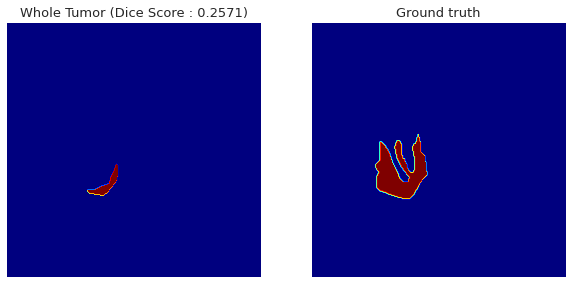

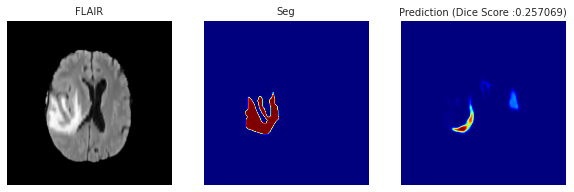

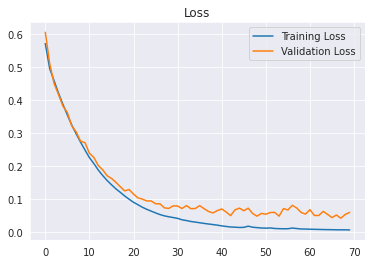

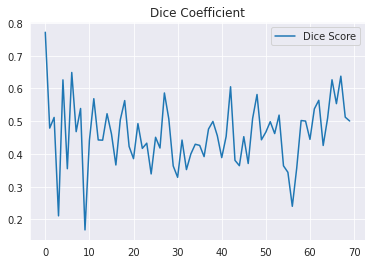

Training Epoch : [71/100]===============================================================================
Epoch: [71/100][0/20]	Time 0.705s (0.705s)	Speed 22.7 samples/s	Data 0.422s (0.422s)	Loss 0.00837 (0.00837)	
Epoch: [71/100][1/20]	Time 0.535s (0.620s)	Speed 29.9 samples/s	Data 0.368s (0.395s)	Loss 0.00554 (0.00695)	
Epoch: [71/100][2/20]	Time 0.598s (0.613s)	Speed 26.7 samples/s	Data 0.432s (0.408s)	Loss 0.00836 (0.00742)	
Epoch: [71/100][3/20]	Time 0.574s (0.603s)	Speed 27.9 samples/s	Data 0.406s (0.407s)	Loss 0.00712 (0.00735)	
Epoch: [71/100][4/20]	Time 0.539s (0.590s)	Speed 29.7 samples/s	Data 0.372s (0.400s)	Loss 0.00828 (0.00753)	
Epoch: [71/100][5/20]	Time 0.598s (0.592s)	Speed 26.8 samples/s	Data 0.431s (0.405s)	Loss 0.00636 (0.00734)	
Epoch: [71/100][6/20]	Time 0.586s (0.591s)	Speed 27.3 samples/s	Data 0.419s (0.407s)	Loss 0.00801 (0.00743)	
Epoch: [71/100][7/20]	Time 0.577s (0.589s)	Speed 27.7 samples/s	Data 0.411s (0.408s)	Loss 0.00718 (0.00740)	
Epoch: [71/100][8/20]	T

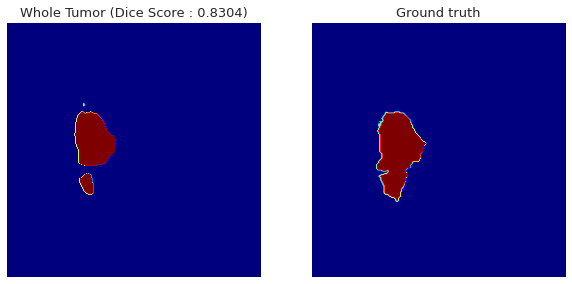

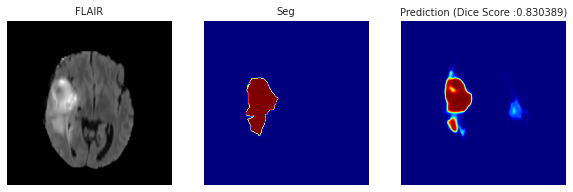

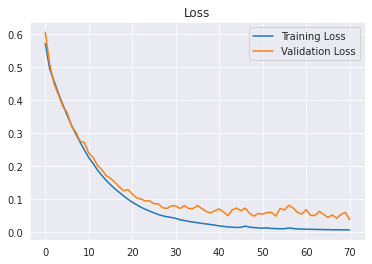

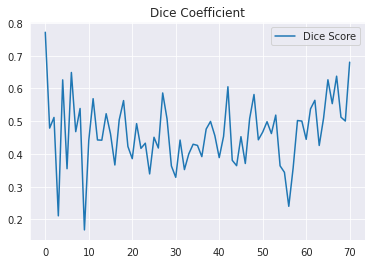

Training Epoch : [72/100]===============================================================================
Epoch: [72/100][0/20]	Time 0.745s (0.745s)	Speed 21.5 samples/s	Data 0.502s (0.502s)	Loss 0.00840 (0.00840)	
Epoch: [72/100][1/20]	Time 0.561s (0.653s)	Speed 28.5 samples/s	Data 0.388s (0.445s)	Loss 0.00890 (0.00865)	
Epoch: [72/100][2/20]	Time 0.556s (0.621s)	Speed 28.8 samples/s	Data 0.389s (0.426s)	Loss 0.00858 (0.00863)	
Epoch: [72/100][3/20]	Time 0.600s (0.616s)	Speed 26.6 samples/s	Data 0.433s (0.428s)	Loss 0.00780 (0.00842)	
Epoch: [72/100][4/20]	Time 0.583s (0.609s)	Speed 27.4 samples/s	Data 0.417s (0.426s)	Loss 0.00673 (0.00808)	
Epoch: [72/100][5/20]	Time 0.571s (0.603s)	Speed 28.0 samples/s	Data 0.404s (0.422s)	Loss 0.00683 (0.00787)	
Epoch: [72/100][6/20]	Time 0.588s (0.601s)	Speed 27.2 samples/s	Data 0.421s (0.422s)	Loss 0.00792 (0.00788)	
Epoch: [72/100][7/20]	Time 0.579s (0.598s)	Speed 27.6 samples/s	Data 0.413s (0.421s)	Loss 0.00706 (0.00778)	
Epoch: [72/100][8/20]	T

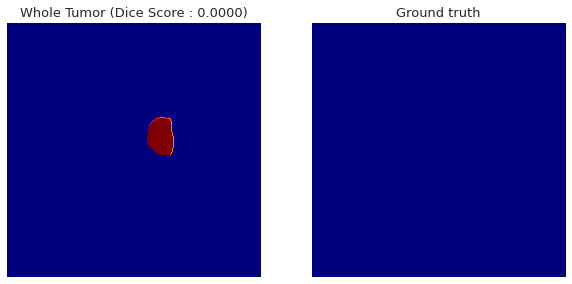

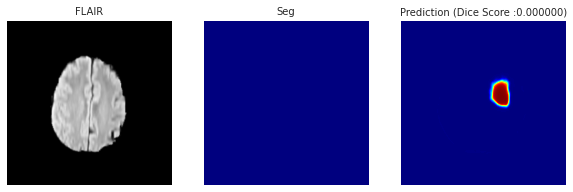

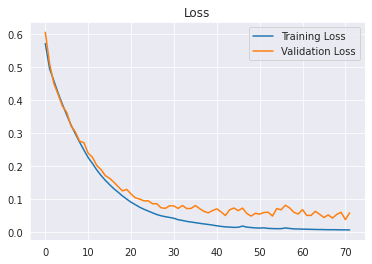

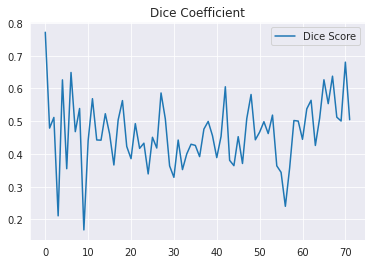

Training Epoch : [73/100]===============================================================================
Epoch: [73/100][0/20]	Time 0.717s (0.717s)	Speed 22.3 samples/s	Data 0.471s (0.471s)	Loss 0.01011 (0.01011)	
Epoch: [73/100][1/20]	Time 0.568s (0.643s)	Speed 28.2 samples/s	Data 0.399s (0.435s)	Loss 0.00689 (0.00850)	
Epoch: [73/100][2/20]	Time 0.609s (0.631s)	Speed 26.3 samples/s	Data 0.440s (0.437s)	Loss 0.00587 (0.00762)	
Epoch: [73/100][3/20]	Time 0.607s (0.625s)	Speed 26.3 samples/s	Data 0.439s (0.437s)	Loss 0.00634 (0.00730)	
Epoch: [73/100][4/20]	Time 0.582s (0.617s)	Speed 27.5 samples/s	Data 0.415s (0.433s)	Loss 0.00748 (0.00734)	
Epoch: [73/100][5/20]	Time 0.593s (0.613s)	Speed 27.0 samples/s	Data 0.427s (0.432s)	Loss 0.00586 (0.00709)	
Epoch: [73/100][6/20]	Time 0.594s (0.610s)	Speed 26.9 samples/s	Data 0.428s (0.431s)	Loss 0.00667 (0.00703)	
Epoch: [73/100][7/20]	Time 0.604s (0.610s)	Speed 26.5 samples/s	Data 0.438s (0.432s)	Loss 0.00647 (0.00696)	
Epoch: [73/100][8/20]	T

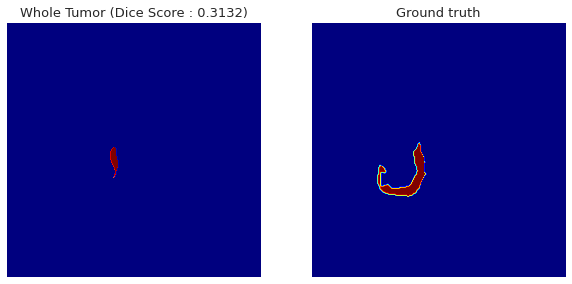

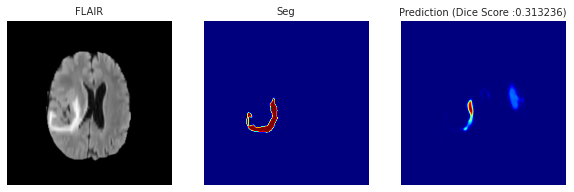

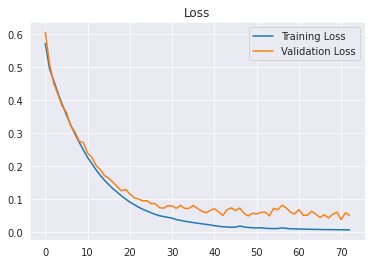

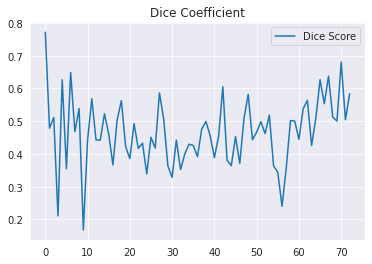

Training Epoch : [74/100]===============================================================================
Epoch: [74/100][0/20]	Time 0.684s (0.684s)	Speed 23.4 samples/s	Data 0.431s (0.431s)	Loss 0.00752 (0.00752)	
Epoch: [74/100][1/20]	Time 0.568s (0.626s)	Speed 28.2 samples/s	Data 0.395s (0.413s)	Loss 0.00721 (0.00737)	
Epoch: [74/100][2/20]	Time 0.591s (0.614s)	Speed 27.1 samples/s	Data 0.423s (0.417s)	Loss 0.00668 (0.00714)	
Epoch: [74/100][3/20]	Time 0.584s (0.607s)	Speed 27.4 samples/s	Data 0.417s (0.417s)	Loss 0.00636 (0.00694)	
Epoch: [74/100][4/20]	Time 0.608s (0.607s)	Speed 26.3 samples/s	Data 0.441s (0.422s)	Loss 0.00743 (0.00704)	
Epoch: [74/100][5/20]	Time 0.580s (0.603s)	Speed 27.6 samples/s	Data 0.413s (0.420s)	Loss 0.00826 (0.00724)	
Epoch: [74/100][6/20]	Time 0.569s (0.598s)	Speed 28.1 samples/s	Data 0.402s (0.418s)	Loss 0.00625 (0.00710)	
Epoch: [74/100][7/20]	Time 0.522s (0.588s)	Speed 30.7 samples/s	Data 0.354s (0.410s)	Loss 0.00650 (0.00703)	
Epoch: [74/100][8/20]	T

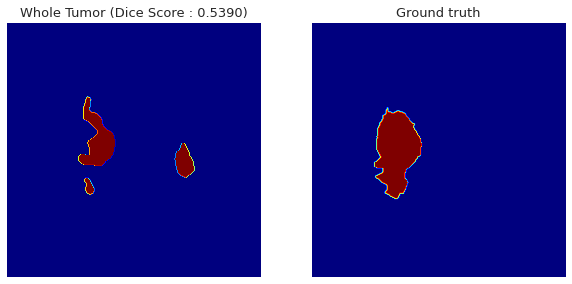

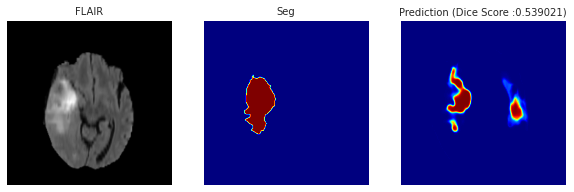

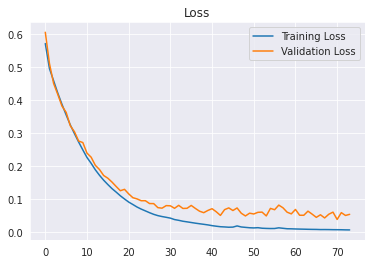

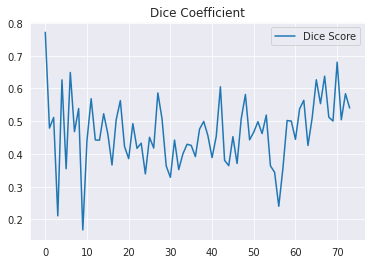

Training Epoch : [75/100]===============================================================================
Epoch: [75/100][0/20]	Time 0.702s (0.702s)	Speed 22.8 samples/s	Data 0.421s (0.421s)	Loss 0.00772 (0.00772)	
Epoch: [75/100][1/20]	Time 0.562s (0.632s)	Speed 28.5 samples/s	Data 0.395s (0.408s)	Loss 0.00672 (0.00722)	
Epoch: [75/100][2/20]	Time 0.546s (0.603s)	Speed 29.3 samples/s	Data 0.379s (0.398s)	Loss 0.00654 (0.00699)	
Epoch: [75/100][3/20]	Time 0.592s (0.600s)	Speed 27.0 samples/s	Data 0.426s (0.405s)	Loss 0.00758 (0.00714)	
Epoch: [75/100][4/20]	Time 0.549s (0.590s)	Speed 29.1 samples/s	Data 0.381s (0.400s)	Loss 0.00534 (0.00678)	
Epoch: [75/100][5/20]	Time 0.560s (0.585s)	Speed 28.6 samples/s	Data 0.394s (0.399s)	Loss 0.00787 (0.00696)	
Epoch: [75/100][6/20]	Time 0.526s (0.577s)	Speed 30.4 samples/s	Data 0.359s (0.394s)	Loss 0.00520 (0.00671)	
Epoch: [75/100][7/20]	Time 0.560s (0.575s)	Speed 28.6 samples/s	Data 0.393s (0.394s)	Loss 0.00636 (0.00667)	
Epoch: [75/100][8/20]	T

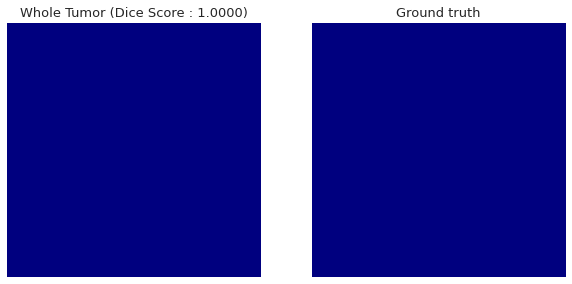

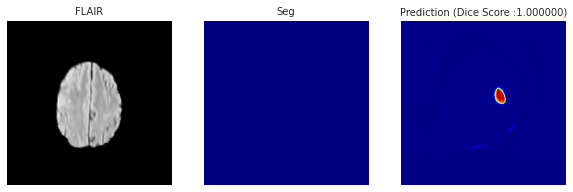

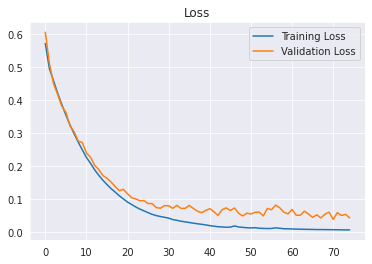

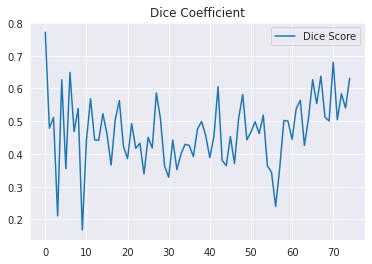

Training Epoch : [76/100]===============================================================================
Epoch: [76/100][0/20]	Time 0.762s (0.762s)	Speed 21.0 samples/s	Data 0.472s (0.472s)	Loss 0.00664 (0.00664)	
Epoch: [76/100][1/20]	Time 0.587s (0.674s)	Speed 27.3 samples/s	Data 0.419s (0.446s)	Loss 0.00645 (0.00655)	
Epoch: [76/100][2/20]	Time 0.528s (0.626s)	Speed 30.3 samples/s	Data 0.362s (0.418s)	Loss 0.00717 (0.00675)	
Epoch: [76/100][3/20]	Time 0.618s (0.624s)	Speed 25.9 samples/s	Data 0.451s (0.426s)	Loss 0.00756 (0.00695)	
Epoch: [76/100][4/20]	Time 0.574s (0.614s)	Speed 27.9 samples/s	Data 0.407s (0.422s)	Loss 0.00771 (0.00711)	
Epoch: [76/100][5/20]	Time 0.559s (0.605s)	Speed 28.6 samples/s	Data 0.391s (0.417s)	Loss 0.00611 (0.00694)	
Epoch: [76/100][6/20]	Time 0.594s (0.603s)	Speed 26.9 samples/s	Data 0.427s (0.419s)	Loss 0.00572 (0.00676)	
Epoch: [76/100][7/20]	Time 0.590s (0.601s)	Speed 27.1 samples/s	Data 0.422s (0.419s)	Loss 0.00682 (0.00677)	
Epoch: [76/100][8/20]	T

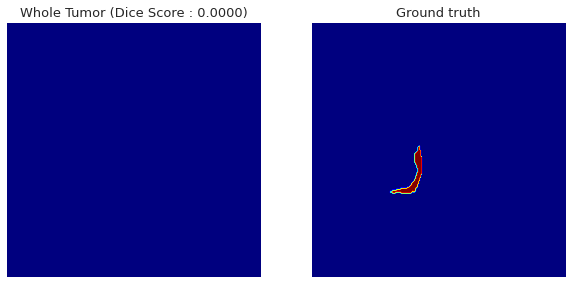

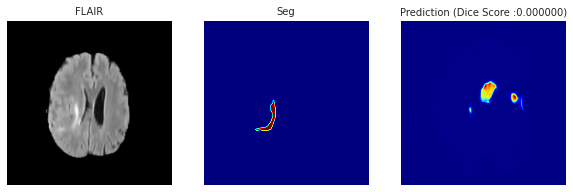

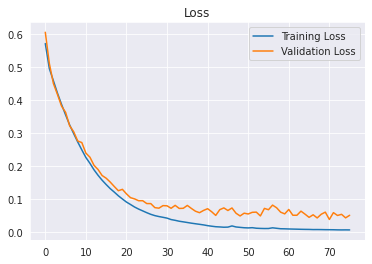

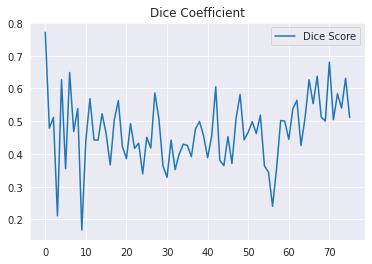

Training Epoch : [77/100]===============================================================================
Epoch: [77/100][0/20]	Time 0.639s (0.639s)	Speed 25.0 samples/s	Data 0.394s (0.394s)	Loss 0.00642 (0.00642)	
Epoch: [77/100][1/20]	Time 0.572s (0.606s)	Speed 28.0 samples/s	Data 0.397s (0.395s)	Loss 0.00724 (0.00683)	
Epoch: [77/100][2/20]	Time 0.562s (0.591s)	Speed 28.4 samples/s	Data 0.396s (0.396s)	Loss 0.00604 (0.00657)	
Epoch: [77/100][3/20]	Time 0.604s (0.595s)	Speed 26.5 samples/s	Data 0.439s (0.406s)	Loss 0.00581 (0.00638)	
Epoch: [77/100][4/20]	Time 0.567s (0.589s)	Speed 28.2 samples/s	Data 0.401s (0.405s)	Loss 0.00585 (0.00627)	
Epoch: [77/100][5/20]	Time 0.558s (0.584s)	Speed 28.7 samples/s	Data 0.391s (0.403s)	Loss 0.00686 (0.00637)	
Epoch: [77/100][6/20]	Time 0.523s (0.575s)	Speed 30.6 samples/s	Data 0.356s (0.396s)	Loss 0.00658 (0.00640)	
Epoch: [77/100][7/20]	Time 0.540s (0.571s)	Speed 29.6 samples/s	Data 0.373s (0.393s)	Loss 0.00575 (0.00632)	
Epoch: [77/100][8/20]	T

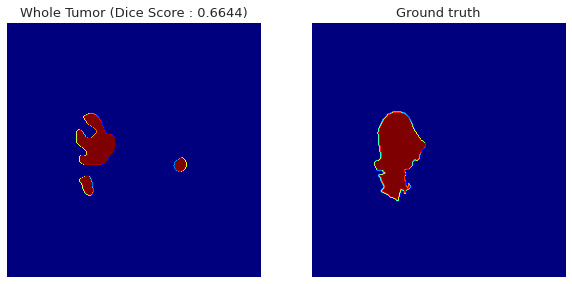

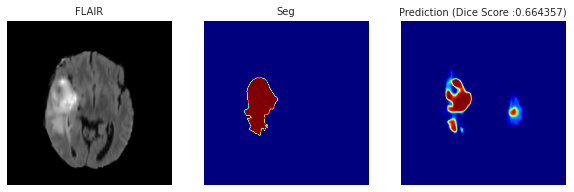

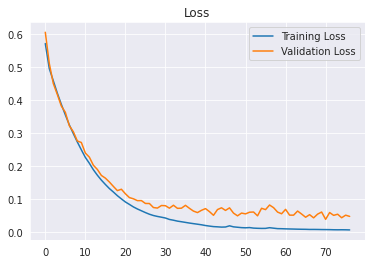

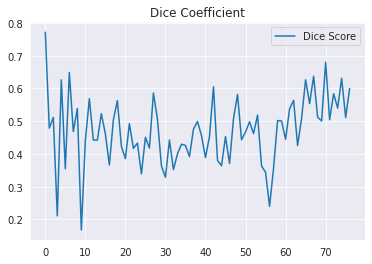

Training Epoch : [78/100]===============================================================================
Epoch: [78/100][0/20]	Time 0.706s (0.706s)	Speed 22.7 samples/s	Data 0.461s (0.461s)	Loss 0.00614 (0.00614)	
Epoch: [78/100][1/20]	Time 0.547s (0.626s)	Speed 29.2 samples/s	Data 0.371s (0.416s)	Loss 0.00645 (0.00630)	
Epoch: [78/100][2/20]	Time 0.589s (0.614s)	Speed 27.2 samples/s	Data 0.421s (0.418s)	Loss 0.00618 (0.00626)	
Epoch: [78/100][3/20]	Time 0.606s (0.612s)	Speed 26.4 samples/s	Data 0.438s (0.423s)	Loss 0.00709 (0.00647)	
Epoch: [78/100][4/20]	Time 0.539s (0.598s)	Speed 29.7 samples/s	Data 0.372s (0.413s)	Loss 0.00714 (0.00660)	
Epoch: [78/100][5/20]	Time 0.605s (0.599s)	Speed 26.4 samples/s	Data 0.439s (0.417s)	Loss 0.00587 (0.00648)	
Epoch: [78/100][6/20]	Time 0.614s (0.601s)	Speed 26.0 samples/s	Data 0.446s (0.421s)	Loss 0.00876 (0.00681)	
Epoch: [78/100][7/20]	Time 0.549s (0.595s)	Speed 29.1 samples/s	Data 0.381s (0.416s)	Loss 0.00932 (0.00712)	
Epoch: [78/100][8/20]	T

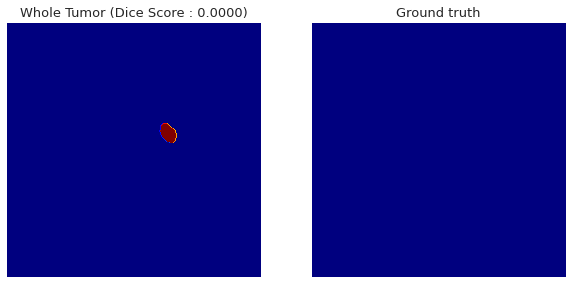

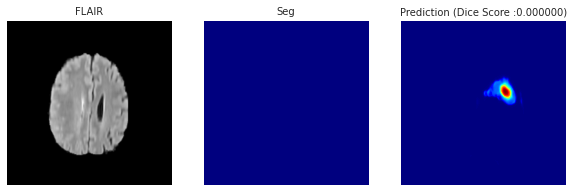

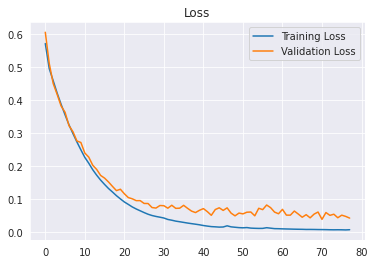

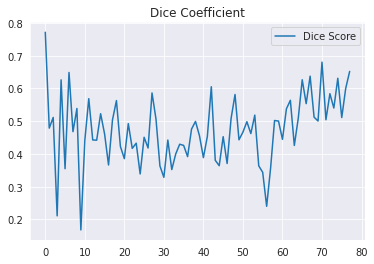

Training Epoch : [79/100]===============================================================================
Epoch: [79/100][0/20]	Time 0.675s (0.675s)	Speed 23.7 samples/s	Data 0.394s (0.394s)	Loss 0.00736 (0.00736)	
Epoch: [79/100][1/20]	Time 0.562s (0.619s)	Speed 28.5 samples/s	Data 0.395s (0.395s)	Loss 0.00582 (0.00659)	
Epoch: [79/100][2/20]	Time 0.620s (0.619s)	Speed 25.8 samples/s	Data 0.452s (0.414s)	Loss 0.00974 (0.00764)	
Epoch: [79/100][3/20]	Time 0.545s (0.601s)	Speed 29.4 samples/s	Data 0.375s (0.404s)	Loss 0.00705 (0.00750)	
Epoch: [79/100][4/20]	Time 0.593s (0.599s)	Speed 27.0 samples/s	Data 0.426s (0.409s)	Loss 0.00748 (0.00749)	
Epoch: [79/100][5/20]	Time 0.616s (0.602s)	Speed 26.0 samples/s	Data 0.449s (0.415s)	Loss 0.00806 (0.00759)	
Epoch: [79/100][6/20]	Time 0.584s (0.599s)	Speed 27.4 samples/s	Data 0.416s (0.415s)	Loss 0.00675 (0.00747)	
Epoch: [79/100][7/20]	Time 0.586s (0.598s)	Speed 27.3 samples/s	Data 0.418s (0.416s)	Loss 0.00577 (0.00725)	
Epoch: [79/100][8/20]	T

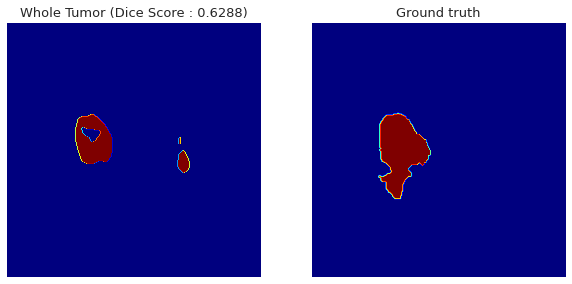

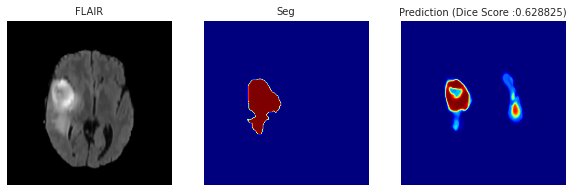

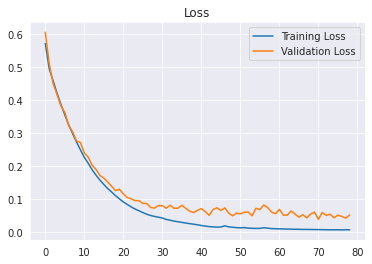

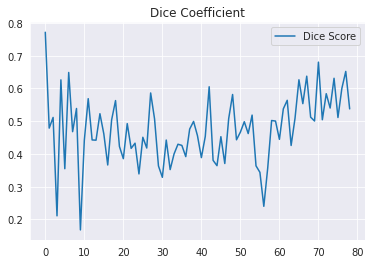

Training Epoch : [80/100]===============================================================================
Epoch: [80/100][0/20]	Time 0.725s (0.725s)	Speed 22.1 samples/s	Data 0.478s (0.478s)	Loss 0.00566 (0.00566)	
Epoch: [80/100][1/20]	Time 0.556s (0.641s)	Speed 28.8 samples/s	Data 0.384s (0.431s)	Loss 0.00534 (0.00550)	
Epoch: [80/100][2/20]	Time 0.568s (0.617s)	Speed 28.2 samples/s	Data 0.401s (0.421s)	Loss 0.00609 (0.00569)	
Epoch: [80/100][3/20]	Time 0.535s (0.596s)	Speed 29.9 samples/s	Data 0.369s (0.408s)	Loss 0.00702 (0.00603)	
Epoch: [80/100][4/20]	Time 0.540s (0.585s)	Speed 29.6 samples/s	Data 0.373s (0.401s)	Loss 0.00738 (0.00630)	
Epoch: [80/100][5/20]	Time 0.569s (0.582s)	Speed 28.1 samples/s	Data 0.401s (0.401s)	Loss 0.00687 (0.00639)	
Epoch: [80/100][6/20]	Time 0.560s (0.579s)	Speed 28.6 samples/s	Data 0.392s (0.400s)	Loss 0.00545 (0.00626)	
Epoch: [80/100][7/20]	Time 0.567s (0.578s)	Speed 28.2 samples/s	Data 0.395s (0.399s)	Loss 0.00848 (0.00653)	
Epoch: [80/100][8/20]	T

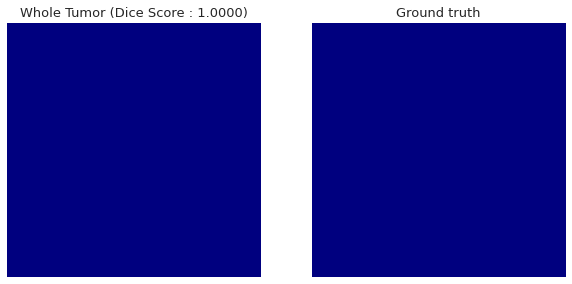

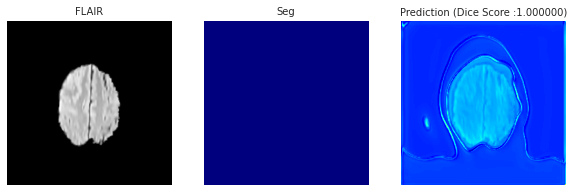

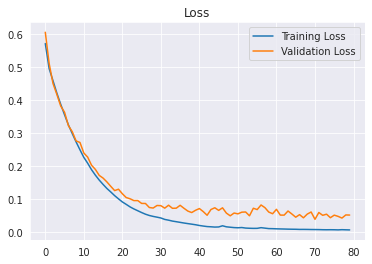

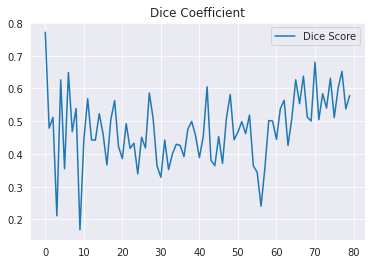

Training Epoch : [81/100]===============================================================================
Epoch: [81/100][0/20]	Time 0.733s (0.733s)	Speed 21.8 samples/s	Data 0.463s (0.463s)	Loss 0.00528 (0.00528)	
Epoch: [81/100][1/20]	Time 0.584s (0.658s)	Speed 27.4 samples/s	Data 0.410s (0.437s)	Loss 0.00531 (0.00530)	
Epoch: [81/100][2/20]	Time 0.612s (0.643s)	Speed 26.1 samples/s	Data 0.446s (0.440s)	Loss 0.00349 (0.00469)	
Epoch: [81/100][3/20]	Time 0.591s (0.630s)	Speed 27.1 samples/s	Data 0.425s (0.436s)	Loss 0.00669 (0.00519)	
Epoch: [81/100][4/20]	Time 0.588s (0.621s)	Speed 27.2 samples/s	Data 0.421s (0.433s)	Loss 0.00576 (0.00531)	
Epoch: [81/100][5/20]	Time 0.562s (0.612s)	Speed 28.5 samples/s	Data 0.396s (0.427s)	Loss 0.00669 (0.00554)	
Epoch: [81/100][6/20]	Time 0.546s (0.602s)	Speed 29.3 samples/s	Data 0.379s (0.420s)	Loss 0.00762 (0.00583)	
Epoch: [81/100][7/20]	Time 0.628s (0.606s)	Speed 25.5 samples/s	Data 0.462s (0.425s)	Loss 0.00630 (0.00589)	
Epoch: [81/100][8/20]	T

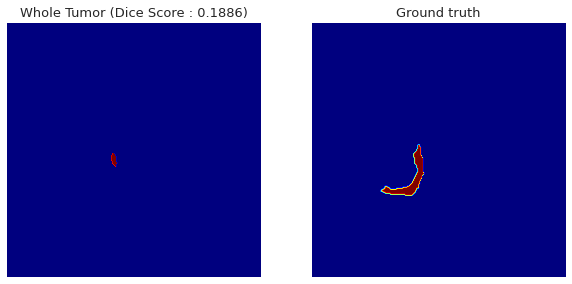

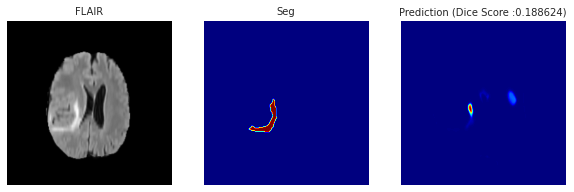

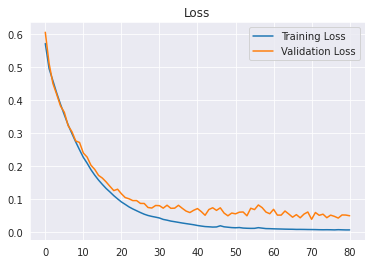

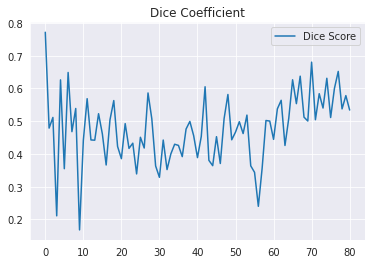

Training Epoch : [82/100]===============================================================================
Epoch: [82/100][0/20]	Time 0.746s (0.746s)	Speed 21.5 samples/s	Data 0.462s (0.462s)	Loss 0.00640 (0.00640)	
Epoch: [82/100][1/20]	Time 0.566s (0.656s)	Speed 28.3 samples/s	Data 0.399s (0.431s)	Loss 0.00750 (0.00695)	
Epoch: [82/100][2/20]	Time 0.587s (0.633s)	Speed 27.3 samples/s	Data 0.419s (0.427s)	Loss 0.00497 (0.00629)	
Epoch: [82/100][3/20]	Time 0.588s (0.622s)	Speed 27.2 samples/s	Data 0.420s (0.425s)	Loss 0.00624 (0.00628)	
Epoch: [82/100][4/20]	Time 0.576s (0.612s)	Speed 27.8 samples/s	Data 0.404s (0.421s)	Loss 0.00602 (0.00623)	
Epoch: [82/100][5/20]	Time 0.561s (0.604s)	Speed 28.5 samples/s	Data 0.394s (0.416s)	Loss 0.00817 (0.00655)	
Epoch: [82/100][6/20]	Time 0.577s (0.600s)	Speed 27.8 samples/s	Data 0.410s (0.416s)	Loss 0.00687 (0.00660)	
Epoch: [82/100][7/20]	Time 0.559s (0.595s)	Speed 28.6 samples/s	Data 0.394s (0.413s)	Loss 0.00622 (0.00655)	
Epoch: [82/100][8/20]	T

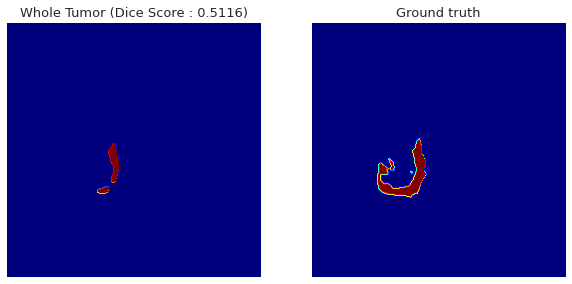

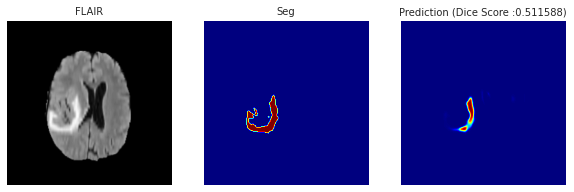

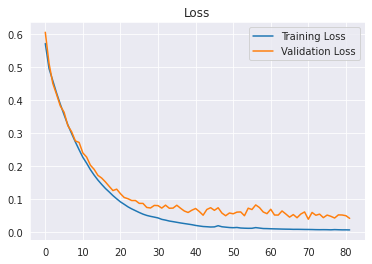

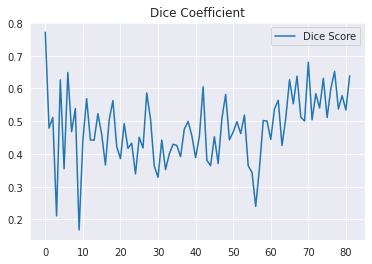

Training Epoch : [83/100]===============================================================================
Epoch: [83/100][0/20]	Time 0.728s (0.728s)	Speed 22.0 samples/s	Data 0.477s (0.477s)	Loss 0.00585 (0.00585)	
Epoch: [83/100][1/20]	Time 0.563s (0.646s)	Speed 28.4 samples/s	Data 0.395s (0.436s)	Loss 0.00679 (0.00632)	
Epoch: [83/100][2/20]	Time 0.551s (0.614s)	Speed 29.0 samples/s	Data 0.384s (0.418s)	Loss 0.00632 (0.00632)	
Epoch: [83/100][3/20]	Time 0.572s (0.603s)	Speed 28.0 samples/s	Data 0.406s (0.415s)	Loss 0.00596 (0.00623)	
Epoch: [83/100][4/20]	Time 0.577s (0.598s)	Speed 27.7 samples/s	Data 0.410s (0.414s)	Loss 0.00849 (0.00668)	
Epoch: [83/100][5/20]	Time 0.589s (0.597s)	Speed 27.2 samples/s	Data 0.420s (0.415s)	Loss 0.00519 (0.00644)	
Epoch: [83/100][6/20]	Time 0.591s (0.596s)	Speed 27.1 samples/s	Data 0.423s (0.416s)	Loss 0.00644 (0.00644)	
Epoch: [83/100][7/20]	Time 0.556s (0.591s)	Speed 28.8 samples/s	Data 0.387s (0.413s)	Loss 0.00536 (0.00630)	
Epoch: [83/100][8/20]	T

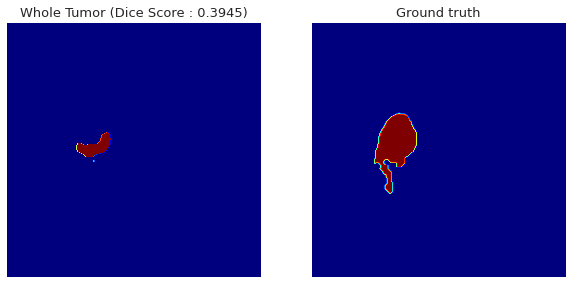

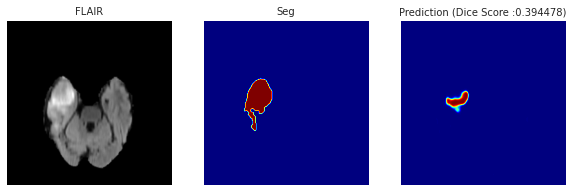

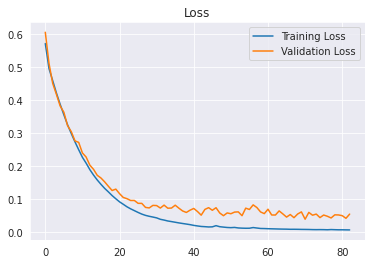

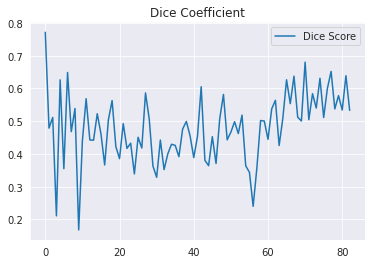

Training Epoch : [84/100]===============================================================================
Epoch: [84/100][0/20]	Time 0.729s (0.729s)	Speed 22.0 samples/s	Data 0.443s (0.443s)	Loss 0.00535 (0.00535)	
Epoch: [84/100][1/20]	Time 0.573s (0.651s)	Speed 27.9 samples/s	Data 0.406s (0.425s)	Loss 0.00529 (0.00532)	
Epoch: [84/100][2/20]	Time 0.561s (0.621s)	Speed 28.5 samples/s	Data 0.393s (0.414s)	Loss 0.00581 (0.00548)	
Epoch: [84/100][3/20]	Time 0.597s (0.615s)	Speed 26.8 samples/s	Data 0.430s (0.418s)	Loss 0.00644 (0.00572)	
Epoch: [84/100][4/20]	Time 0.592s (0.611s)	Speed 27.0 samples/s	Data 0.426s (0.420s)	Loss 0.00680 (0.00594)	
Epoch: [84/100][5/20]	Time 0.586s (0.606s)	Speed 27.3 samples/s	Data 0.419s (0.420s)	Loss 0.00779 (0.00625)	
Epoch: [84/100][6/20]	Time 0.571s (0.601s)	Speed 28.0 samples/s	Data 0.404s (0.417s)	Loss 0.00407 (0.00594)	
Epoch: [84/100][7/20]	Time 0.563s (0.597s)	Speed 28.4 samples/s	Data 0.396s (0.415s)	Loss 0.00614 (0.00596)	
Epoch: [84/100][8/20]	T

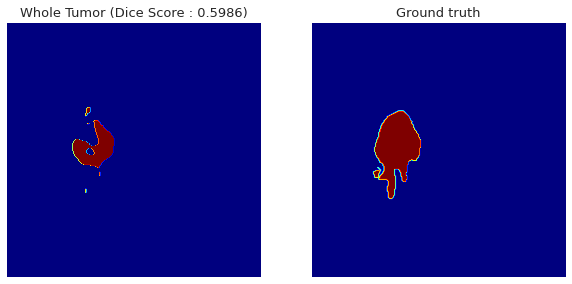

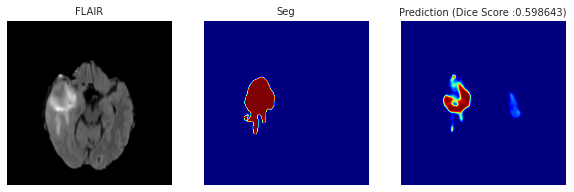

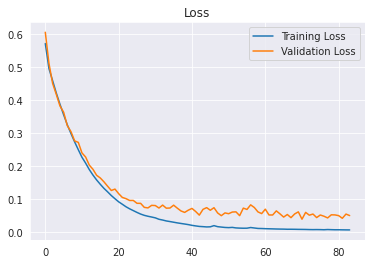

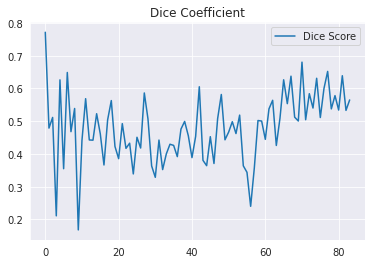

Training Epoch : [85/100]===============================================================================
Epoch: [85/100][0/20]	Time 0.693s (0.693s)	Speed 23.1 samples/s	Data 0.444s (0.444s)	Loss 0.00513 (0.00513)	
Epoch: [85/100][1/20]	Time 0.564s (0.629s)	Speed 28.4 samples/s	Data 0.390s (0.417s)	Loss 0.00448 (0.00480)	
Epoch: [85/100][2/20]	Time 0.623s (0.627s)	Speed 25.7 samples/s	Data 0.456s (0.430s)	Loss 0.00586 (0.00516)	
Epoch: [85/100][3/20]	Time 0.586s (0.617s)	Speed 27.3 samples/s	Data 0.418s (0.427s)	Loss 0.00693 (0.00560)	
Epoch: [85/100][4/20]	Time 0.575s (0.608s)	Speed 27.8 samples/s	Data 0.409s (0.423s)	Loss 0.00469 (0.00542)	
Epoch: [85/100][5/20]	Time 0.601s (0.607s)	Speed 26.6 samples/s	Data 0.436s (0.425s)	Loss 0.00428 (0.00523)	
Epoch: [85/100][6/20]	Time 0.559s (0.600s)	Speed 28.6 samples/s	Data 0.392s (0.421s)	Loss 0.00427 (0.00509)	
Epoch: [85/100][7/20]	Time 0.578s (0.597s)	Speed 27.7 samples/s	Data 0.410s (0.419s)	Loss 0.00620 (0.00523)	
Epoch: [85/100][8/20]	T

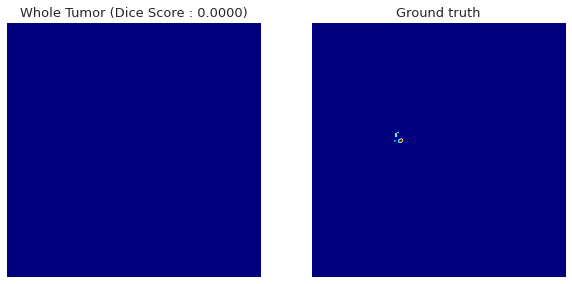

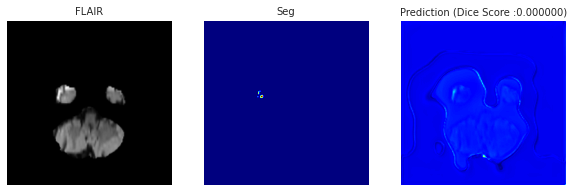

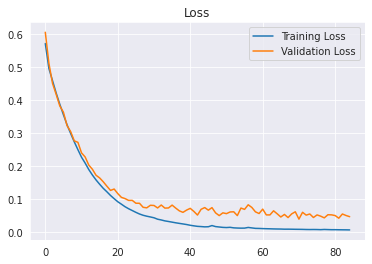

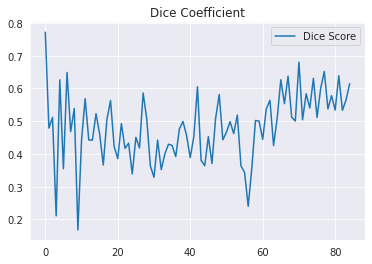

Training Epoch : [86/100]===============================================================================
Epoch: [86/100][0/20]	Time 0.767s (0.767s)	Speed 20.9 samples/s	Data 0.503s (0.503s)	Loss 0.00463 (0.00463)	
Epoch: [86/100][1/20]	Time 0.596s (0.681s)	Speed 26.9 samples/s	Data 0.428s (0.465s)	Loss 0.00546 (0.00505)	
Epoch: [86/100][2/20]	Time 0.569s (0.644s)	Speed 28.1 samples/s	Data 0.401s (0.444s)	Loss 0.00557 (0.00522)	
Epoch: [86/100][3/20]	Time 0.589s (0.630s)	Speed 27.1 samples/s	Data 0.422s (0.438s)	Loss 0.00519 (0.00521)	
Epoch: [86/100][4/20]	Time 0.563s (0.617s)	Speed 28.4 samples/s	Data 0.396s (0.430s)	Loss 0.00465 (0.00510)	
Epoch: [86/100][5/20]	Time 0.623s (0.618s)	Speed 25.7 samples/s	Data 0.456s (0.434s)	Loss 0.00555 (0.00518)	
Epoch: [86/100][6/20]	Time 0.612s (0.617s)	Speed 26.1 samples/s	Data 0.446s (0.436s)	Loss 0.00450 (0.00508)	
Epoch: [86/100][7/20]	Time 0.588s (0.613s)	Speed 27.2 samples/s	Data 0.422s (0.434s)	Loss 0.00508 (0.00508)	
Epoch: [86/100][8/20]	T

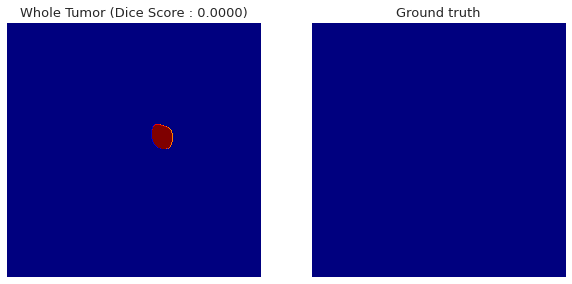

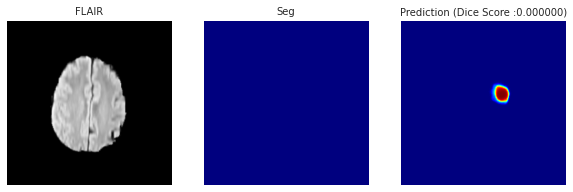

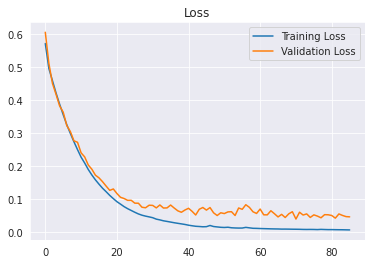

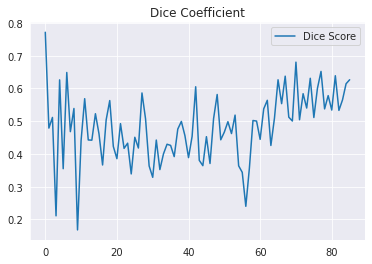

Training Epoch : [87/100]===============================================================================
Epoch: [87/100][0/20]	Time 0.722s (0.722s)	Speed 22.2 samples/s	Data 0.470s (0.470s)	Loss 0.00610 (0.00610)	
Epoch: [87/100][1/20]	Time 0.604s (0.663s)	Speed 26.5 samples/s	Data 0.435s (0.452s)	Loss 0.00468 (0.00539)	
Epoch: [87/100][2/20]	Time 0.585s (0.637s)	Speed 27.4 samples/s	Data 0.418s (0.441s)	Loss 0.00638 (0.00572)	
Epoch: [87/100][3/20]	Time 0.606s (0.629s)	Speed 26.4 samples/s	Data 0.439s (0.440s)	Loss 0.00614 (0.00582)	
Epoch: [87/100][4/20]	Time 0.605s (0.624s)	Speed 26.4 samples/s	Data 0.438s (0.440s)	Loss 0.00568 (0.00580)	
Epoch: [87/100][5/20]	Time 0.597s (0.620s)	Speed 26.8 samples/s	Data 0.430s (0.438s)	Loss 0.00629 (0.00588)	
Epoch: [87/100][6/20]	Time 0.594s (0.616s)	Speed 26.9 samples/s	Data 0.426s (0.437s)	Loss 0.00420 (0.00564)	
Epoch: [87/100][7/20]	Time 0.563s (0.610s)	Speed 28.4 samples/s	Data 0.395s (0.431s)	Loss 0.00440 (0.00548)	
Epoch: [87/100][8/20]	T

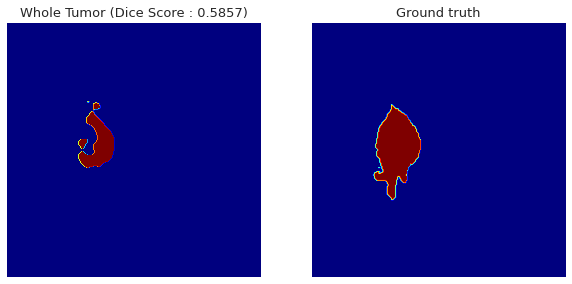

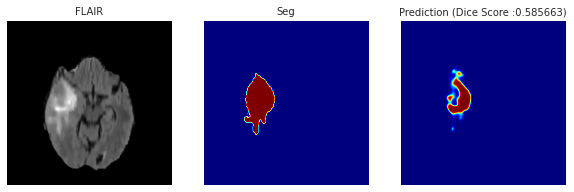

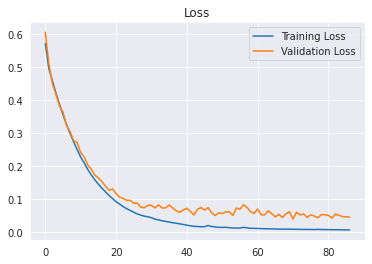

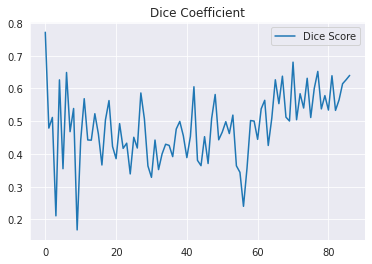

Training Epoch : [88/100]===============================================================================
Epoch: [88/100][0/20]	Time 0.759s (0.759s)	Speed 21.1 samples/s	Data 0.497s (0.497s)	Loss 0.00499 (0.00499)	
Epoch: [88/100][1/20]	Time 0.541s (0.650s)	Speed 29.6 samples/s	Data 0.373s (0.435s)	Loss 0.00384 (0.00442)	
Epoch: [88/100][2/20]	Time 0.605s (0.635s)	Speed 26.5 samples/s	Data 0.438s (0.436s)	Loss 0.00531 (0.00471)	
Epoch: [88/100][3/20]	Time 0.586s (0.623s)	Speed 27.3 samples/s	Data 0.419s (0.432s)	Loss 0.00617 (0.00508)	
Epoch: [88/100][4/20]	Time 0.594s (0.617s)	Speed 26.9 samples/s	Data 0.427s (0.431s)	Loss 0.00608 (0.00528)	
Epoch: [88/100][5/20]	Time 0.584s (0.612s)	Speed 27.4 samples/s	Data 0.417s (0.429s)	Loss 0.00367 (0.00501)	
Epoch: [88/100][6/20]	Time 0.547s (0.602s)	Speed 29.3 samples/s	Data 0.380s (0.422s)	Loss 0.00736 (0.00535)	
Epoch: [88/100][7/20]	Time 0.568s (0.598s)	Speed 28.2 samples/s	Data 0.401s (0.419s)	Loss 0.00592 (0.00542)	
Epoch: [88/100][8/20]	T

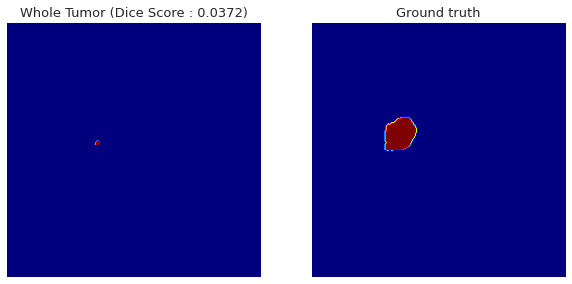

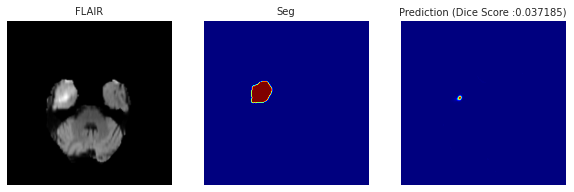

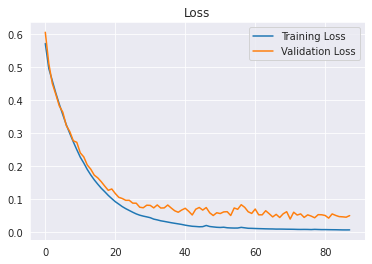

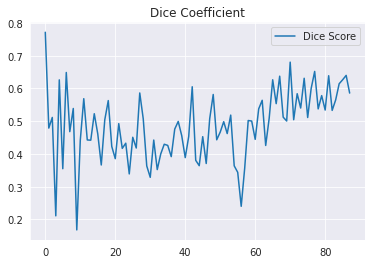

Training Epoch : [89/100]===============================================================================
Epoch: [89/100][0/20]	Time 0.709s (0.709s)	Speed 22.6 samples/s	Data 0.463s (0.463s)	Loss 0.00395 (0.00395)	
Epoch: [89/100][1/20]	Time 0.584s (0.646s)	Speed 27.4 samples/s	Data 0.405s (0.434s)	Loss 0.00635 (0.00515)	
Epoch: [89/100][2/20]	Time 0.547s (0.613s)	Speed 29.3 samples/s	Data 0.377s (0.415s)	Loss 0.00521 (0.00517)	
Epoch: [89/100][3/20]	Time 0.562s (0.600s)	Speed 28.5 samples/s	Data 0.393s (0.409s)	Loss 0.00438 (0.00497)	
Epoch: [89/100][4/20]	Time 0.533s (0.587s)	Speed 30.0 samples/s	Data 0.365s (0.400s)	Loss 0.00448 (0.00487)	
Epoch: [89/100][5/20]	Time 0.619s (0.592s)	Speed 25.8 samples/s	Data 0.451s (0.409s)	Loss 0.00528 (0.00494)	
Epoch: [89/100][6/20]	Time 0.565s (0.588s)	Speed 28.3 samples/s	Data 0.396s (0.407s)	Loss 0.00536 (0.00500)	
Epoch: [89/100][7/20]	Time 0.625s (0.593s)	Speed 25.6 samples/s	Data 0.455s (0.413s)	Loss 0.00638 (0.00517)	
Epoch: [89/100][8/20]	T

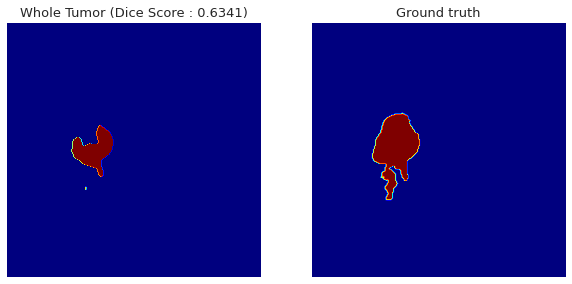

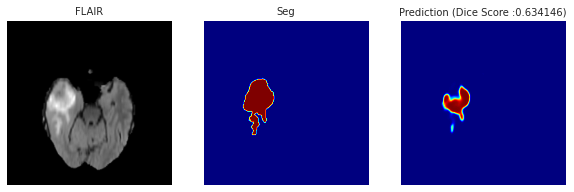

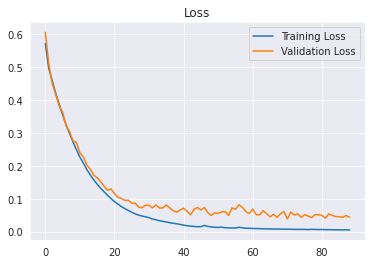

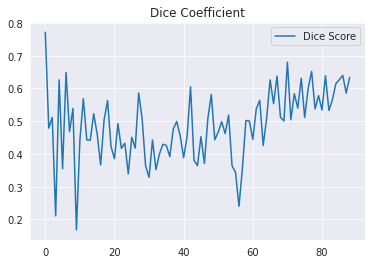

Training Epoch : [90/100]===============================================================================
Epoch: [90/100][0/20]	Time 0.700s (0.700s)	Speed 22.9 samples/s	Data 0.442s (0.442s)	Loss 0.00411 (0.00411)	
Epoch: [90/100][1/20]	Time 0.619s (0.659s)	Speed 25.9 samples/s	Data 0.449s (0.446s)	Loss 0.00483 (0.00447)	
Epoch: [90/100][2/20]	Time 0.560s (0.626s)	Speed 28.6 samples/s	Data 0.390s (0.427s)	Loss 0.00492 (0.00462)	
Epoch: [90/100][3/20]	Time 0.622s (0.625s)	Speed 25.7 samples/s	Data 0.452s (0.433s)	Loss 0.00579 (0.00491)	
Epoch: [90/100][4/20]	Time 0.581s (0.616s)	Speed 27.5 samples/s	Data 0.406s (0.428s)	Loss 0.00742 (0.00541)	
Epoch: [90/100][5/20]	Time 0.569s (0.608s)	Speed 28.1 samples/s	Data 0.398s (0.423s)	Loss 0.00647 (0.00559)	
Epoch: [90/100][6/20]	Time 0.571s (0.603s)	Speed 28.0 samples/s	Data 0.400s (0.420s)	Loss 0.00730 (0.00583)	
Epoch: [90/100][7/20]	Time 0.550s (0.596s)	Speed 29.1 samples/s	Data 0.380s (0.415s)	Loss 0.00661 (0.00593)	
Epoch: [90/100][8/20]	T

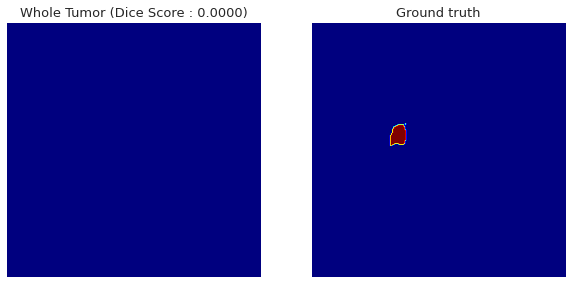

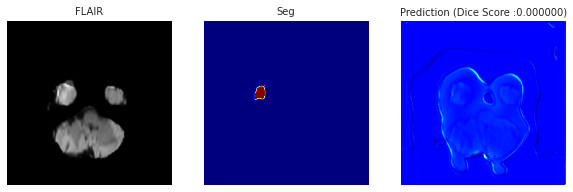

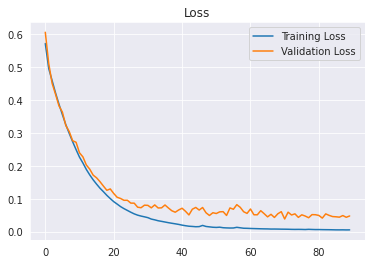

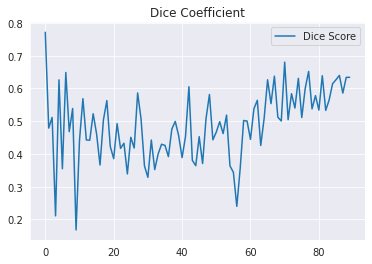

Training Epoch : [91/100]===============================================================================
Epoch: [91/100][0/20]	Time 0.735s (0.735s)	Speed 21.8 samples/s	Data 0.474s (0.474s)	Loss 0.00311 (0.00311)	
Epoch: [91/100][1/20]	Time 0.634s (0.685s)	Speed 25.2 samples/s	Data 0.464s (0.469s)	Loss 0.00841 (0.00576)	
Epoch: [91/100][2/20]	Time 0.598s (0.656s)	Speed 26.7 samples/s	Data 0.427s (0.455s)	Loss 0.00375 (0.00509)	
Epoch: [91/100][3/20]	Time 0.548s (0.629s)	Speed 29.2 samples/s	Data 0.378s (0.436s)	Loss 0.00518 (0.00511)	
Epoch: [91/100][4/20]	Time 0.597s (0.623s)	Speed 26.8 samples/s	Data 0.424s (0.434s)	Loss 0.00610 (0.00531)	
Epoch: [91/100][5/20]	Time 0.578s (0.615s)	Speed 27.7 samples/s	Data 0.407s (0.429s)	Loss 0.00561 (0.00536)	
Epoch: [91/100][6/20]	Time 0.637s (0.618s)	Speed 25.1 samples/s	Data 0.464s (0.434s)	Loss 0.00629 (0.00549)	
Epoch: [91/100][7/20]	Time 0.634s (0.620s)	Speed 25.2 samples/s	Data 0.463s (0.438s)	Loss 0.00778 (0.00578)	
Epoch: [91/100][8/20]	T

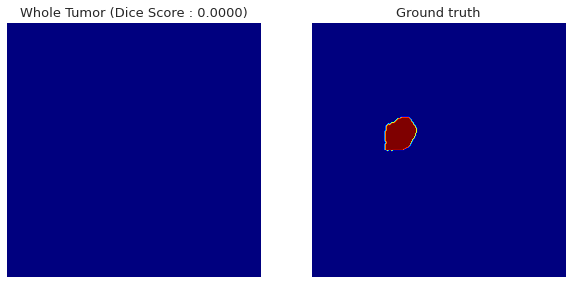

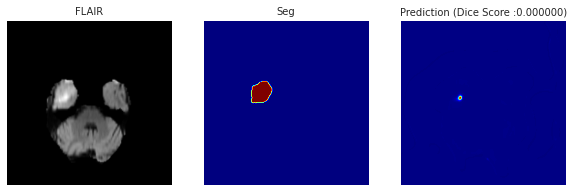

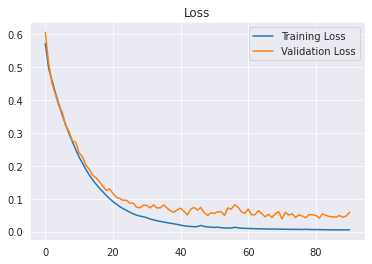

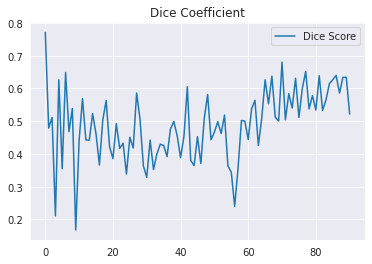

Training Epoch : [92/100]===============================================================================
Epoch: [92/100][0/20]	Time 0.744s (0.744s)	Speed 21.5 samples/s	Data 0.477s (0.477s)	Loss 0.00470 (0.00470)	
Epoch: [92/100][1/20]	Time 0.606s (0.675s)	Speed 26.4 samples/s	Data 0.435s (0.456s)	Loss 0.00447 (0.00458)	
Epoch: [92/100][2/20]	Time 0.604s (0.651s)	Speed 26.5 samples/s	Data 0.432s (0.448s)	Loss 0.00344 (0.00420)	
Epoch: [92/100][3/20]	Time 0.606s (0.640s)	Speed 26.4 samples/s	Data 0.434s (0.445s)	Loss 0.00417 (0.00419)	
Epoch: [92/100][4/20]	Time 0.608s (0.634s)	Speed 26.3 samples/s	Data 0.436s (0.443s)	Loss 0.00360 (0.00408)	
Epoch: [92/100][5/20]	Time 0.586s (0.626s)	Speed 27.3 samples/s	Data 0.413s (0.438s)	Loss 0.00512 (0.00425)	
Epoch: [92/100][6/20]	Time 0.602s (0.622s)	Speed 26.6 samples/s	Data 0.429s (0.437s)	Loss 0.00724 (0.00468)	
Epoch: [92/100][7/20]	Time 0.666s (0.628s)	Speed 24.0 samples/s	Data 0.494s (0.444s)	Loss 0.00571 (0.00481)	
Epoch: [92/100][8/20]	T

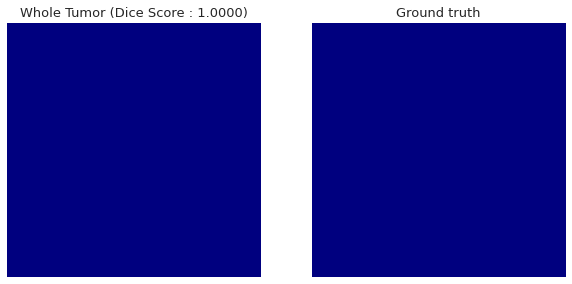

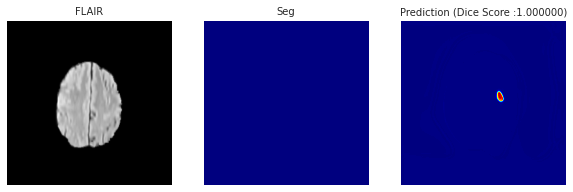

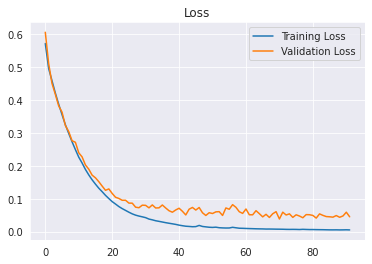

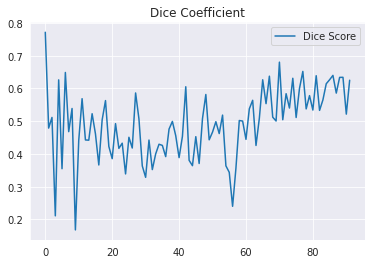

Training Epoch : [93/100]===============================================================================
Epoch: [93/100][0/20]	Time 0.828s (0.828s)	Speed 19.3 samples/s	Data 0.545s (0.545s)	Loss 0.00485 (0.00485)	
Epoch: [93/100][1/20]	Time 0.605s (0.717s)	Speed 26.4 samples/s	Data 0.431s (0.488s)	Loss 0.00457 (0.00471)	
Epoch: [93/100][2/20]	Time 0.612s (0.682s)	Speed 26.2 samples/s	Data 0.439s (0.472s)	Loss 0.00531 (0.00491)	
Epoch: [93/100][3/20]	Time 0.585s (0.657s)	Speed 27.4 samples/s	Data 0.411s (0.457s)	Loss 0.00609 (0.00521)	
Epoch: [93/100][4/20]	Time 0.586s (0.643s)	Speed 27.3 samples/s	Data 0.413s (0.448s)	Loss 0.00561 (0.00529)	
Epoch: [93/100][5/20]	Time 0.593s (0.635s)	Speed 27.0 samples/s	Data 0.419s (0.443s)	Loss 0.00540 (0.00531)	
Epoch: [93/100][6/20]	Time 0.612s (0.632s)	Speed 26.1 samples/s	Data 0.438s (0.443s)	Loss 0.00581 (0.00538)	
Epoch: [93/100][7/20]	Time 0.573s (0.624s)	Speed 27.9 samples/s	Data 0.400s (0.437s)	Loss 0.00572 (0.00542)	
Epoch: [93/100][8/20]	T

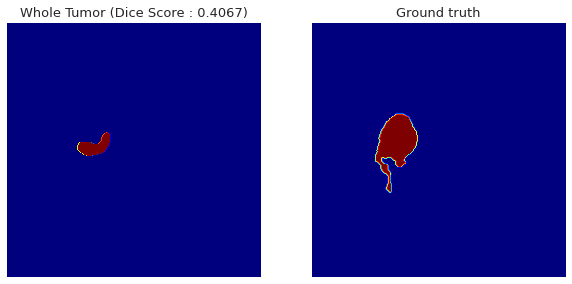

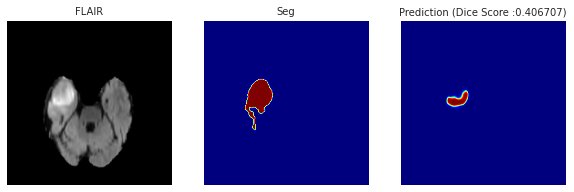

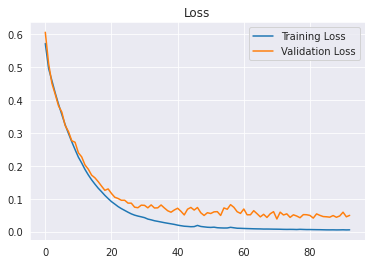

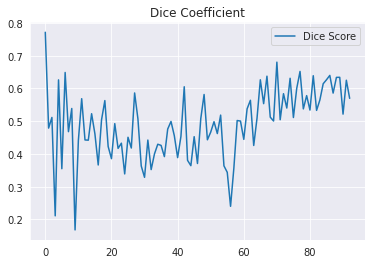

Training Epoch : [94/100]===============================================================================
Epoch: [94/100][0/20]	Time 0.710s (0.710s)	Speed 22.5 samples/s	Data 0.451s (0.451s)	Loss 0.00439 (0.00439)	
Epoch: [94/100][1/20]	Time 0.572s (0.641s)	Speed 28.0 samples/s	Data 0.398s (0.424s)	Loss 0.00335 (0.00387)	
Epoch: [94/100][2/20]	Time 0.582s (0.621s)	Speed 27.5 samples/s	Data 0.407s (0.419s)	Loss 0.00527 (0.00434)	
Epoch: [94/100][3/20]	Time 0.619s (0.621s)	Speed 25.9 samples/s	Data 0.447s (0.426s)	Loss 0.00439 (0.00435)	
Epoch: [94/100][4/20]	Time 0.610s (0.618s)	Speed 26.2 samples/s	Data 0.433s (0.427s)	Loss 0.00578 (0.00464)	
Epoch: [94/100][5/20]	Time 0.647s (0.623s)	Speed 24.7 samples/s	Data 0.474s (0.435s)	Loss 0.00505 (0.00471)	
Epoch: [94/100][6/20]	Time 0.595s (0.619s)	Speed 26.9 samples/s	Data 0.422s (0.433s)	Loss 0.00398 (0.00460)	
Epoch: [94/100][7/20]	Time 0.590s (0.616s)	Speed 27.1 samples/s	Data 0.417s (0.431s)	Loss 0.00664 (0.00486)	
Epoch: [94/100][8/20]	T

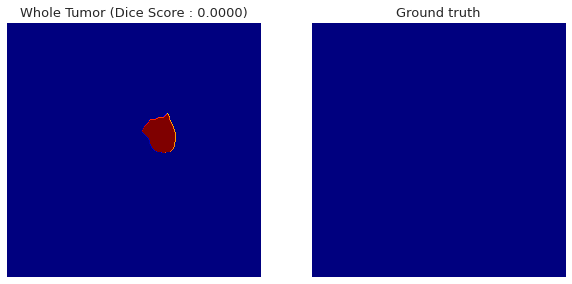

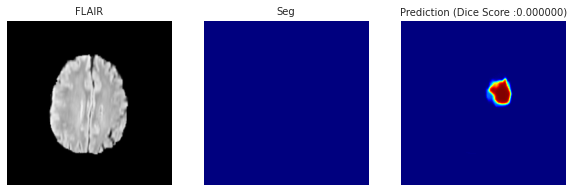

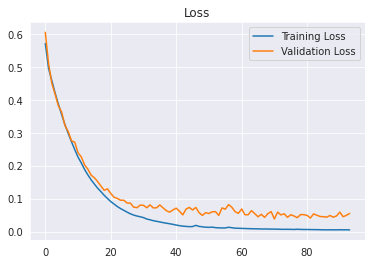

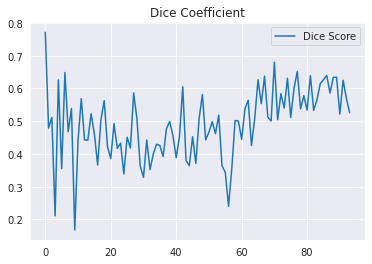

Training Epoch : [95/100]===============================================================================
Epoch: [95/100][0/20]	Time 0.682s (0.682s)	Speed 23.5 samples/s	Data 0.409s (0.409s)	Loss 0.00446 (0.00446)	
Epoch: [95/100][1/20]	Time 0.606s (0.644s)	Speed 26.4 samples/s	Data 0.431s (0.420s)	Loss 0.00524 (0.00485)	
Epoch: [95/100][2/20]	Time 0.608s (0.632s)	Speed 26.3 samples/s	Data 0.433s (0.424s)	Loss 0.00441 (0.00470)	
Epoch: [95/100][3/20]	Time 0.565s (0.615s)	Speed 28.3 samples/s	Data 0.391s (0.416s)	Loss 0.00536 (0.00486)	
Epoch: [95/100][4/20]	Time 0.624s (0.617s)	Speed 25.7 samples/s	Data 0.449s (0.423s)	Loss 0.00349 (0.00459)	
Epoch: [95/100][5/20]	Time 0.614s (0.616s)	Speed 26.0 samples/s	Data 0.439s (0.425s)	Loss 0.00621 (0.00486)	
Epoch: [95/100][6/20]	Time 0.585s (0.612s)	Speed 27.3 samples/s	Data 0.409s (0.423s)	Loss 0.00600 (0.00502)	
Epoch: [95/100][7/20]	Time 0.598s (0.610s)	Speed 26.8 samples/s	Data 0.422s (0.423s)	Loss 0.00394 (0.00489)	
Epoch: [95/100][8/20]	T

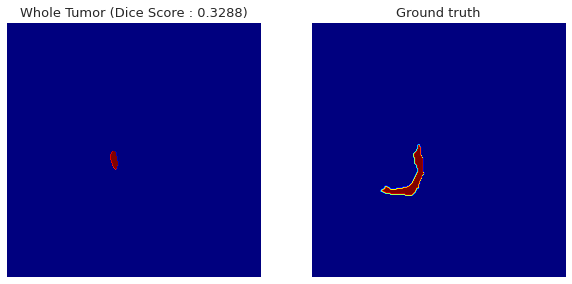

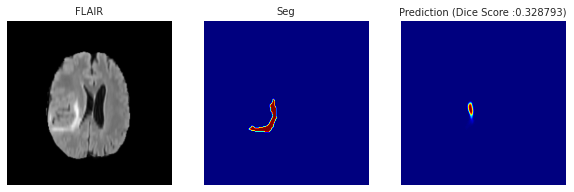

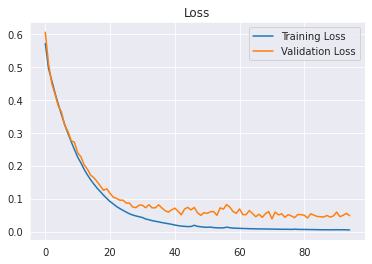

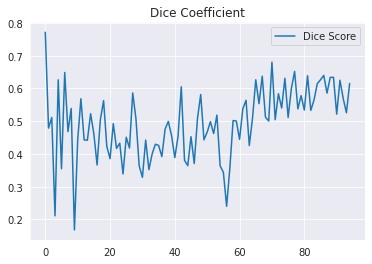

Training Epoch : [96/100]===============================================================================
Epoch: [96/100][0/20]	Time 0.743s (0.743s)	Speed 21.5 samples/s	Data 0.489s (0.489s)	Loss 0.00463 (0.00463)	
Epoch: [96/100][1/20]	Time 0.608s (0.675s)	Speed 26.3 samples/s	Data 0.429s (0.459s)	Loss 0.00518 (0.00490)	
Epoch: [96/100][2/20]	Time 0.638s (0.663s)	Speed 25.1 samples/s	Data 0.461s (0.459s)	Loss 0.00520 (0.00500)	
Epoch: [96/100][3/20]	Time 0.552s (0.635s)	Speed 29.0 samples/s	Data 0.374s (0.438s)	Loss 0.00528 (0.00507)	
Epoch: [96/100][4/20]	Time 0.621s (0.632s)	Speed 25.8 samples/s	Data 0.444s (0.439s)	Loss 0.00461 (0.00498)	
Epoch: [96/100][5/20]	Time 0.606s (0.628s)	Speed 26.4 samples/s	Data 0.429s (0.437s)	Loss 0.00448 (0.00490)	
Epoch: [96/100][6/20]	Time 0.641s (0.630s)	Speed 25.0 samples/s	Data 0.464s (0.441s)	Loss 0.00561 (0.00500)	
Epoch: [96/100][7/20]	Time 0.597s (0.626s)	Speed 26.8 samples/s	Data 0.421s (0.439s)	Loss 0.00504 (0.00501)	
Epoch: [96/100][8/20]	T

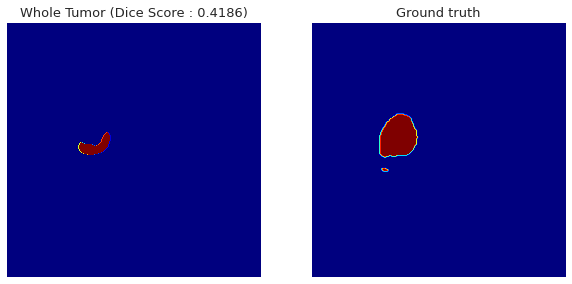

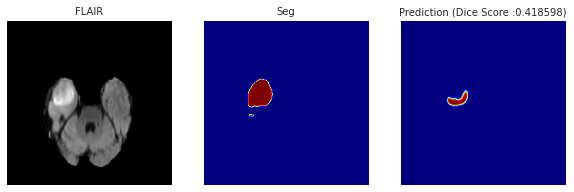

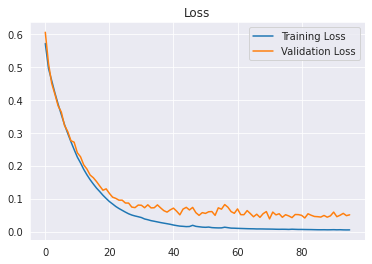

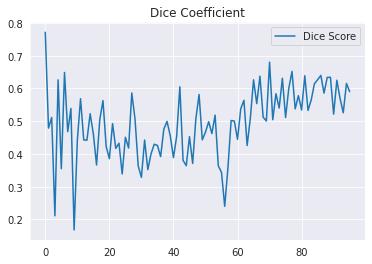

Training Epoch : [97/100]===============================================================================
Epoch: [97/100][0/20]	Time 0.743s (0.743s)	Speed 21.5 samples/s	Data 0.498s (0.498s)	Loss 0.00479 (0.00479)	
Epoch: [97/100][1/20]	Time 0.591s (0.667s)	Speed 27.1 samples/s	Data 0.412s (0.455s)	Loss 0.00510 (0.00495)	
Epoch: [97/100][2/20]	Time 0.621s (0.651s)	Speed 25.8 samples/s	Data 0.441s (0.451s)	Loss 0.00487 (0.00492)	
Epoch: [97/100][3/20]	Time 0.568s (0.630s)	Speed 28.2 samples/s	Data 0.389s (0.435s)	Loss 0.00525 (0.00500)	
Epoch: [97/100][4/20]	Time 0.586s (0.622s)	Speed 27.3 samples/s	Data 0.408s (0.430s)	Loss 0.00469 (0.00494)	
Epoch: [97/100][5/20]	Time 0.616s (0.621s)	Speed 26.0 samples/s	Data 0.437s (0.431s)	Loss 0.00432 (0.00484)	
Epoch: [97/100][6/20]	Time 0.558s (0.612s)	Speed 28.7 samples/s	Data 0.372s (0.423s)	Loss 0.00449 (0.00479)	
Epoch: [97/100][7/20]	Time 0.610s (0.612s)	Speed 26.2 samples/s	Data 0.431s (0.424s)	Loss 0.00348 (0.00463)	
Epoch: [97/100][8/20]	T

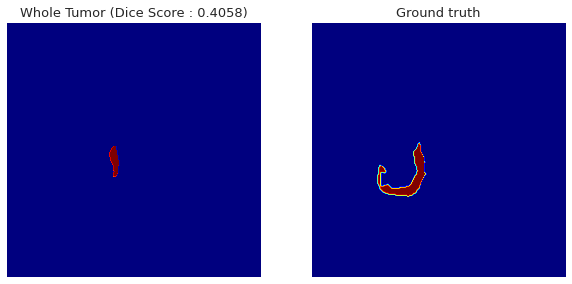

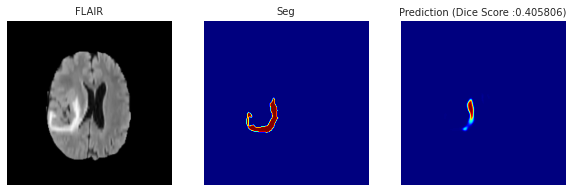

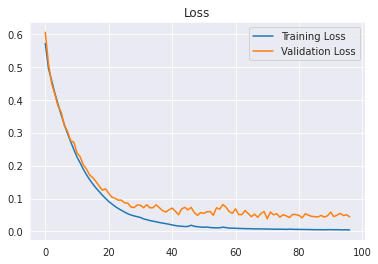

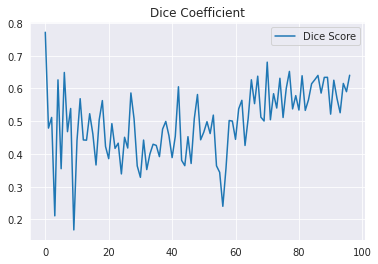

Training Epoch : [98/100]===============================================================================
Epoch: [98/100][0/20]	Time 0.691s (0.691s)	Speed 23.2 samples/s	Data 0.426s (0.426s)	Loss 0.00606 (0.00606)	
Epoch: [98/100][1/20]	Time 0.607s (0.649s)	Speed 26.4 samples/s	Data 0.428s (0.427s)	Loss 0.00532 (0.00569)	
Epoch: [98/100][2/20]	Time 0.632s (0.643s)	Speed 25.3 samples/s	Data 0.450s (0.435s)	Loss 0.00469 (0.00536)	
Epoch: [98/100][3/20]	Time 0.646s (0.644s)	Speed 24.8 samples/s	Data 0.466s (0.442s)	Loss 0.00519 (0.00532)	
Epoch: [98/100][4/20]	Time 0.614s (0.638s)	Speed 26.0 samples/s	Data 0.435s (0.441s)	Loss 0.00598 (0.00545)	
Epoch: [98/100][5/20]	Time 0.599s (0.632s)	Speed 26.7 samples/s	Data 0.419s (0.437s)	Loss 0.00560 (0.00547)	
Epoch: [98/100][6/20]	Time 0.583s (0.625s)	Speed 27.4 samples/s	Data 0.402s (0.432s)	Loss 0.00490 (0.00539)	
Epoch: [98/100][7/20]	Time 0.540s (0.614s)	Speed 29.6 samples/s	Data 0.354s (0.422s)	Loss 0.00608 (0.00548)	
Epoch: [98/100][8/20]	T

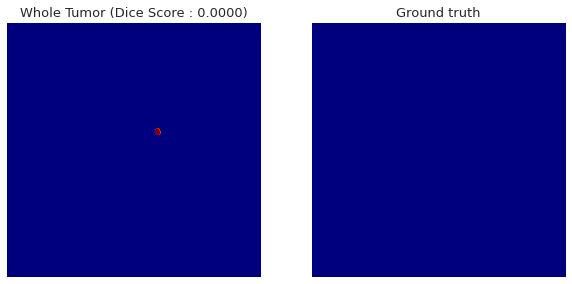

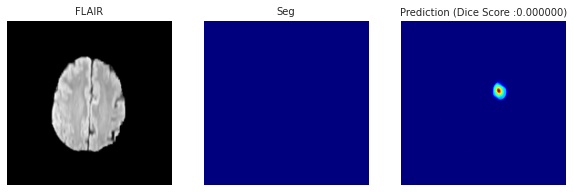

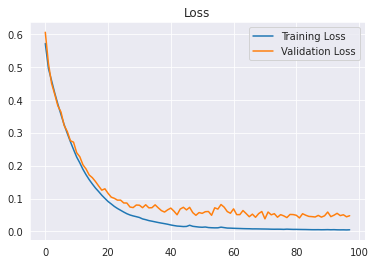

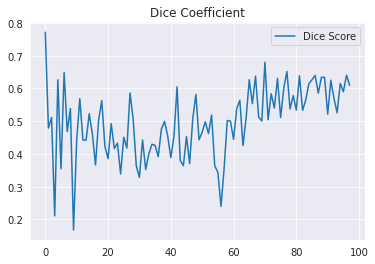

Training Epoch : [99/100]===============================================================================
Epoch: [99/100][0/20]	Time 0.771s (0.771s)	Speed 20.8 samples/s	Data 0.519s (0.519s)	Loss 0.00442 (0.00442)	
Epoch: [99/100][1/20]	Time 0.624s (0.697s)	Speed 25.7 samples/s	Data 0.444s (0.482s)	Loss 0.00378 (0.00410)	
Epoch: [99/100][2/20]	Time 0.594s (0.663s)	Speed 26.9 samples/s	Data 0.417s (0.460s)	Loss 0.00381 (0.00401)	
Epoch: [99/100][3/20]	Time 0.636s (0.656s)	Speed 25.2 samples/s	Data 0.456s (0.459s)	Loss 0.00546 (0.00437)	
Epoch: [99/100][4/20]	Time 0.621s (0.649s)	Speed 25.8 samples/s	Data 0.442s (0.456s)	Loss 0.00489 (0.00447)	
Epoch: [99/100][5/20]	Time 0.616s (0.643s)	Speed 26.0 samples/s	Data 0.436s (0.452s)	Loss 0.00537 (0.00462)	
Epoch: [99/100][6/20]	Time 0.648s (0.644s)	Speed 24.7 samples/s	Data 0.468s (0.455s)	Loss 0.00645 (0.00488)	
Epoch: [99/100][7/20]	Time 0.574s (0.635s)	Speed 27.9 samples/s	Data 0.395s (0.447s)	Loss 0.00645 (0.00508)	
Epoch: [99/100][8/20]	T

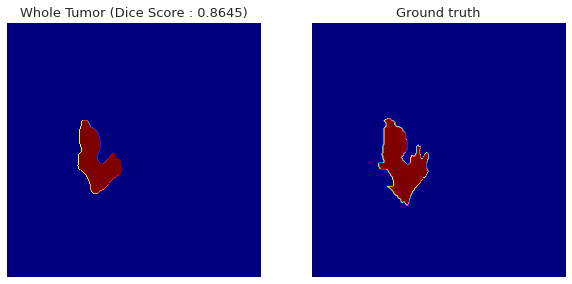

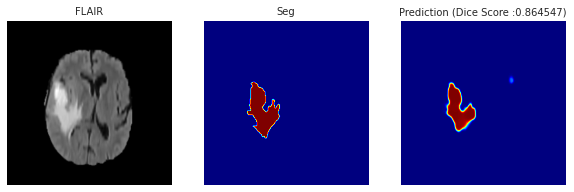

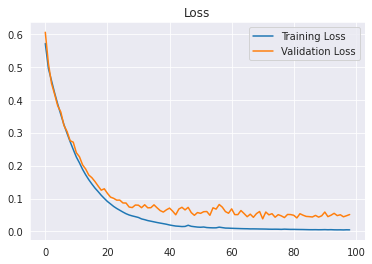

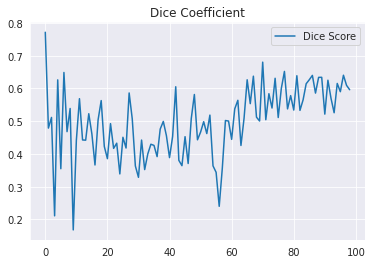

Training Epoch : [100/100]===============================================================================
Epoch: [100/100][0/20]	Time 0.824s (0.824s)	Speed 19.4 samples/s	Data 0.539s (0.539s)	Loss 0.00502 (0.00502)	
Epoch: [100/100][1/20]	Time 0.597s (0.710s)	Speed 26.8 samples/s	Data 0.419s (0.479s)	Loss 0.00324 (0.00413)	
Epoch: [100/100][2/20]	Time 0.573s (0.665s)	Speed 27.9 samples/s	Data 0.395s (0.451s)	Loss 0.00473 (0.00433)	
Epoch: [100/100][3/20]	Time 0.644s (0.659s)	Speed 24.8 samples/s	Data 0.466s (0.455s)	Loss 0.00637 (0.00484)	
Epoch: [100/100][4/20]	Time 0.603s (0.648s)	Speed 26.6 samples/s	Data 0.422s (0.448s)	Loss 0.00434 (0.00474)	
Epoch: [100/100][5/20]	Time 0.588s (0.638s)	Speed 27.2 samples/s	Data 0.409s (0.442s)	Loss 0.00473 (0.00474)	
Epoch: [100/100][6/20]	Time 0.559s (0.627s)	Speed 28.6 samples/s	Data 0.381s (0.433s)	Loss 0.00514 (0.00479)	
Epoch: [100/100][7/20]	Time 0.608s (0.624s)	Speed 26.3 samples/s	Data 0.429s (0.432s)	Loss 0.00489 (0.00481)	
Epoch: [100/10

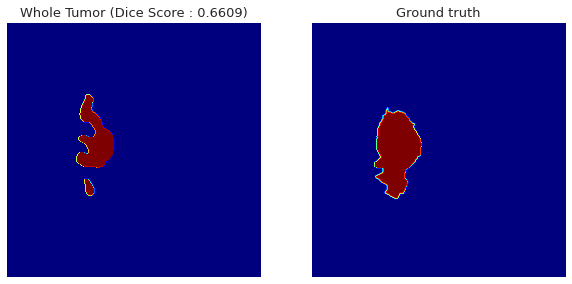

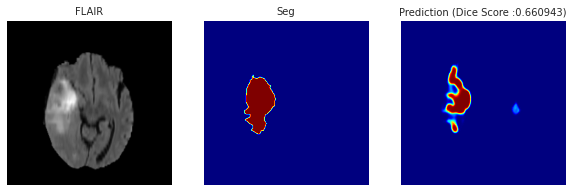

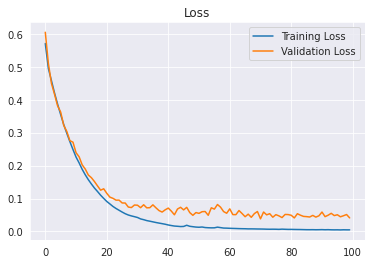

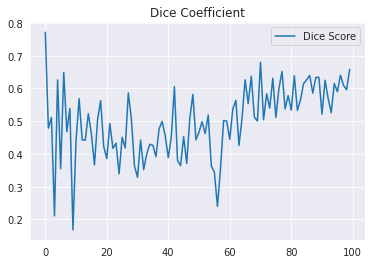

====================================== Finished Training ==================================>


In [ ]:
train_epoch_loss = []
val_epoch_loss = []
val_epoch_dice_score = []
val_best_loss = 10000
val_best_dice = 0.72
for epoch_idx in range(0,n_epochs):
    print(f"Training Epoch : [{epoch_idx+1}/{n_epochs}]===============================================================================")
    
    u_net.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    train_losses = AverageMeter()
    val_losses = AverageMeter()
    val_dice_coeff_list = AverageMeter()
    end = time.time()
    train_batch_loss = []
    for batch_idx, data_input in enumerate(train_data_loader):
        
        data_time.update(time.time() - end)
        
        train_img = data_input[0].to(device)
        train_img = torch.moveaxis(train_img,1,-1)
        label_img = data_input[1].to(device) 

        cur_batch_size = len(label_img)
        
        unet_optimizer.zero_grad()
        out_img = u_net(train_img.float())

        loss = criterion(out_img.squeeze(), label_img.float())
        # loss = dice_loss(out_img.squeeze(), label_img.float())


        # Update gradients
        loss.backward(retain_graph=True)
        # Update optimizer
        unet_optimizer.step()

        train_losses.update(loss.data.item())
        train_batch_loss.append(loss.data.item())

        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 1 == 0: #% 300 == 0:
            msg = 'Epoch: [{0}/{3}][{1}/{2}]\t' \
                  'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t' \
                  'Speed {speed:.1f} samples/s\t' \
                  'Data {data_time.val:.3f}s ({data_time.avg:.3f}s)\t' \
                  'Loss {train_loss.val:.5f} ({train_loss.avg:.5f})\t'.format(
                      epoch_idx+1, batch_idx,len(train_data_loader), n_epochs , batch_time=batch_time,
                      speed=data_input[0].size(0)/batch_time.val,
                      data_time=data_time, train_loss=train_losses)
            print(msg)
        
    if ( (epoch_idx )%1 == 0): 
      with torch.no_grad():
          u_net.eval()

          for batch_idx, val_data_input in enumerate(val_data_loader):
        
            
            val_img = val_data_input[0].to(device)
            val_img = torch.moveaxis(val_img,1,-1)
            val_label_img = val_data_input[1].to(device)

            out_val_img = u_net(val_img.float())

            val_loss = criterion(out_val_img.squeeze(), val_label_img.float())
            # val_loss = dice_loss(out_val_img.squeeze(), val_label_img.float())
            val_dice_coeff,_,_ = get_dice_coef(out_val_img.squeeze().cpu().numpy(), val_label_img.float().to(device).cpu().numpy(), 
                                          pred_thresh = 0.5, gt_thresh = None, is_plot = False)

            val_losses.update(val_loss.data.item())
            val_dice_coeff_list.update(val_dice_coeff)

    print(f'===============================Epoch : [{epoch_idx+1}/{n_epochs}]  Evaluation ==================================>')
    print(f"Training Loss           : {train_losses.avg}")
    print(f"Validation Loss         : {val_losses.avg}")
    print(f"Validation Dice Score   : {val_dice_coeff_list.avg}")

    train_epoch_loss.append(train_losses.avg)
    val_epoch_loss.append(val_losses.avg)
    val_epoch_dice_score.append(val_dice_coeff_list.avg)

    if (val_losses.avg < val_best_loss): 
            val_best_loss = val_losses.avg
            print("Saving Best Model =======================================>")
            torch.save(u_net, f'/content/drive/MyDrive/brats2018/Models/model_best_bceloss.pth.tar')
    if (val_dice_coeff_list.avg >= val_best_dice): 
            val_best_dice = val_dice_coeff_list.avg
            print("Saving Best (Dice) Model =======================================>")
            torch.save(u_net, f'/content/drive/MyDrive/brats2018/Models/model_best_dice_score.pth.tar')        
    torch.save(u_net, f'/content/drive/MyDrive/brats2018/Models/model_last_epoch.pth.tar')

    with torch.no_grad():
        img_vis, label_vis   = next(iter(val_data_loader))
        img_vis = torch.moveaxis(img_vis,1,-1)
        out_vis_img = u_net(img_vis.float())

        ind = 14
        dice_score,_,_ = get_dice_coef(out_vis_img.squeeze()[ind,:,:].cpu().numpy(), label_vis.float()[ind,:,:].to(device).cpu().numpy(), 
                                   pred_thresh = 0.5, gt_thresh = None)  
        
        fig, ax = plt.subplots(1,3, figsize=(10,10))
        ax[0].imshow(img_vis[ind,0,:,:].cpu(), cmap='gray'), ax[0].set_title('FLAIR',fontsize = 10),ax[0].axis('off')
        ax[1].imshow(label_vis[ind,:,:].cpu(), cmap='jet'), ax[1].set_title('Seg',fontsize = 10),ax[1].axis('off')
        ax[2].imshow(out_vis_img[ind,0,:,:].cpu(), cmap='jet'), ax[2].set_title(f'Prediction (Dice Score :{dice_score:4f})',fontsize = 10),ax[2].axis('off')
        plt.show()

        plt.figure()
        plt.plot(train_epoch_loss)
        plt.plot(val_epoch_loss)
        plt.legend(["Training Loss", "Validation Loss"], loc ="upper right")
        plt.title("Loss")
        plt.show()

        plt.figure()
        plt.plot(val_epoch_dice_score)
        plt.legend(["Dice Score"], loc ="upper right")
        plt.title("Dice Coefficient")
        plt.show()
        
    
print("====================================== Finished Training ==================================>")


Text(0.5, 1.0, 'Loss')

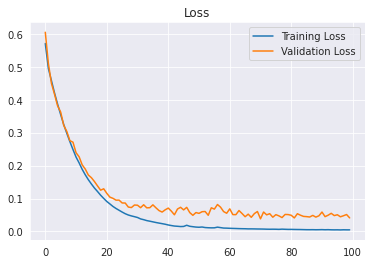

In [ ]:
#plot loss

plt.figure()
plt.plot(train_epoch_loss)
plt.plot(val_epoch_loss)
plt.legend(["Training Loss", "Validation Loss"], loc ="upper right")
plt.title("Loss")


### Evaluation

In [ ]:
val_test_loader = data.DataLoader(brats_val, batch_size = 64, shuffle = False)

u_net_test = torch.load('/content/drive/MyDrive/brats2018/Models/model_best_bceloss.pth.tar')
u_net_test.eval()
print("Model Loaded")

Model Loaded


In [ ]:
#Get Predictions
img_vis, label_vis   = next(iter(val_test_loader))
img_vis = torch.moveaxis(img_vis,1,-1)
out_vis_img = u_net_test(img_vis.float())

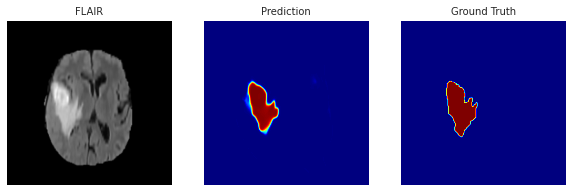

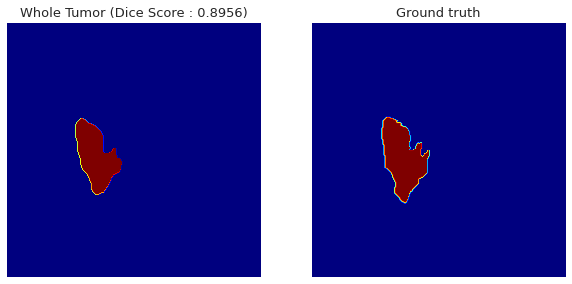

In [ ]:
ind = 49 #select a slice
fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(img_vis[ind,0,:,:].detach().cpu(), cmap='gray'), ax[0].set_title('FLAIR',fontsize = 10),ax[0].axis('off')
ax[1].imshow(out_vis_img[ind,0,:,:].detach().cpu(), cmap='jet'), ax[1].set_title(f'Prediction',fontsize = 10),ax[1].axis('off')
ax[2].imshow(label_vis[ind,:,:].detach().cpu(), cmap='jet'), ax[2].set_title('Ground Truth',fontsize = 10),ax[2].axis('off')
plt.show()

#Dice Coefficient
dice_score,pred_unet,gt_unet = get_dice_coef(out_vis_img.squeeze()[ind,:,:].detach().cpu().numpy(), label_vis.float()[ind,:,:].detach().to(device).cpu().numpy(), 
                            pred_thresh = 0.5, gt_thresh = None) 